<a href="https://colab.research.google.com/github/ivanf2110/MBA/blob/main/TCC_Ivan_completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC — Metodologia de Previsão de Séries Temporais no Varejo
## Da Estatística ao Aprendizado Profundo

**Autor:** Ivan Flavio Aparecido Bernardino  
**Curso:** MBA em Ciência de Dados — ICMC/USP

In [1]:
# !pip install --upgrade pip

In [2]:
# !pip install tensorflow==2.13.0

In [3]:
# !pip uninstall -y prophet fbprophet cmdstanpy numpy
# !pip install numpy==1.26.4 prophet==1.1.5 cmdstanpy==1.1.0


In [4]:
!pip install -q catboost

In [101]:
# ====================================================
# 1. IMPORTAÇÃO DE PACOTES
# ====================================================
import sys, os, warnings, importlib, platform, json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm as lgb
from prophet import Prophet
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

import os
import json
import requests

import zipfile
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

def is_available(pkg):
    try:
        return importlib.util.find_spec(pkg) is not None
    except Exception:
        return False

HAVE_XGB = is_available('xgboost')
HAVE_TF = is_available('tensorflow')
HAVE_PROPHET = is_available('prophet') or is_available('fbprophet')

print('Python:', platform.python_version())
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)
print('Matplotlib:', plt.matplotlib.__version__)
try:
    import statsmodels
    print('statsmodels:', statsmodels.__version__)
except Exception as e:
    print('statsmodels indisponível:', e)
print('xgboost disponível?', HAVE_XGB)
print('tensorflow disponível?', HAVE_TF)
print('prophet disponível?', HAVE_PROPHET)


plt.rcParams["figure.figsize"] = (32, 6)
plt.rcParams["axes.grid"] = True


import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
pd.plotting.register_matplotlib_converters()
%matplotlib inline


import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Variable to control Kaggle training.
TRAIN_OFFLINE = False
from pathlib import Path
from sklearn import preprocessing

# Configurações para economizar RAM
plt.style.use('ggplot')
pd.set_option('display.max_columns', 50)


Python: 3.12.12
NumPy: 1.26.4
Pandas: 2.2.2
Matplotlib: 3.10.0
statsmodels: 0.14.5
xgboost disponível? True
tensorflow disponível? True
prophet disponível? True


In [81]:
# Funções uteis

def analisar_dataframe(df):
    resultado = {}

    for coluna in df.columns:
        info_coluna = {}
        tipo = df[coluna].dtype

        # Verifica valores nulos
        nulos = df[coluna].isnull().sum()
        if nulos > 0:
            info_coluna['nulos'] = nulos

        # Coluna categórica ou string
        if tipo == 'object' or pd.api.types.is_categorical_dtype(df[coluna]):
            info_coluna['tipo'] = 'categórica'
            categorias = df[coluna].dropna().unique().tolist()
            contagem = df[coluna].value_counts(dropna=True).to_dict()
            info_coluna['categorias_distintas'] = categorias
            info_coluna['contagem_por_categoria'] = contagem

        # Coluna numérica
        elif pd.api.types.is_numeric_dtype(df[coluna]):
            info_coluna['tipo'] = 'numérica'
            info_coluna['mínimo'] = df[coluna].min()
            info_coluna['máximo'] = df[coluna].max()
            info_coluna['mediana'] = df[coluna].median()
            info_coluna['moda'] = df[coluna].mode().tolist()

        else:
            info_coluna['tipo'] = str(tipo)

        resultado[coluna] = info_coluna

    return resultado


# Funções para medir performance

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def rmsse(y_true, y_pred, y_train):
    """
    Calcula RMSSE (Root Mean Squared Scaled Error)
    """
    # Numerador: RMSE das previsões
    numerator = np.sqrt(np.mean((y_true - y_pred)**2))

    # Denominador: RMSE do naive forecast no conjunto de treino
    # Usando diferença de um período (y_t+1 - y_t)
    naive_errors = y_train.diff().dropna()

    if len(naive_errors) == 0:
        return np.nan

    denom = np.sqrt(np.mean(naive_errors**2))

    # Evitar divisão por zero
    if denom == 0 or np.isnan(denom):
        return np.nan

    return float(numerator / denom)

# Versão alternativa mais robusta:

def rmsse_robust(y_true, y_pred, y_train):
    """
    RMSSE = Root Mean Squared Scaled Error (robusta)
    """
    try:
        if len(y_true) == 0 or len(y_pred) == 0 or len(y_train) < 2:
            return np.nan
        numerator = np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))
        denom = np.sqrt(np.mean(np.diff(np.array(y_train))**2))
        if denom <= 1e-10 or np.isnan(denom):
            return np.nan
        return float(numerator / denom)
    except Exception as e:
        print(f"Erro no RMSSE: {e}")
        return np.nan

results = []
# garante lista de resultados
for result in results:
    print(f"Modelo: {result['modelo']}")
    print(f"  RMSE: {result['RMSE']:.3f}")
    print(f"  MAE: {result['MAE']:.3f}")
    print(f"  RMSSE: {result['RMSSE']:.3f}")
    print()

## 2. Ingestão dos Dados (Kaggle)

In [7]:


# URL correta do conteúdo RAW
url = "https://raw.githubusercontent.com/ivanf2110/MBA/main/kaggle.json"

# Baixa e salva o arquivo
response = requests.get(url)
with open("kaggle.json", "wb") as f:
    f.write(response.content)

# Carrega o JSON corretamente
with open("kaggle.json", "r") as f:
    kaggle_token = json.load(f)

# Define as variáveis de ambiente
os.environ['KAGGLE_USERNAME'] = kaggle_token['username']
os.environ['KAGGLE_KEY'] = kaggle_token['key']

In [8]:
!pip install kaggle
!kaggle competitions download -c m5-forecasting-accuracy

m5-forecasting-accuracy.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
# from google.colab import files
# files.upload()  # Escolha o arquivo kaggle.json

In [10]:
# Crie a pasta .kaggle e mova o arquivo para lá
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json

# Dê permissão ao arquivo
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
# Extraia o conteúdo do zip
with zipfile.ZipFile("m5-forecasting-accuracy.zip", "r") as zip_ref:
    zip_ref.extractall("walmart_dataset")

# Verifique os arquivos

print("Arquivos extraídos:", os.listdir("walmart_dataset"))

Arquivos extraídos: ['sales_train_validation.csv', 'calendar.csv', 'sample_submission.csv', 'sell_prices.csv', 'sales_train_evaluation.csv']


In [12]:
# 1. FUNÇÃO PARA ECONOMIZAR MEMÓRIA (SIMPLIFICADA)
def economizar_memoria(df, nome):
    """Função simples para reduzir uso de memória"""
    memoria_inicial = df.memory_usage().sum() / 1024**2
    print(f"\n📊 {nome}:")
    print(f"   Memória inicial: {memoria_inicial:.1f} MB")

    # Converte colunas de texto para categoria
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')
        elif 'int' in str(df[col].dtype):
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif 'float' in str(df[col].dtype):
            df[col] = pd.to_numeric(df[col], downcast='float')

    memoria_final = df.memory_usage().sum() / 1024**2
    print(f"   Memória final: {memoria_final:.1f} MB")
    print(f"   Economia: {(memoria_inicial - memoria_final):.1f} MB")

    return df

# 2. CARREGAR OS DADOS
print("\n📁 CARREGANDO ARQUIVOS...")

# Carrega cada arquivo com economia de memória
vendas = pd.read_csv("walmart_dataset/sales_train_validation.csv")
vendas = economizar_memoria(vendas, "VENDAS")

calendario = pd.read_csv("walmart_dataset/calendar.csv")
calendario = economizar_memoria(calendario, "CALENDÁRIO")

precos = pd.read_csv("walmart_dataset/sell_prices.csv")
precos = economizar_memoria(precos, "PREÇOS")

print("\n✅ DADOS CARREGADOS COM SUCESSO!")

# 3. ANÁLISE EXPLORATÓRIA BÁSICA
print("\n" + "="*50)
print("📈 ANÁLISE EXPLORATÓRIA BÁSICA")
print("="*50)


📁 CARREGANDO ARQUIVOS...

📊 VENDAS:
   Memória inicial: 446.4 MB
   Memória final: 94.6 MB
   Economia: 351.8 MB

📊 CALENDÁRIO:
   Memória inicial: 0.2 MB
   Memória final: 0.2 MB
   Economia: 0.0 MB

📊 PREÇOS:
   Memória inicial: 208.8 MB
   Memória final: 58.8 MB
   Economia: 150.0 MB

✅ DADOS CARREGADOS COM SUCESSO!

📈 ANÁLISE EXPLORATÓRIA BÁSICA


In [13]:

vendas.head()


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  ...  d_1889  d_1890  d_1891  \
0     0     0     0     0     0     0     0  ...       0       0       0   
1     0     0     0     0     0     0     0  ...       0       0       0   
2     0     0     0     0     0     0     0  ...       0       0       0   
3     0     0     0     0     0     0     0  ...       0       3       1   
4     0     0     0     0     0     0     0  ...       4       0       1   

   d_1892  d_1893  d_1894  d_1895  d_1896  d_1897  d_1898  d_1899  d_1900  \
0       1       0       4       2       3       0       1       2       0   
1       0       0       0       0       0       0       0       0       0   
2       1       0       0       0       1       0       0       0       0   
3       2       1       3       1       0       2       5       4       2   
4       4       0       1       0       1       0       1       1       2   

   d_1901  d_1902  d_1903  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  \
0       0       0       1       1       3       0       1       1       1   
1       0       0       0       0       0       0       0       0       1   
2       0       1       2       2       1       2       1       1       1   
3       0       3       0       1       0       5       4       1       0   
4       0       1       1       2       1       1       0       1       1   

   d_1910  d_1911  d_1912  d_1913  
0       3       0       1       1  
1       0       0       0       0  
2       0       1       1       1  
3       1       3       7       2  
4       2       2       2       4  

[5 rows x 1919 columns]

In [14]:

calendario.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [15]:

precos.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

Visão Geral dos Dados

O conjunto de dados M5 Forecasting – Accuracy, disponibilizado pelo Walmart no Kaggle, é composto por cinco arquivos CSV.
Ele contém informações de vendas diárias de produtos, preços e eventos especiais, com o objetivo de prever a demanda futura.

Arquivo 1: calendar.csv

Contém as datas em que os produtos foram vendidos, além de informações sobre eventos e feriados.

Colunas:

date: Data no formato “YYYY-MM-DD”.

wm_yr_wk: Identificador da semana correspondente à data.

weekday / wday: Dia da semana (sábado, domingo, …, sexta) e seu identificador numérico.

month / year: Mês e ano da data.

event_name_1 / event_type_1: Nome e tipo do primeiro evento (se houver).

event_name_2 / event_type_2: Nome e tipo do segundo evento (se houver).

snap_CA, snap_TX, snap_WI: Variáveis binárias (0 ou 1) que indicam se as lojas da Califórnia (CA), Texas (TX) ou Wisconsin (WI) permitem compras via programa SNAP na respectiva data.

Arquivo 2: sales_train_validation.csv

Contém o histórico diário de vendas (em unidades) por produto e loja, do dia d_1 ao d_1913.

Colunas:

item_id: Identificador do produto.

dept_id: Identificador do departamento ao qual o produto pertence.

cat_id: Identificador da categoria do produto.

store_id: Identificador da loja onde o produto foi vendido.

state_id: Identificador do estado onde a loja está localizada.

d_1 … d_1941: Quantidade de unidades vendidas em cada dia.

Arquivo 3: sell_prices.csv

Contém informações sobre os preços dos produtos, por loja e por semana.

Colunas:

store_id: Identificador da loja.

item_id: Identificador do produto.

wm_yr_wk: Identificador semanal (correspondente ao arquivo calendar.csv).

sell_price: Preço médio do produto naquela semana e loja.

Arquivo 5: sales_train_evaluation.csv

Semelhante ao arquivo de validação, porém com dados de vendas estendidos até o dia d_1941.
É utilizado para prever as vendas do período d_1942–d_1969.

Divisão dos conjuntos:

Treinamento: d_1 – d_1913

Validação: d_1914 – d_1941

Avaliação: d_1942 – d_1969

In [16]:
# 3. ANÁLISE EXPLORATÓRIA BÁSICA
print("\n" + "="*50)
print("📈 ANÁLISE EXPLORATÓRIA BÁSICA")
print("="*50)

# 3.1 Análise das Vendas
print("\n🛒 ANÁLISE DAS VENDAS:")
print(f"• Total de produtos: {vendas.shape[0]:,}")
print(f"• Período de dias: {len([col for col in vendas.columns if 'd_' in col])} dias")
print(f"• Categorias: {vendas['cat_id'].unique().tolist()}")
print(f"• Departamentos: {vendas['dept_id'].unique().tolist()}")
print(f"• Estados: {vendas['state_id'].unique().tolist()}")

# 3.2 Análise do Calendário
print("\n📅 ANÁLISE DO CALENDÁRIO:")
calendario['date'] = pd.to_datetime(calendario['date'])
print(f"• Período: {calendario['date'].min().strftime('%Y-%m-%d')} a {calendario['date'].max().strftime('%Y-%m-%d')}")
print(f"• Total de dias: {len(calendario):,}")
print(f"• Tipos de evento: {calendario['event_type_1'].nunique()}")
print(f"• Eventos únicos: {calendario['event_name_1'].nunique()}")

# 3.3 Análise dos Preços
print("\n💰 ANÁLISE DOS PREÇOS:")
print(f"• Registros de preços: {precos.shape[0]:,}")
print(f"• Preço médio: R$ {precos['sell_price'].mean():.2f}")
print(f"• Maior preço: R$ {precos['sell_price'].max():.2f}")
print(f"• Menor preço: R$ {precos['sell_price'].min():.2f}")


📈 ANÁLISE EXPLORATÓRIA BÁSICA

🛒 ANÁLISE DAS VENDAS:
• Total de produtos: 30,490
• Período de dias: 1913 dias
• Categorias: ['HOBBIES', 'HOUSEHOLD', 'FOODS']
• Departamentos: ['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3']
• Estados: ['CA', 'TX', 'WI']

📅 ANÁLISE DO CALENDÁRIO:
• Período: 2011-01-29 a 2016-06-19
• Total de dias: 1,969
• Tipos de evento: 4
• Eventos únicos: 30

💰 ANÁLISE DOS PREÇOS:
• Registros de preços: 6,841,121
• Preço médio: R$ 4.41
• Maior preço: R$ 107.32
• Menor preço: R$ 0.01


In [17]:
# 3.1 Análise das Vendas
print("\n🛒 ANÁLISE DAS VENDAS:")
analise = analisar_dataframe(vendas)
for coluna, info in analise.items():
    if coluna.startswith('d_'):
        continue  # pula colunas que começam com 'd_'

    print(f"\n📊 Coluna: {coluna}")
    for chave, valor in info.items():
        print(f"  - {chave}: {valor}")


# 3.1 Análise calendario
print("\n📅 ANÁLISE DO CALENDÁRIO:")
analise = analisar_dataframe(calendario)
for coluna, info in analise.items():
    print(f"\n📊 Coluna: {coluna}")
    for chave, valor in info.items():
        print(f"  - {chave}: {valor}")


# 3.1 Análise preços
print("\n💰 ANÁLISE DOS PREÇOS:")
analise = analisar_dataframe(precos)
for coluna, info in analise.items():
    print(f"\n📊 Coluna: {coluna}")
    for chave, valor in info.items():
        print(f"  - {chave}: {valor}")




🛒 ANÁLISE DAS VENDAS:

📊 Coluna: id
  - tipo: categórica
  - categorias_distintas: ['HOBBIES_1_001_CA_1_validation', 'HOBBIES_1_002_CA_1_validation', 'HOBBIES_1_003_CA_1_validation', 'HOBBIES_1_004_CA_1_validation', 'HOBBIES_1_005_CA_1_validation', 'HOBBIES_1_006_CA_1_validation', 'HOBBIES_1_007_CA_1_validation', 'HOBBIES_1_008_CA_1_validation', 'HOBBIES_1_009_CA_1_validation', 'HOBBIES_1_010_CA_1_validation', 'HOBBIES_1_011_CA_1_validation', 'HOBBIES_1_012_CA_1_validation', 'HOBBIES_1_013_CA_1_validation', 'HOBBIES_1_014_CA_1_validation', 'HOBBIES_1_015_CA_1_validation', 'HOBBIES_1_016_CA_1_validation', 'HOBBIES_1_017_CA_1_validation', 'HOBBIES_1_018_CA_1_validation', 'HOBBIES_1_019_CA_1_validation', 'HOBBIES_1_020_CA_1_validation', 'HOBBIES_1_021_CA_1_validation', 'HOBBIES_1_022_CA_1_validation', 'HOBBIES_1_023_CA_1_validation', 'HOBBIES_1_024_CA_1_validation', 'HOBBIES_1_025_CA_1_validation', 'HOBBIES_1_026_CA_1_validation', 'HOBBIES_1_027_CA_1_validation', 'HOBBIES_1_028_CA_1_vali


📊 CRIANDO VISUALIZAÇÕES


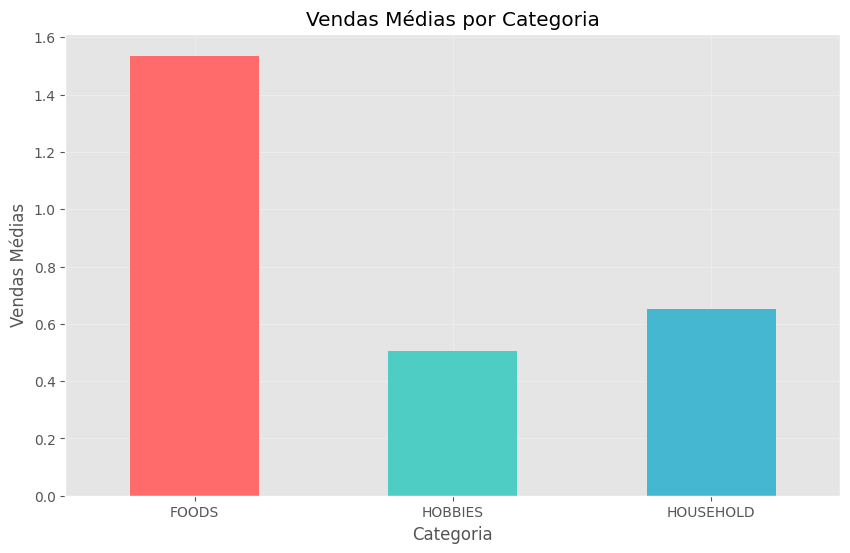

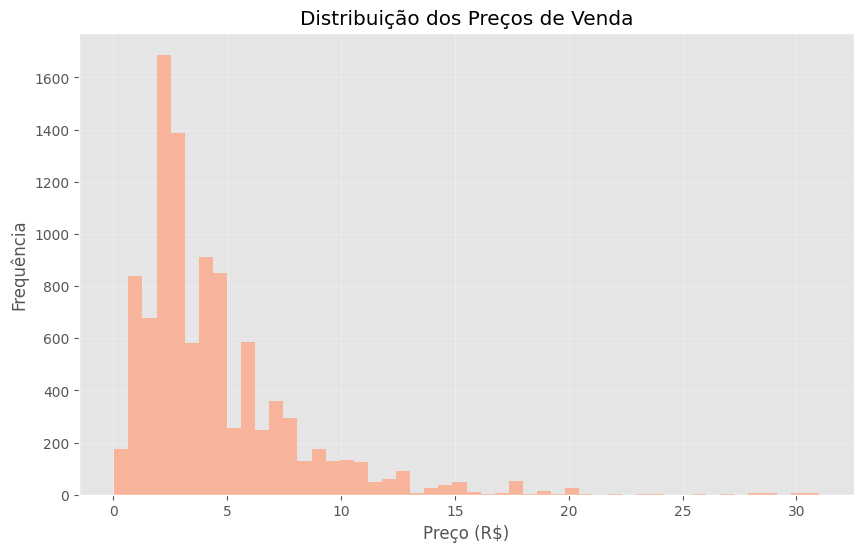

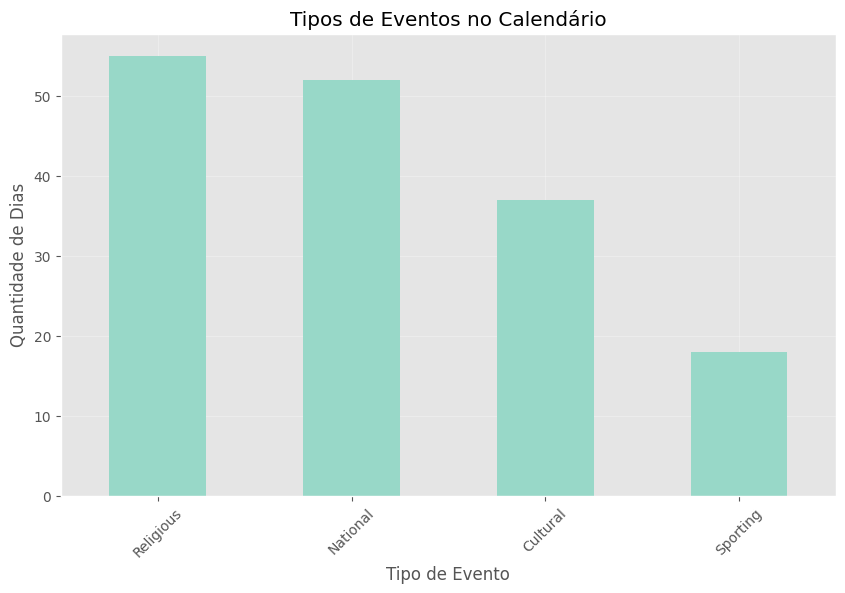

In [18]:
# 4. VISUALIZAÇÕES PRINCIPAIS
print("\n" + "="*50)
print("📊 CRIANDO VISUALIZAÇÕES")
print("="*50)

# 4.1 Distribuição de Vendas por Categoria
plt.figure(figsize=(10, 6))

# Pega algumas colunas de dias para análise
dias_amostra = ['d_100', 'd_200', 'd_300', 'd_400', 'd_500', 'd_600', 'd_700', 'd_800', 'd_900', 'd_1000']
dias_disponiveis = [col for col in vendas.columns if col in dias_amostra]

if dias_disponiveis:
    vendas_por_categoria = vendas.groupby('cat_id')[dias_disponiveis].mean().mean(axis=1)
    vendas_por_categoria.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    plt.title('Vendas Médias por Categoria')
    plt.xlabel('Categoria')
    plt.ylabel('Vendas Médias')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("⚠️  Colunas de dias não encontradas para visualização")

# 4.2 Distribuição de Preços
plt.figure(figsize=(10, 6))

# Amostra de preços para não sobrecarregar
precos_amostra = precos.sample(n=min(10000, len(precos)), random_state=42)
plt.hist(precos_amostra['sell_price'], bins=50, alpha=0.7, color='#FFA07A')
plt.title('Distribuição dos Preços de Venda')
plt.xlabel('Preço (R$)')
plt.ylabel('Frequência')
plt.grid(True, alpha=0.3)
plt.show()

# 4.3 Eventos no Calendário
plt.figure(figsize=(10, 6))

if 'event_type_1' in calendario.columns:
    eventos_por_tipo = calendario['event_type_1'].value_counts()
    if not eventos_por_tipo.empty:
        eventos_por_tipo.plot(kind='bar', color='#98D8C8')
        plt.title('Tipos de Eventos no Calendário')
        plt.xlabel('Tipo de Evento')
        plt.ylabel('Quantidade de Dias')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.show()



In [19]:
# 5. ANÁLISE DE VALORES NULOS
print("\n" + "="*50)
print("🔍 ANÁLISE DE VALORES NULOS")
print("="*50)

print("\n📊 VENDAS - Valores Nulos:")
nulos_vendas = vendas.isnull().sum()
if nulos_vendas.sum() == 0:
    print("✅ Nenhum valor nulo encontrado!")
else:
    print(nulos_vendas[nulos_vendas > 0])

print("\n📅 CALENDÁRIO - Valores Nulos:")
for col in calendario.columns:
    nulos = calendario[col].isnull().sum()
    if nulos > 0:
        print(f"• {col}: {nulos} nulos ({nulos/len(calendario)*100:.1f}%)")

print("\n💰 PREÇOS - Valores Nulos:")
nulos_precos = precos.isnull().sum()
if nulos_precos.sum() == 0:
    print("✅ Nenhum valor nulo encontrado!")
else:
    print(nulos_precos[nulos_precos > 0])


🔍 ANÁLISE DE VALORES NULOS

📊 VENDAS - Valores Nulos:
✅ Nenhum valor nulo encontrado!

📅 CALENDÁRIO - Valores Nulos:
• event_name_1: 1807 nulos (91.8%)
• event_type_1: 1807 nulos (91.8%)
• event_name_2: 1964 nulos (99.7%)
• event_type_2: 1964 nulos (99.7%)

💰 PREÇOS - Valores Nulos:
✅ Nenhum valor nulo encontrado!


## 2. Entendimento dos dados

In [20]:
date_col = [col for col in vendas if col.startswith('d_')]
print(date_col)

['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10', 'd_11', 'd_12', 'd_13', 'd_14', 'd_15', 'd_16', 'd_17', 'd_18', 'd_19', 'd_20', 'd_21', 'd_22', 'd_23', 'd_24', 'd_25', 'd_26', 'd_27', 'd_28', 'd_29', 'd_30', 'd_31', 'd_32', 'd_33', 'd_34', 'd_35', 'd_36', 'd_37', 'd_38', 'd_39', 'd_40', 'd_41', 'd_42', 'd_43', 'd_44', 'd_45', 'd_46', 'd_47', 'd_48', 'd_49', 'd_50', 'd_51', 'd_52', 'd_53', 'd_54', 'd_55', 'd_56', 'd_57', 'd_58', 'd_59', 'd_60', 'd_61', 'd_62', 'd_63', 'd_64', 'd_65', 'd_66', 'd_67', 'd_68', 'd_69', 'd_70', 'd_71', 'd_72', 'd_73', 'd_74', 'd_75', 'd_76', 'd_77', 'd_78', 'd_79', 'd_80', 'd_81', 'd_82', 'd_83', 'd_84', 'd_85', 'd_86', 'd_87', 'd_88', 'd_89', 'd_90', 'd_91', 'd_92', 'd_93', 'd_94', 'd_95', 'd_96', 'd_97', 'd_98', 'd_99', 'd_100', 'd_101', 'd_102', 'd_103', 'd_104', 'd_105', 'd_106', 'd_107', 'd_108', 'd_109', 'd_110', 'd_111', 'd_112', 'd_113', 'd_114', 'd_115', 'd_116', 'd_117', 'd_118', 'd_119', 'd_120', 'd_121', 'd_122', 'd_123', 

state_id
CA    12196
TX     9147
WI     9147
Name: count, dtype: int64


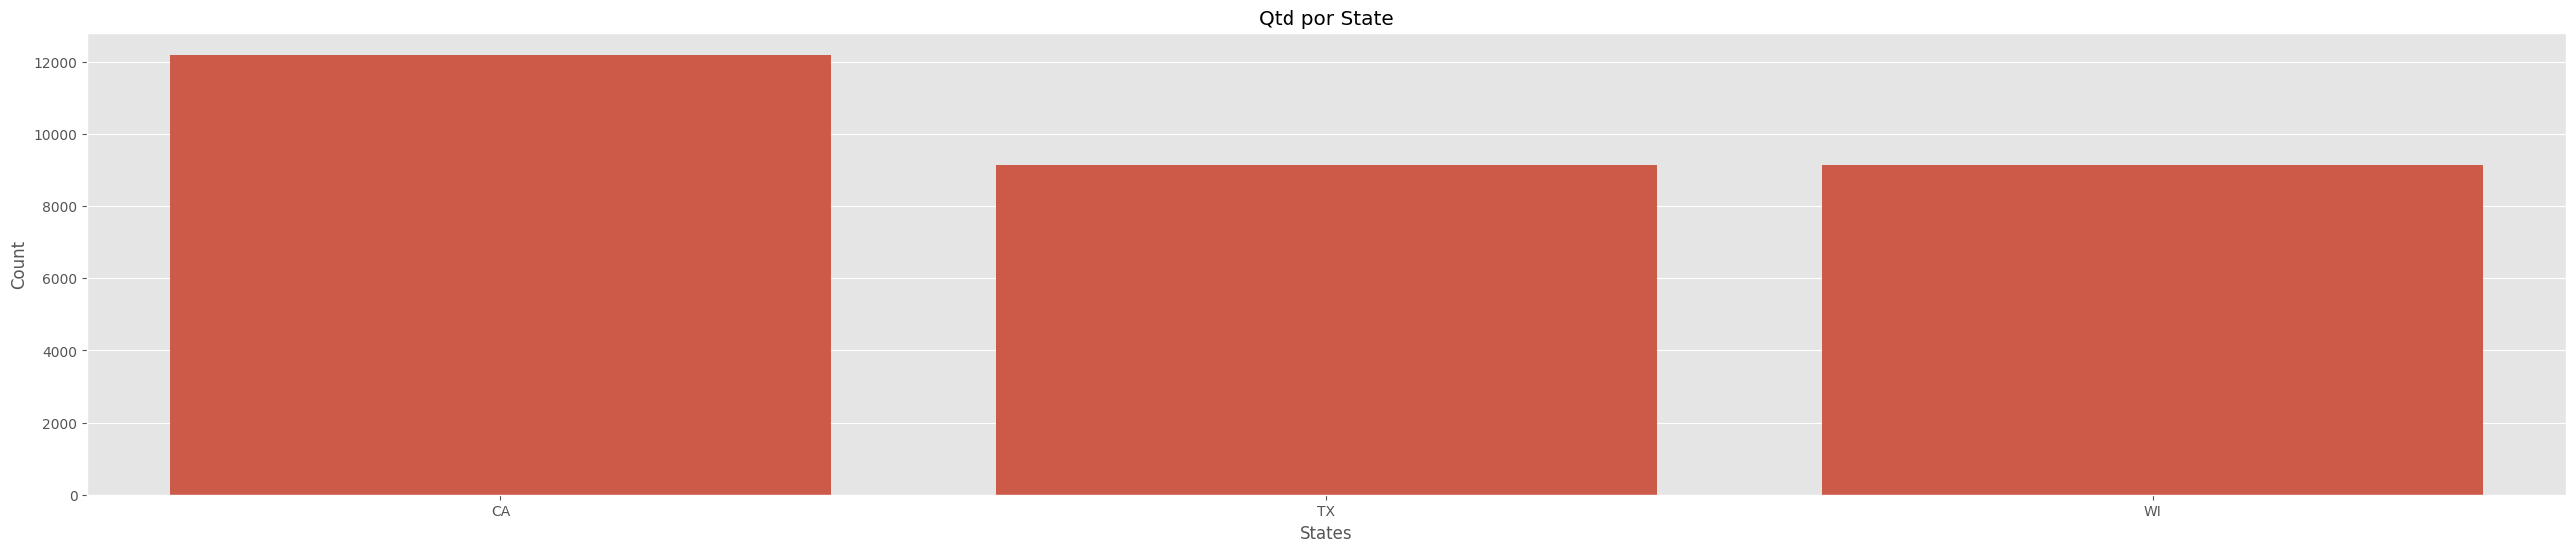

In [21]:
# Contagem por states

sales_state = vendas.state_id.value_counts()
print(sales_state)

# gráfico
sales_state_df = sales_state.reset_index()
sales_state_df.columns = ['state_id', 'count']

# Gráfico de barras
sns.barplot(x='state_id', y='count', data=sales_state_df)
plt.xlabel('States')
plt.ylabel('Count')
plt.title('Qtd por State')
plt.show()


In [22]:
# Participação por state (qtd)
percent_state = vendas.state_id.value_counts()/vendas.shape[0] * 100
print(percent_state)

state_id
CA    40.0
TX    30.0
WI    30.0
Name: count, dtype: float64


In [23]:
# Inclusão do total de vendas e depois total por state
vendas['total_sales'] = vendas[date_col].sum(axis=1)

vendas.groupby('state_id').agg({'total_sales':'sum'}).reset_index()

vendas.groupby('state_id').agg({'total_sales':'sum'})/vendas.total_sales.sum() * 100



total_sales
state_id             
CA          43.649240
TX          28.767621
WI          27.583139

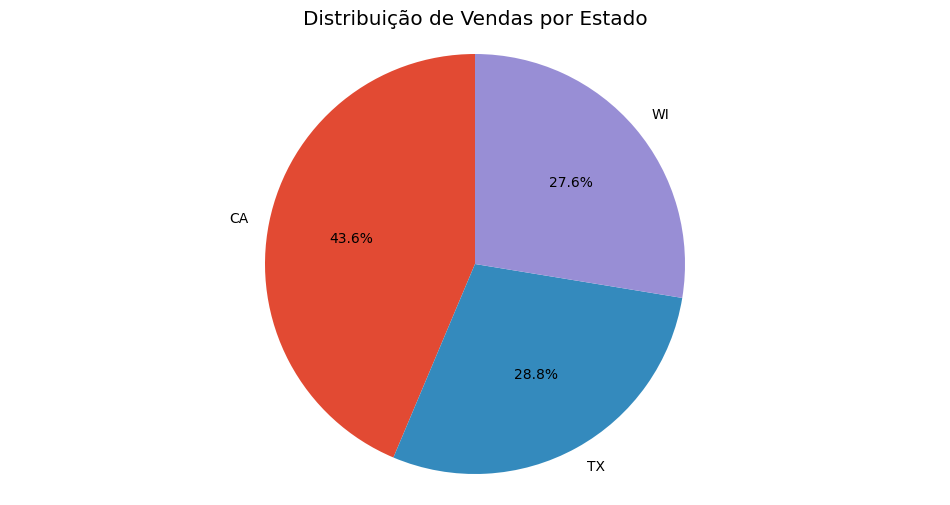

In [24]:
aux = vendas.groupby('state_id').agg({'total_sales':'sum'})/vendas.total_sales.sum() * 100
aux_percent = aux / aux.total_sales.sum() * 100

# Preparar dados para o gráfico
labels = aux_percent.index.tolist()
sizes = aux_percent['total_sales'].tolist()

# Gráfico de pizza
plt.figure(figsize=(12, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de Vendas por Estado')
plt.axis('equal')
plt.show()




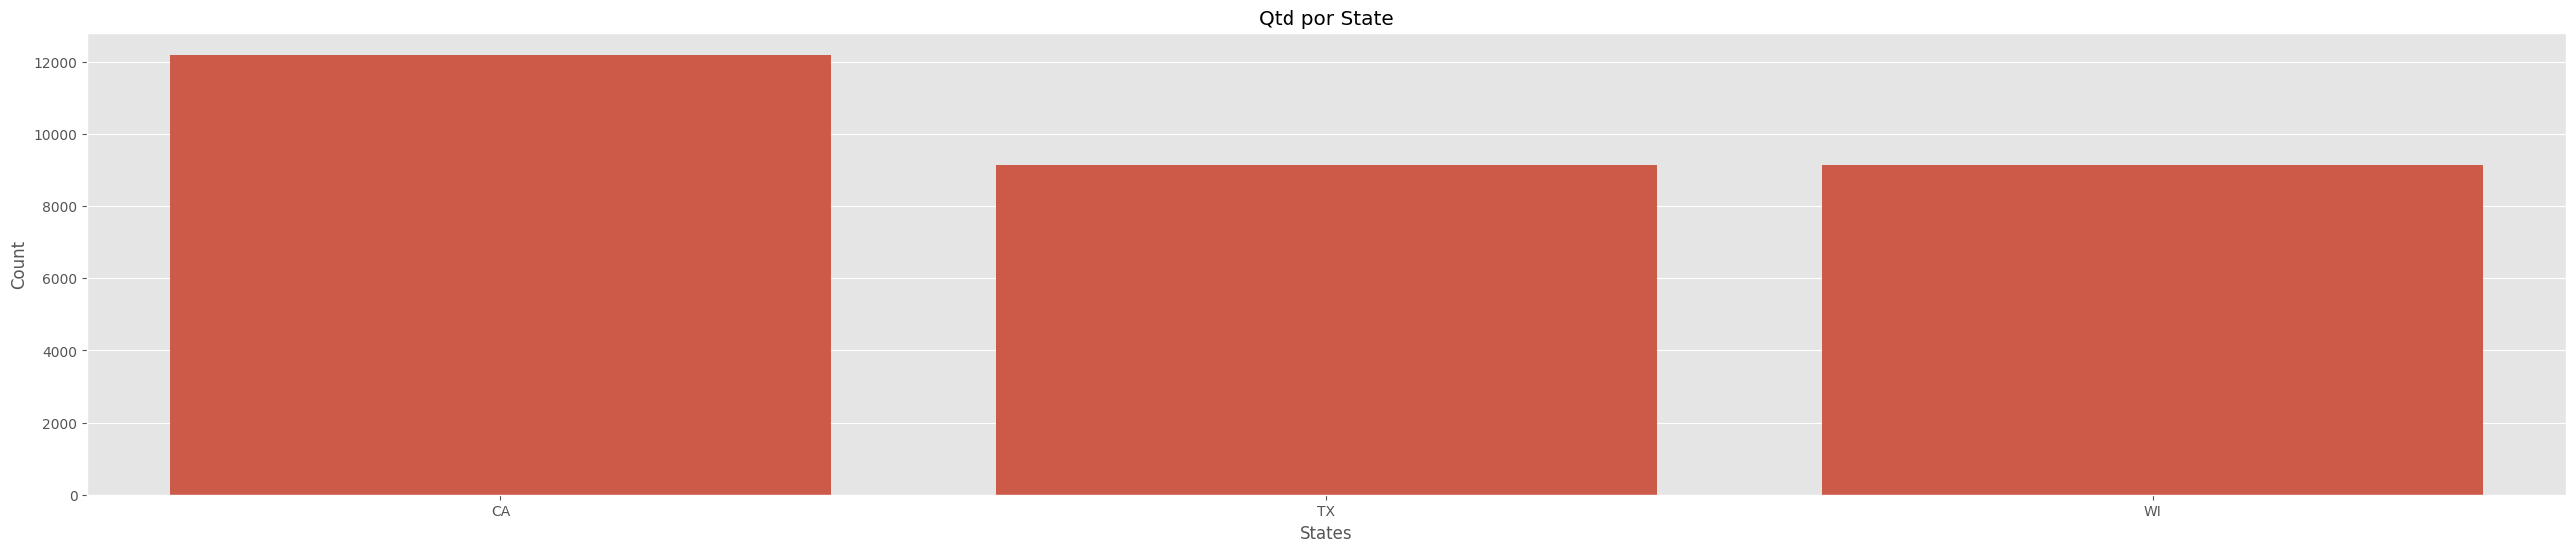

In [25]:
# gráfico em valor
sales_state_df = sales_state.reset_index()
sales_state_df.columns = ['state_id', 'count']

# Gráfico de barras
sns.barplot(x='state_id', y='count', data=sales_state_df)
plt.xlabel('States')
plt.ylabel('Count')
plt.title('Qtd por State')
plt.show()

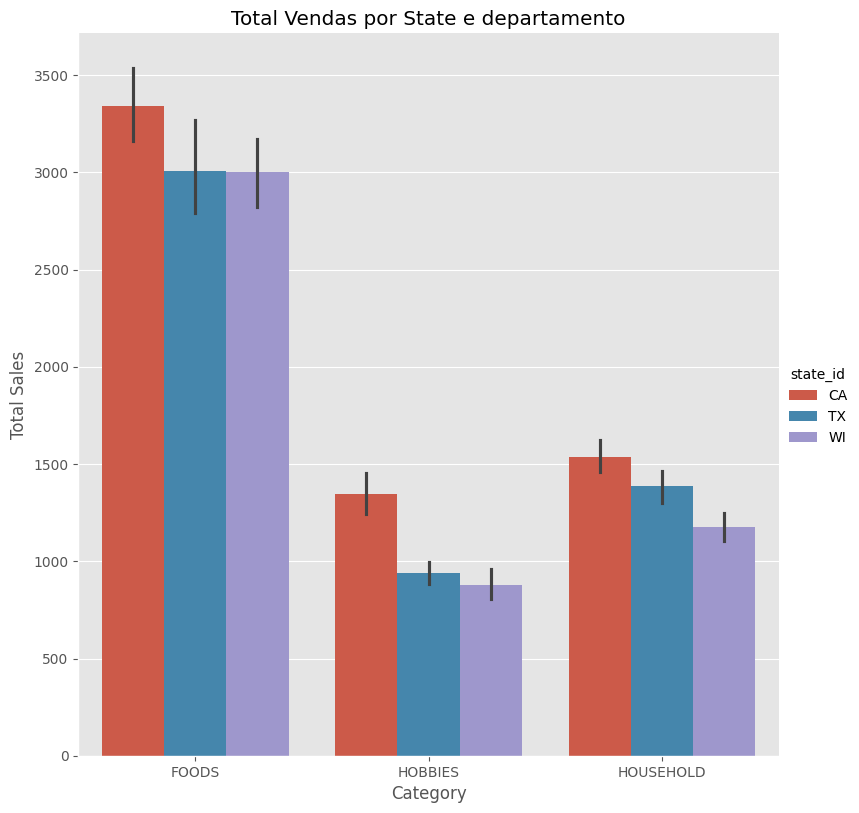

In [26]:
# Seleciona apenas colunas de vendas (que começam com 'd_')
vendas_cols = [col for col in vendas.columns if col.startswith('d_')]

# Soma apenas essas colunas
vendas['total_sales'] = vendas[vendas_cols].sum(axis=1)

# gráfico
sns.catplot(x='cat_id', y='total_sales',
            hue='state_id',
            data=vendas, kind='bar',
            height=8, aspect=1)

plt.title('Total Vendas por State e departamento')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.show()


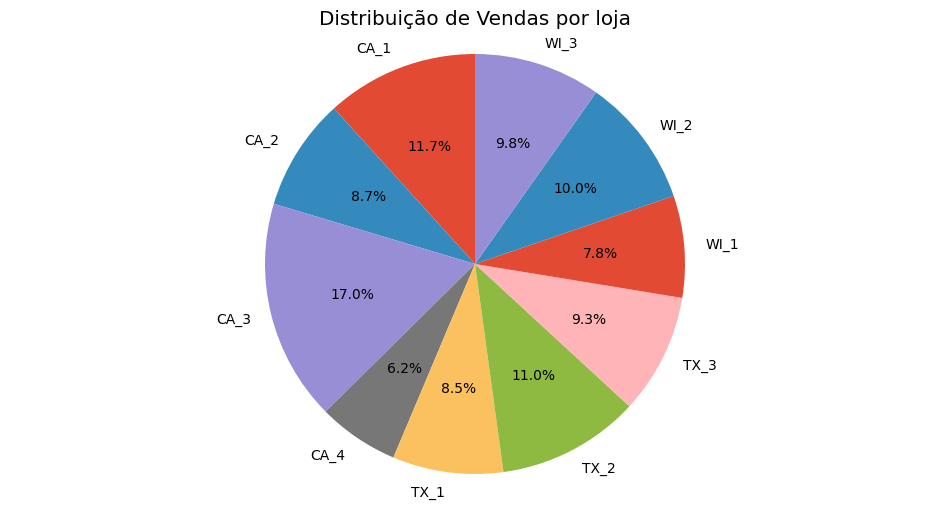

In [27]:
aux = vendas.groupby('store_id').agg({'total_sales':'sum'})/vendas.total_sales.sum() * 100
aux_percent = aux / aux.total_sales.sum() * 100

# Preparar dados para o gráfico
labels = aux_percent.index.tolist()
sizes = aux_percent['total_sales'].tolist()

# Gráfico de pizza
plt.figure(figsize=(12, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de Vendas por loja')
plt.axis('equal')
plt.show()




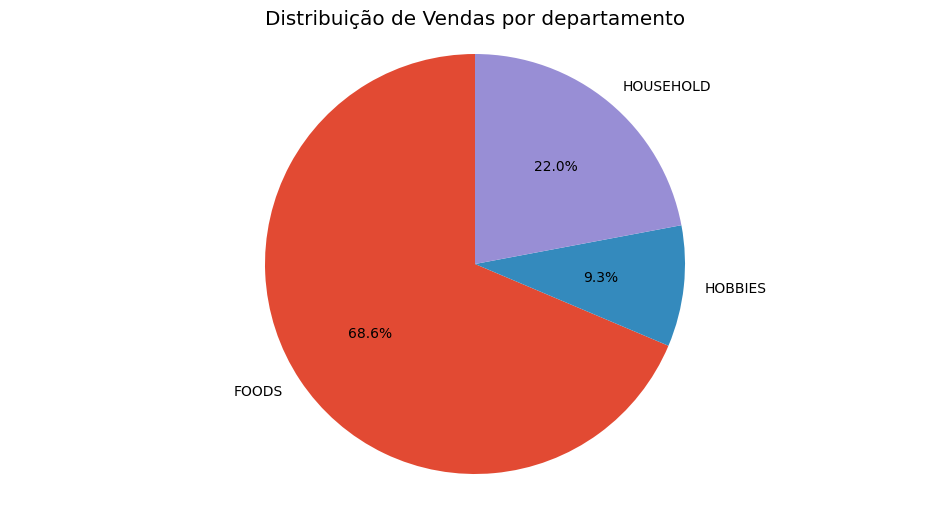

In [28]:
aux = vendas.groupby('cat_id').agg({'total_sales':'sum'})/vendas.total_sales.sum() * 100
aux_percent = aux / aux.total_sales.sum() * 100

# Preparar dados para o gráfico
labels = aux_percent.index.tolist()
sizes = aux_percent['total_sales'].tolist()

# Gráfico de pizza
plt.figure(figsize=(12, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de Vendas por departamento')
plt.axis('equal')
plt.show()




In [29]:
# Série de vendas por states


# Colunas de demanda
d_cols = [c for c in vendas.columns if c.startswith('d_')]

# Agrupa por estado e soma as demandas diárias
state_series = vendas.groupby('state_id')[d_cols].sum()

# Lista de estados
ids = state_series.index.tolist()
n = len(ids)

# Cria subplots
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Estado: {state}" for state in ids])

# Adiciona os gráficos
cores = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
for i, state in enumerate(ids):
    x = np.arange(len(d_cols))
    y = state_series.loc[state].values
    fig.add_trace(go.Scatter(x=x, y=y, showlegend=False,
                             mode='lines', marker=dict(color=cores[i % len(cores)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Demanda agregada por estado ao longo do tempo")
fig.show()

In [30]:
# departamento por state CA

# Colunas de demanda
d_cols = [c for c in vendas.columns if c.startswith('d_')]

# Agrupa por estado e soma as demandas diárias
aux = vendas[vendas['state_id'] == 'CA']
aux = aux.groupby('cat_id')[d_cols].sum()

# Lista de estados
ids = aux.index.tolist()

n = len(ids)

# Cria subplots
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Depart: {depart}" for depart in ids])

# Adiciona os gráficos
cores = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
for i, depart in enumerate(ids):
    x = np.arange(len(d_cols))
    y = aux.loc[depart].values
    fig.add_trace(go.Scatter(x=x, y=y, showlegend=False,
                             mode='lines', marker=dict(color=cores[i % len(cores)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Vendas por departamento em CA ao longo do tempo")
fig.show()


In [31]:
# departamento por state TX

# Colunas de demanda
d_cols = [c for c in vendas.columns if c.startswith('d_')]

# Agrupa por estado e soma as demandas diárias
aux = vendas[vendas['state_id'] == 'TX']
aux = aux.groupby('cat_id')[d_cols].sum()

# Lista de estados
ids = aux.index.tolist()

n = len(ids)

# Cria subplots
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Depart: {depart}" for depart in ids])

# Adiciona os gráficos
cores = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
for i, depart in enumerate(ids):
    x = np.arange(len(d_cols))
    y = aux.loc[depart].values
    fig.add_trace(go.Scatter(x=x, y=y, showlegend=False,
                             mode='lines', marker=dict(color=cores[i % len(cores)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Vendas por departamento em TX ao longo do tempo")
fig.show()


In [32]:
# departamento por state WI

# Colunas de demanda
d_cols = [c for c in vendas.columns if c.startswith('d_')]

# Agrupa por estado e soma as demandas diárias
aux = vendas[vendas['state_id'] == 'WI']
aux = aux.groupby('cat_id')[d_cols].sum()

# Lista de estados
ids = aux.index.tolist()

n = len(ids)

# Cria subplots
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Depart: {depart}" for depart in ids])

# Adiciona os gráficos
cores = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
for i, depart in enumerate(ids):
    x = np.arange(len(d_cols))
    y = aux.loc[depart].values
    fig.add_trace(go.Scatter(x=x, y=y, showlegend=False,
                             mode='lines', marker=dict(color=cores[i % len(cores)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Vendas por departamento em WI ao longo do tempo")
fig.show()


In [33]:
# MAIORES PRODUTOS DE CADA CATEGORIA

# IDs únicos top 3 de cada departamento
aux = vendas.groupby(['cat_id', 'item_id']).agg({'total_sales': 'sum'}).reset_index()

# Aplica rank por dept_id e filtra os top 3
aux = aux.groupby('cat_id').apply(lambda x: x.nlargest(3, 'total_sales')).reset_index(drop=True)
aux = aux.sort_values(by=['cat_id', 'total_sales'], ascending=[True, False])
print(aux)

ids = aux['item_id'].tolist()


# Lista de item_ids únicos
ids = list(set(aux['item_id']))
d_cols = [c for c in vendas.columns if 'd_' in c]

# Número de itens a plotar
n = len(ids)

# Cria subplots dinâmicos
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Produto: {item}" for item in ids])

# Adiciona os gráficos
for i, item_id in enumerate(ids):
    x = vendas.loc[vendas['item_id'] == item_id].set_index('item_id')[d_cols].values[0]
    cor = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
    fig.add_trace(go.Scatter(x=np.arange(len(x)), y=x, showlegend=False,
                             mode='lines', marker=dict(color=cor[i % len(cor)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Vendas por item_id")
fig.show()


      cat_id          item_id  total_sales
0      FOODS      FOODS_3_090      1002529
1      FOODS      FOODS_3_586       920242
2      FOODS      FOODS_3_252       565299
3    HOBBIES    HOBBIES_1_371       122565
4    HOBBIES    HOBBIES_1_348       105876
5    HOBBIES    HOBBIES_1_268        95171
6  HOUSEHOLD  HOUSEHOLD_1_334       171275
7  HOUSEHOLD  HOUSEHOLD_1_459       170532
8  HOUSEHOLD  HOUSEHOLD_1_521       153340


In [34]:
# departamento por state CA

# Colunas de demanda
d_cols = [c for c in vendas.columns if c.startswith('d_')]

# Agrupa por estado e soma as demandas diárias
aux = vendas[vendas['state_id'] == 'CA']
aux = aux.groupby('store_id')[d_cols].sum()

# Lista de estados
ids = aux.index.tolist()
ids
n = len(ids)

# Cria subplots
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Depart: {depart}" for depart in ids])

# Adiciona os gráficos
cores = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
for i, depart in enumerate(ids):
    x = np.arange(len(d_cols))
    y = aux.loc[depart].values
    fig.add_trace(go.Scatter(x=x, y=y, showlegend=False,
                             mode='lines', marker=dict(color=cores[i % len(cores)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Vendas por LOJA EM em CA ao longo do tempo")
fig.show()


In [35]:
# departamento por state CA

# Colunas de demanda
d_cols = [c for c in vendas.columns if c.startswith('d_')]

# Agrupa por estado e soma as demandas diárias

aux = vendas[
    ((vendas['state_id'] == 'CA') &
     (vendas['store_id'].isin(['CA_1','CA_2','CA_3','CA_4'])))
].copy()
aux['store_id'] = aux['store_id'].cat.remove_unused_categories()
aux = aux.groupby('store_id')[d_cols].sum()

# Lista de estados
ids = aux.index.tolist()
ids
n = len(ids)

# Cria subplots
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Depart: {depart}" for depart in ids])

# Adiciona os gráficos
cores = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
for i, depart in enumerate(ids):
    x = np.arange(len(d_cols))
    y = aux.loc[depart].values
    fig.add_trace(go.Scatter(x=x, y=y, showlegend=False,
                             mode='lines', marker=dict(color=cores[i % len(cores)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Vendas por LOJA EM em CA ao longo do tempo")
fig.show()


##3.0 EDA Do estado da California

In [36]:
df_ca = vendas.copy()
df_ca = df_ca[df_ca['state_id'] == 'CA']
df_ca = df_ca[df_ca['store_id'] == 'CA_1']
df_ca.head()


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  ...  d_1890  d_1891  d_1892  \
0     0     0     0     0     0     0     0  ...       0       0       1   
1     0     0     0     0     0     0     0  ...       0       0       0   
2     0     0     0     0     0     0     0  ...       0       0       1   
3     0     0     0     0     0     0     0  ...       3       1       2   
4     0     0     0     0     0     0     0  ...       0       1       4   

   d_1893  d_1894  d_1895  d_1896  d_1897  d_1898  d_1899  d_1900  d_1901  \
0       0       4       2       3       0       1       2       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       1       0       0       0       0       0   
3       1       3       1       0       2       5       4       2       0   
4       0       1       0       1       0       1       1       2       0   

   d_1902  d_1903  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  d_1910  \
0       0       1       1       3       0       1       1       1       3   
1       0       0       0       0       0       0       0       1       0   
2       1       2       2       1       2       1       1       1       0   
3       3       0       1       0       5       4       1       0       1   
4       1       1       2       1       1       0       1       1       2   

   d_1911  d_1912  d_1913  total_sales  
0       0       1       1          600  
1       0       0       0          493  
2       1       1       1          288  
3       3       7       2         3288  
4       2       2       4         1849  

[5 rows x 1920 columns]

In [37]:
# departamento por state CA

# Colunas de demanda
d_cols = [c for c in df_ca.columns if c.startswith('d_')]

# Agrupa por estado e soma as demandas diárias
aux = df_ca.groupby('cat_id')[d_cols].sum()

# Lista de estados
ids = aux.index.tolist()

n = len(ids)

# Cria subplots
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Depart: {depart}" for depart in ids])

# Adiciona os gráficos
cores = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
for i, depart in enumerate(ids):
    x = np.arange(len(d_cols))
    y = aux.loc[depart].values
    fig.add_trace(go.Scatter(x=x, y=y, showlegend=False,
                             mode='lines', marker=dict(color=cores[i % len(cores)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Vendas por DEPARTAMENTO EM em CA ao longo do tempo")
fig.show()


In [38]:
df_ca = pd.melt(df_ca, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id',
                                     'state_id'], var_name='day', value_name='demand')
df_ca = df_ca[df_ca['day'] != 'total_sales']
df_ca


id        item_id    dept_id   cat_id  \
0        HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1        HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2        HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3        HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4        HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                ...            ...        ...      ...   
5832732    FOODS_3_823_CA_1_validation    FOODS_3_823    FOODS_3    FOODS   
5832733    FOODS_3_824_CA_1_validation    FOODS_3_824    FOODS_3    FOODS   
5832734    FOODS_3_825_CA_1_validation    FOODS_3_825    FOODS_3    FOODS   
5832735    FOODS_3_826_CA_1_validation    FOODS_3_826    FOODS_3    FOODS   
5832736    FOODS_3_827_CA_1_validation    FOODS_3_827    FOODS_3    FOODS   

        store_id state_id     day  demand  
0           CA_1       CA     d_1       0  
1           CA_1       CA     d_1       0  
2           CA_1       CA     d_1       0  
3           CA_1       CA     d_1       0  
4           CA_1       CA     d_1       0  
...          ...      ...     ...     ...  
5832732     CA_1       CA  d_1913       1  
5832733     CA_1       CA  d_1913       0  
5832734     CA_1       CA  d_1913       2  
5832735     CA_1       CA  d_1913       0  
5832736     CA_1       CA  d_1913      21  

[5832737 rows x 8 columns]

In [39]:
# inserir infos de calendario
df_ca = pd.merge(df_ca, calendario, left_on="day", right_on="d", how="left")
df_ca


id        item_id    dept_id   cat_id  \
0        HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1        HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2        HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3        HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4        HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                ...            ...        ...      ...   
5832732    FOODS_3_823_CA_1_validation    FOODS_3_823    FOODS_3    FOODS   
5832733    FOODS_3_824_CA_1_validation    FOODS_3_824    FOODS_3    FOODS   
5832734    FOODS_3_825_CA_1_validation    FOODS_3_825    FOODS_3    FOODS   
5832735    FOODS_3_826_CA_1_validation    FOODS_3_826    FOODS_3    FOODS   
5832736    FOODS_3_827_CA_1_validation    FOODS_3_827    FOODS_3    FOODS   

        store_id state_id     day  demand       date  wm_yr_wk   weekday  \
0           CA_1       CA     d_1       0 2011-01-29     11101  Saturday   
1           CA_1       CA     d_1       0 2011-01-29     11101  Saturday   
2           CA_1       CA     d_1       0 2011-01-29     11101  Saturday   
3           CA_1       CA     d_1       0 2011-01-29     11101  Saturday   
4           CA_1       CA     d_1       0 2011-01-29     11101  Saturday   
...          ...      ...     ...     ...        ...       ...       ...   
5832732     CA_1       CA  d_1913       1 2016-04-24     11613    Sunday   
5832733     CA_1       CA  d_1913       0 2016-04-24     11613    Sunday   
5832734     CA_1       CA  d_1913       2 2016-04-24     11613    Sunday   
5832735     CA_1       CA  d_1913       0 2016-04-24     11613    Sunday   
5832736     CA_1       CA  d_1913      21 2016-04-24     11613    Sunday   

         wday  month  year       d event_name_1 event_type_1 event_name_2  \
0           1      1  2011     d_1          NaN          NaN          NaN   
1           1      1  2011     d_1          NaN          NaN          NaN   
2           1      1  2011     d_1          NaN          NaN          NaN   
3           1      1  2011     d_1          NaN          NaN          NaN   
4           1      1  2011     d_1          NaN          NaN          NaN   
...       ...    ...   ...     ...          ...          ...          ...   
5832732     2      4  2016  d_1913          NaN          NaN          NaN   
5832733     2      4  2016  d_1913          NaN          NaN          NaN   
5832734     2      4  2016  d_1913          NaN          NaN          NaN   
5832735     2      4  2016  d_1913          NaN          NaN          NaN   
5832736     2      4  2016  d_1913          NaN          NaN          NaN   

        event_type_2  snap_CA  snap_TX  snap_WI  
0                NaN        0        0        0  
1                NaN        0        0        0  
2                NaN        0        0        0  
3                NaN        0        0        0  
4                NaN        0        0        0  
...              ...      ...      ...      ...  
5832732          NaN        0        0        0  
5832733          NaN        0        0        0  
5832734          NaN        0        0        0  
5832735          NaN        0        0        0  
5832736          NaN        0        0        0  

[5832737 rows x 22 columns]

In [40]:

df_train = pd.merge(df_ca, precos, left_on=["store_id", "item_id", "wm_yr_wk"],
                    right_on=["store_id", "item_id", "wm_yr_wk"], how="left")

df_train["day_int"] = df_train.day.apply(lambda x: int(x.split("_")[-1]))
df_train["demand"] = df_train["demand"].fillna(0)
df_train

id        item_id    dept_id   cat_id  \
0        HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1        HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2        HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3        HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4        HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                ...            ...        ...      ...   
5832732    FOODS_3_823_CA_1_validation    FOODS_3_823    FOODS_3    FOODS   
5832733    FOODS_3_824_CA_1_validation    FOODS_3_824    FOODS_3    FOODS   
5832734    FOODS_3_825_CA_1_validation    FOODS_3_825    FOODS_3    FOODS   
5832735    FOODS_3_826_CA_1_validation    FOODS_3_826    FOODS_3    FOODS   
5832736    FOODS_3_827_CA_1_validation    FOODS_3_827    FOODS_3    FOODS   

        store_id state_id     day  demand       date  wm_yr_wk   weekday  \
0           CA_1       CA     d_1       0 2011-01-29     11101  Saturday   
1           CA_1       CA     d_1       0 2011-01-29     11101  Saturday   
2           CA_1       CA     d_1       0 2011-01-29     11101  Saturday   
3           CA_1       CA     d_1       0 2011-01-29     11101  Saturday   
4           CA_1       CA     d_1       0 2011-01-29     11101  Saturday   
...          ...      ...     ...     ...        ...       ...       ...   
5832732     CA_1       CA  d_1913       1 2016-04-24     11613    Sunday   
5832733     CA_1       CA  d_1913       0 2016-04-24     11613    Sunday   
5832734     CA_1       CA  d_1913       2 2016-04-24     11613    Sunday   
5832735     CA_1       CA  d_1913       0 2016-04-24     11613    Sunday   
5832736     CA_1       CA  d_1913      21 2016-04-24     11613    Sunday   

         wday  month  year       d event_name_1 event_type_1 event_name_2  \
0           1      1  2011     d_1          NaN          NaN          NaN   
1           1      1  2011     d_1          NaN          NaN          NaN   
2           1      1  2011     d_1          NaN          NaN          NaN   
3           1      1  2011     d_1          NaN          NaN          NaN   
4           1      1  2011     d_1          NaN          NaN          NaN   
...       ...    ...   ...     ...          ...          ...          ...   
5832732     2      4  2016  d_1913          NaN          NaN          NaN   
5832733     2      4  2016  d_1913          NaN          NaN          NaN   
5832734     2      4  2016  d_1913          NaN          NaN          NaN   
5832735     2      4  2016  d_1913          NaN          NaN          NaN   
5832736     2      4  2016  d_1913          NaN          NaN          NaN   

        event_type_2  snap_CA  snap_TX  snap_WI  sell_price  day_int  
0                NaN        0        0        0         NaN        1  
1                NaN        0        0        0         NaN        1  
2                NaN        0        0        0         NaN        1  
3                NaN        0        0        0         NaN        1  
4                NaN        0        0        0         NaN        1  
...              ...      ...      ...      ...         ...      ...  
5832732          NaN        0        0        0        2.98     1913  
5832733          NaN        0        0        0        2.48     1913  
5832734          NaN        0        0        0        3.98     1913  
5832735          NaN        0        0        0        1.28     1913  
5832736          NaN        0        0        0        1.00     1913  

[5832737 rows x 24 columns]

In [41]:
day_sum = df_train.groupby("day_int")[["sell_price", "demand"]].agg("sum").reset_index()

In [42]:
# Plot vendas e preços
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=day_sum.day_int,
                         y=day_sum.demand,
                         mode="lines",
                         name="demand",
                         ),

              row=1,col=1
              )

fig.add_trace(go.Scatter(x=day_sum.day_int,
                         y=day_sum.sell_price,
                         mode="lines",
                         name="sell_price"
                         ),

              row=2,col=1
              )

fig.update_layout(height=1000, title_text="SUM -> Demand  and Sell_price")
fig.show()

In [43]:
# identificar nulos
day_sum = df_train.groupby("day_int")[["demand","event_name_1" ]].agg({"demand": np.count_nonzero, "event_name_1": "first"}).reset_index()
def count_nulls(series):
    return len(series) - series.count()

cout_null = df_train.groupby("day_int")["sell_price"].agg(count_nulls).reset_index()

In [44]:


fig = make_subplots(rows=2, cols=1)

# Painel 1: quantidade de produtos sem preço por dia
fig.add_trace(go.Scatter(
    x=cout_null.day_int,
    y=cout_null.sell_price,
    mode="lines",
    name="sell_price"
), row=1, col=1)

# Painel 2: quantidade de produtos vendidos por dia
fig.add_trace(go.Scatter(
    x=day_sum.day_int,
    y=day_sum.demand,
    mode="lines",
    name="demand"
), row=2, col=1)

# Adiciona anotações com eventos no gráfico de demanda
for i, row in day_sum.iterrows():
    if pd.notnull(row['event_name_1']):
        fig.add_annotation(
            x=row['day_int'],
            y=row['demand'],
            text=row['event_name_1'],
            showarrow=True,
            arrowhead=1,
            font=dict(size=10),
            row=2, col=1
        )

# Layout final
fig.update_layout(height=1000, title_text="Nulos → vendas e preços")
fig.show()

Nos gráficos acima, eu queria observar as vendas e a contagem de valores não nulos de preços.
Consigo ver que a demanda varia e apresenta uma tendência de crescimento no tempo.
O gráfico de vendas ainda mostra sazonalidade.
O gráfico de preços mostra uma queda significativa


In [45]:
item_id = df_train.groupby("item_id")[["sell_price", "demand"]].agg({
    "sell_price": ["max", "mean", "min"],
    "demand" : ["max", "mean", "min"]
}).reset_index()
item_id

item_id sell_price                       demand              
                             max       mean        min    max      mean min
0         FOODS_1_001   2.240000   2.167109   2.000000     15  0.785677   0
1         FOODS_1_002   9.480000   8.920147   7.880000      8  0.477784   0
2         FOODS_1_003   3.230000   2.968735   2.880000      9  0.832201   0
3         FOODS_1_004   1.960000   1.847001   1.500000     71  8.257710   0
4         FOODS_1_005   3.540000   3.327914   2.940000     26  1.162572   0
...               ...        ...        ...        ...    ...       ...  ..
3044  HOUSEHOLD_2_512   3.970000   3.970000   3.970000     10  0.686357   0
3045  HOUSEHOLD_2_513   2.780000   2.780000   2.780000      9  0.499216   0
3046  HOUSEHOLD_2_514  19.540001  18.809299  17.940001      4  0.303189   0
3047  HOUSEHOLD_2_515   1.970000   1.970000   1.970000      3  0.060115   0
3048  HOUSEHOLD_2_516   5.940000   5.940000   5.940000      3  0.166231   0

[3049 rows x 7 columns]

In [46]:
fig = make_subplots(rows=1, cols=1)

item_id = item_id.sort_values(("sell_price", "max"))
fig.add_trace(go.Scatter(x=item_id["item_id"],
                         y=item_id["sell_price", "max"],
                         mode="lines",
                         name="max",
                         ),

              row=1,col=1
              )

fig.add_trace(go.Scatter(x=item_id["item_id"],
                         y=item_id["sell_price", "mean"],
                         mode="lines",
                         name="mean",
                         ),

              row=1,col=1
              )

fig.add_trace(go.Scatter(x=item_id["item_id"],
                         y=item_id["sell_price", "min"],
                         mode="lines",
                         name="min",
                         ),

              row=1,col=1
              )

fig.update_layout(height=500, title_text="Sell_price")
fig.show()

In [47]:
# Plot each item over the days for demand max, mean, and min.
fig = make_subplots(rows=1, cols=1)

item_id = item_id.sort_values(("demand", "max"))
fig.add_trace(go.Scatter(x=item_id["item_id"],
                         y=item_id["demand", "max"],
                         mode="lines",
                         name="max",
                         ),

              row=1,col=1
              )

fig.add_trace(go.Scatter(x=item_id["item_id"],
                         y=item_id["demand", "mean"],
                         mode="lines",
                         name="mean",
                         ),

              row=1,col=1
              )
fig.add_trace(go.Scatter(x=item_id["item_id"],
                         y=item_id["demand", "min"],
                         mode="lines",
                         name="min",
                         ),

              row=1,col=1
              )

fig.update_layout(height=500, title_text="vendas")
fig.show()

In [48]:
# Event days - retirar NA
events = df_train[~df_train.event_name_1.isna()]
events = events.groupby("event_name_1")[["demand", "sell_price"]].agg(["mean", "max"]).reset_index()
events.columns = ['_'.join(col).strip() for col in events.columns.values]

In [49]:
# Plot vendas por feriados
fig = go.Figure()

fig.add_trace(go.Scatter(x=events["event_name_1_"],
                         y=events["demand_mean"],
                         mode="lines",
                         name="week_day"
))

fig.update_layout(height=500, title_text="Vendas")
fig.show()

A loja CA_1 apresenta alta demanda durante o Dia do Trabalho (Labor Day), sendo o pico entre os dias com eventos.
Por outro lado, a demanda é baixa no Natal e no Dia de Ação de Graças, devido ao horário de funcionamento reduzido ou fechamento.
Essas informações são valiosas para o gerente, que pode planejar melhor o estoque e a equipe para datas como o Dia do Trabalho.


In [50]:
# Plot preço de venda nos eventos
fig = go.Figure()

fig.add_trace(go.Scatter(x=events["event_name_1_"],
                         y=events["sell_price_mean"],
                         mode="lines",
                         name="week_day"

))

fig.update_layout(height=500, title_text="Sell_price")
fig.show()

In [51]:
# Vendas e preços médios para cada departamento.
dep = df_train.groupby(["day_int","dept_id"])[["demand", "sell_price"]].agg(["mean", "max"]).reset_index()
dep.columns = ['_'.join(col).strip() for col in dep.columns.values]


fig = make_subplots(rows=1, cols=1)

for each_dep in dep.dept_id_.unique():
    dep_df = dep[dep.dept_id_ == each_dep]
    fig.add_trace(go.Scatter(x=dep_df["day_int_"],
                             y=dep_df["demand_mean"],
                             mode="lines",
                             name=each_dep,
                             ),

                  row=1,col=1
                  )

fig.update_layout(title_text="demanda de cada departamento")
fig.show()

In [52]:
# Foods 3 apresenta uma demanda muito maior que as demais. hobbies 2 e household 2 são as maiores

In [53]:
# Plot preço de vendas por departamento
fig = make_subplots(rows=1, cols=1)

for each_dep in dep.dept_id_.unique():
    dep_df = dep[dep.dept_id_ == each_dep]
    fig.add_trace(go.Scatter(x=dep_df["day_int_"],
                             y=dep_df["sell_price_mean"],
                             mode="lines",
                             name=each_dep,
                             ),

                  row=1,col=1
                  )

fig.update_layout(title_text="Preço de vendas por departamento")
fig.show()

In [54]:
# hobbies 1 apresentou uma alta consideravel dos preços

In [55]:
df_train.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'day',
       'demand', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'day_int'],
      dtype='object')

## 4.0 Modelagem

In [82]:
def avaliar_modelo(modelo_nm, y_pred, y_train, y_val, results, ultimos_pontos=1000):
    """
    Avalia modelo e gera gráfico automaticamente, com limite ajustável de pontos exibidos.
    Parâmetros:
    - modelo_nm: nome do modelo (string)
    - y_pred: previsões (pd.Series)
    - y_train: série de treino (pd.Series)
    - y_val: série de validação (pd.Series)
    - results: lista acumulada de resultados
    - ultimos_pontos: número de observações finais a exibir no gráfico (padrão = 1000)
    """
    # =====================================================
    # 🔹 Cálculo de métricas
    # =====================================================
    rmsse_val = rmsse_robust(y_val, y_pred, y_train)

    results.append({
        'modelo': modelo_nm,
        'RMSE': rmse(y_val, y_pred),
        'MAE': mae(y_val, y_pred),
        'RMSSE': rmsse_val
    })

    # Impressão dos resultados formatados
    print("\n" + "="*60)
    print("RESULTADOS ATUAIS:")
    print("="*60)
    for result in results:
        rmse_str = f"{result['RMSE']:.3f}"
        mae_str = f"{result['MAE']:.3f}"
        rmsse_str = f"{result['RMSSE']:.3f}" if not np.isnan(result['RMSSE']) else "NaN"

        print(f"Modelo: {result['modelo']:15} | RMSE: {rmse_str:8} | MAE: {mae_str:8} | RMSSE: {rmsse_str:8}")
    print("="*60 + "\n")

    # =====================================================
    # 🔹 Preparar dados para visualização
    # =====================================================
    total_len = len(y_train) + len(y_val)
    start_idx = max(0, total_len - ultimos_pontos)

    x_train_num = list(range(len(y_train)))
    x_val_num = list(range(len(y_train), len(y_train) + len(y_val)))

    x_all = np.array(x_train_num + x_val_num)
    y_all = np.concatenate([y_train.values, y_val.values])
    y_pred_full = np.concatenate([np.full(len(y_train), np.nan), y_pred.values])

    # Recorte visual (últimos N pontos)
    x_plot = x_all[start_idx:]
    y_plot = y_all[start_idx:]
    y_pred_plot = y_pred_full[start_idx:]

    # =====================================================
    # 🔹 Plot com Plotly
    # =====================================================
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=x_plot,
        y=y_plot,
        mode='lines',
        name='Observado (Treino + Validação)',
        line=dict(color='blue', width=2),
        opacity=0.8
    ))

    fig.add_trace(go.Scatter(
        x=x_plot,
        y=y_pred_plot,
        mode='lines+markers',
        name=f'{modelo_nm} - Previsão',
        line=dict(color='red', width=3, dash='dash'),
        marker=dict(size=6)
    ))

    # Linha vertical para início da validação
    val_start = len(y_train) - 0.5
    if val_start >= start_idx:
        fig.add_vline(
            x=val_start,
            line_dash="dot",
            line_color="black",
            line_width=2,
            annotation_text="Início da Validação",
            annotation_position="top left",
            annotation_font_size=12,
            annotation_font_color="black"
        )

    # Layout
    fig.update_layout(
        title={
            'text': f"<b>MODELO {modelo_nm.upper()} - ÚLTIMOS {ultimos_pontos} PONTOS</b>",
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 18}
        },
        xaxis_title="<b>Índice Temporal</b>",
        yaxis_title="<b>Vendas</b>",
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor='rgba(255,255,255,0.8)'
        ),
        hovermode='x unified',
        width=2400,
        height=800,
        template='plotly_white'
    )

    # Anotação de métricas
    rmsse_display = f"{rmsse_val:.3f}" if not np.isnan(rmsse_val) else "NaN"
    metrics_text = f"""
    <b>MÉTRICAS DO MODELO {modelo_nm.upper()}:</b>
    <br>RMSE: {results[-1]['RMSE']:.3f}
    <br>MAE: {results[-1]['MAE']:.3f}
    <br>RMSSE: {rmsse_display}
    """

    fig.add_annotation(
        xref="paper", yref="paper",
        x=0.02, y=0.85,
        text=metrics_text,
        showarrow=False,
        bgcolor="white",
        bordercolor="red",
        borderwidth=2,
        borderpad=4,
        font=dict(size=12, color="black")
    )

    fig.show()

    return results


In [83]:
results = []

In [84]:
serie_diaria = (df_train.groupby("date")["demand"]
                  .sum()
                  .asfreq("D"))
serie_diaria = serie_diaria.fillna(0)
serie_diaria


date
2011-01-29    4337
2011-01-30    4155
2011-01-31    2816
2011-02-01    3051
2011-02-02    2630
              ... 
2016-04-20    3722
2016-04-21    3709
2016-04-22    4387
2016-04-23    5577
2016-04-24    6113
Freq: D, Name: demand, Length: 1913, dtype: int64

In [85]:
# Divisão treino/val F1–F28 conforme competição (28 dias finais como validação)
h = 28
y = serie_diaria.copy()
y_train = y.iloc[:-h]
y_val   = y.iloc[-h:]


In [86]:
modelo_nm = 'Naive'
naive_fc = pd.Series(y_train.iloc[-1], index=y_val.index)
results = avaliar_modelo(modelo_nm, naive_fc, y_train, y_val, results)


RESULTADOS ATUAIS:
Modelo: Naive           | RMSE: 966.632  | MAE: 862.750  | RMSSE: 1.116   




Executando decomposição STL (periodo=7)...


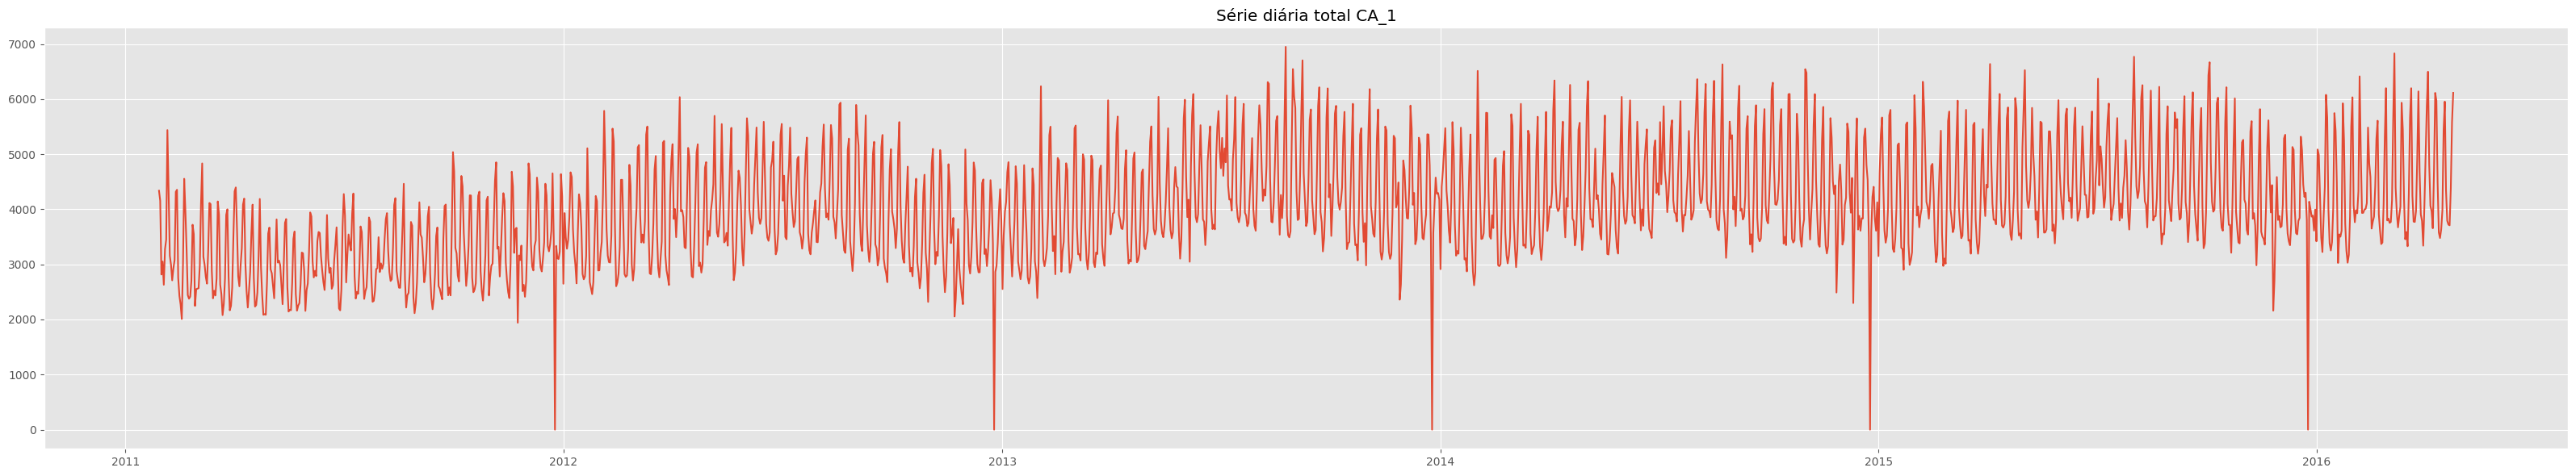

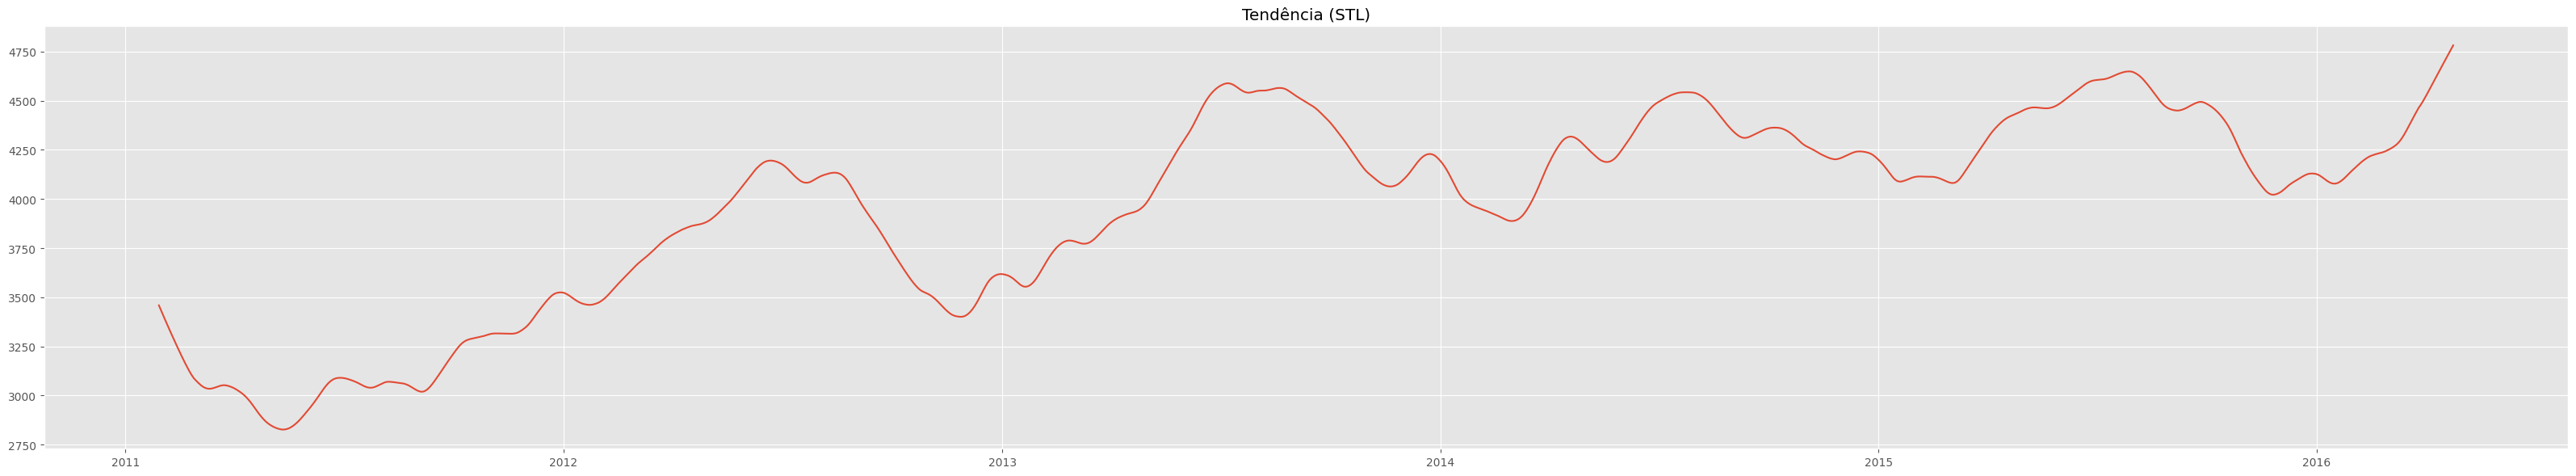

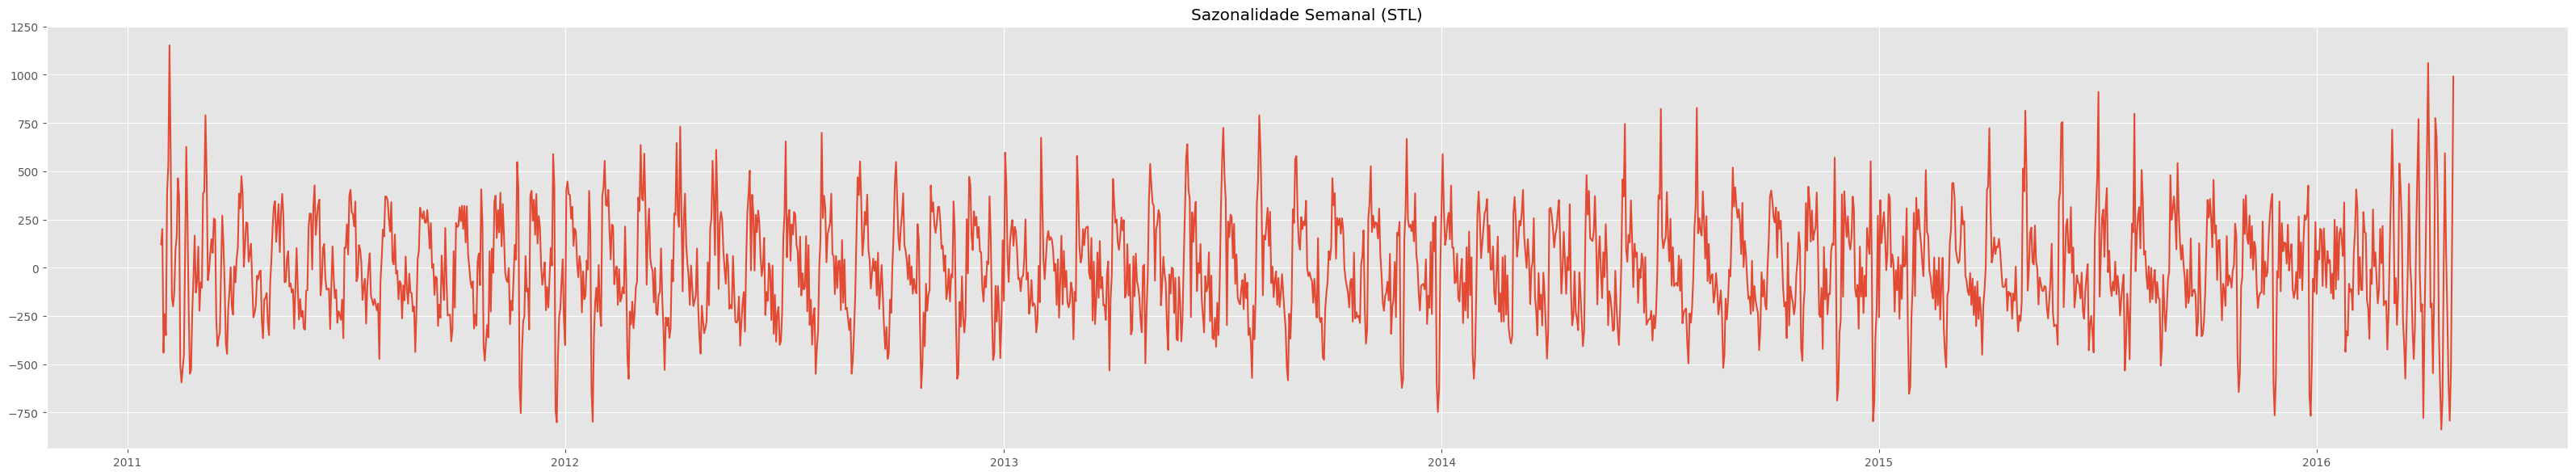

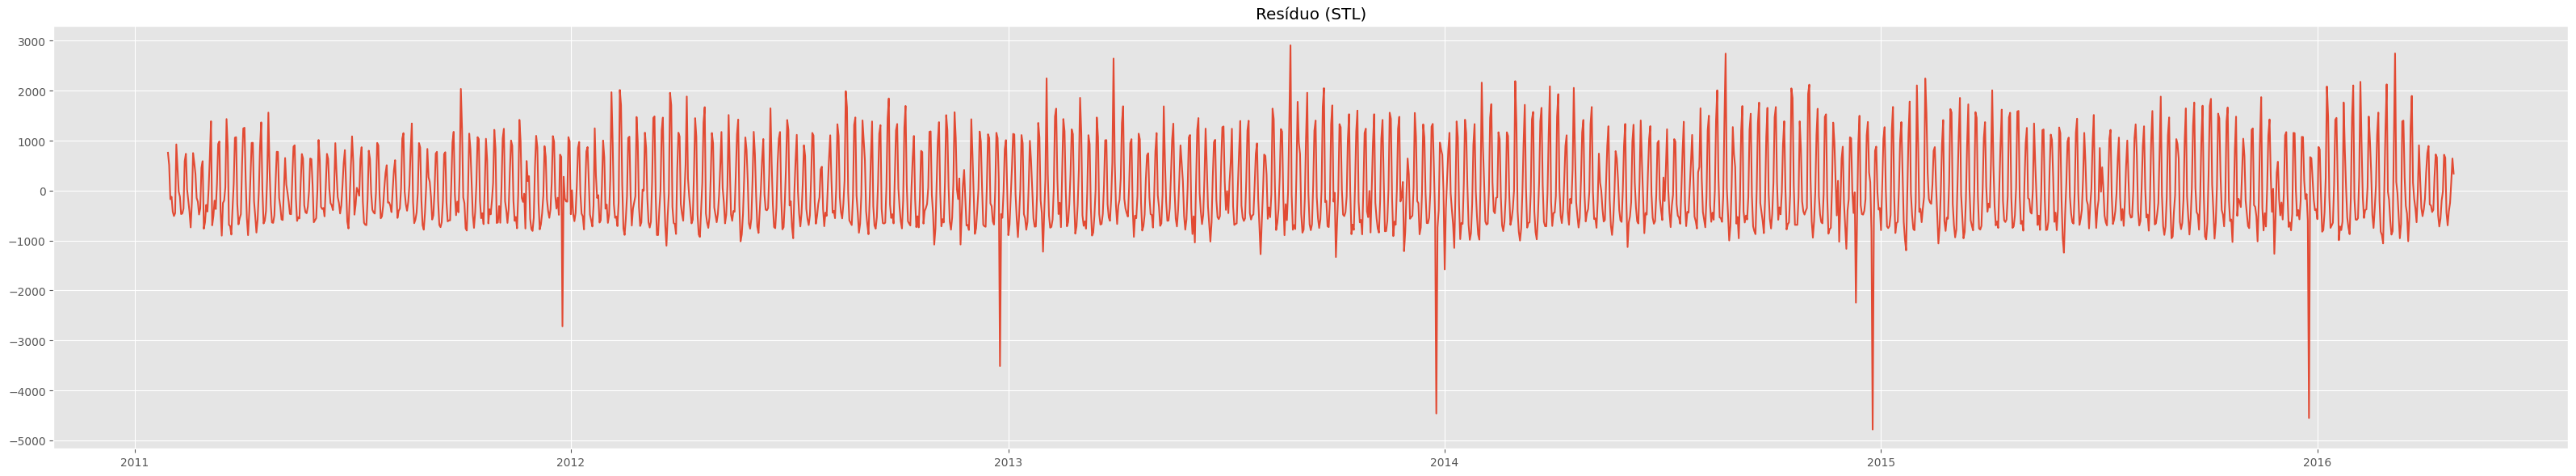

In [61]:
# Decomposição sazonal utilizando stl

print("\nExecutando decomposição STL (periodo=7)...")
stl = STL(y, period=30, robust=True).fit()
# Exibição simples (sem customização de cores)
plt.figure()
plt.plot(y.index, y.values)
plt.title("Série diária total CA_1")
plt.tight_layout(); plt.show()

plt.figure(); plt.plot(stl.trend.index, stl.trend.values); plt.title("Tendência (STL)"); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(stl.seasonal.index, stl.seasonal.values); plt.title("Sazonalidade Semanal (STL)"); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(stl.resid.index, stl.resid.values); plt.title("Resíduo (STL)"); plt.tight_layout(); plt.show()

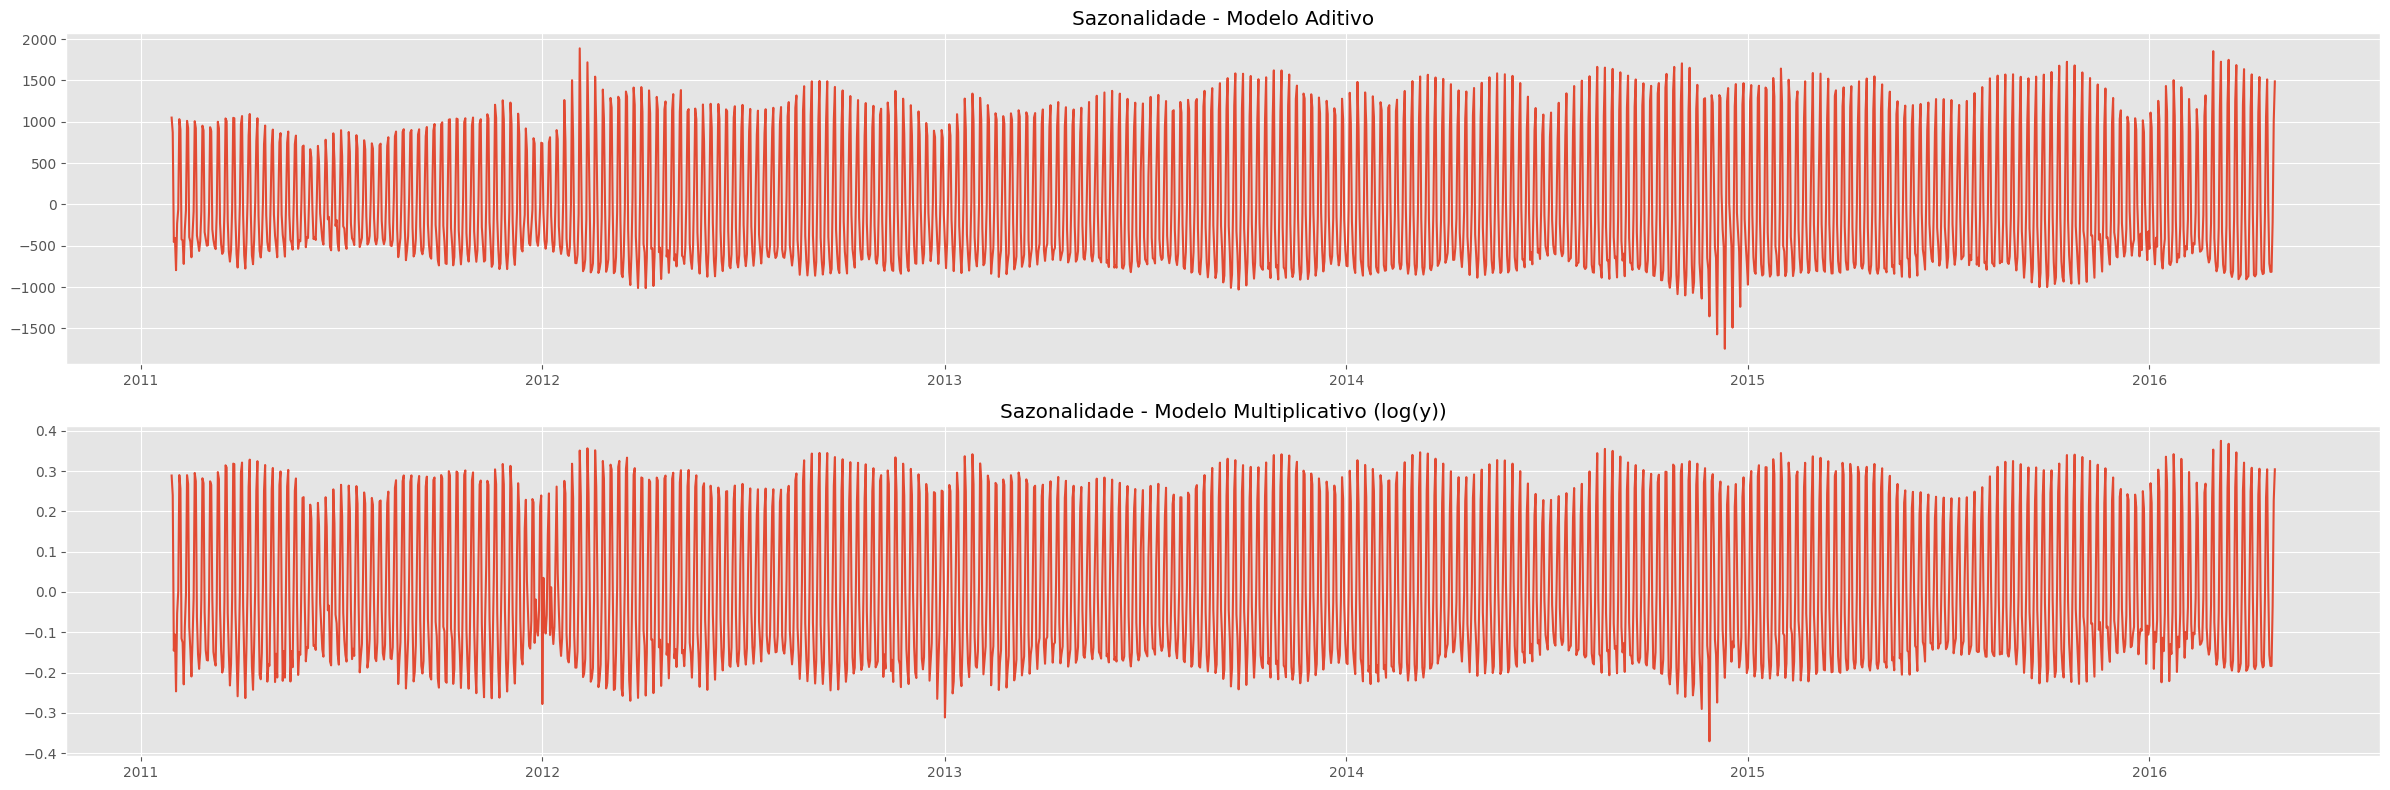

In [62]:
# Comparação: STL aditiva vs multiplicativa (log-transform)
stl_add = STL(y, period=7, robust=True).fit()
stl_mul = STL(np.log1p(y), period=7, robust=True).fit()

fig, axes = plt.subplots(2, 1, figsize=(24, 8))
axes[0].plot(stl_add.seasonal)
axes[0].set_title("Sazonalidade - Modelo Aditivo")
axes[1].plot(stl_mul.seasonal)
axes[1].set_title("Sazonalidade - Modelo Multiplicativo (log(y))")
plt.tight_layout()
plt.show()


<Axes: xlabel='weekday', ylabel='demand'>

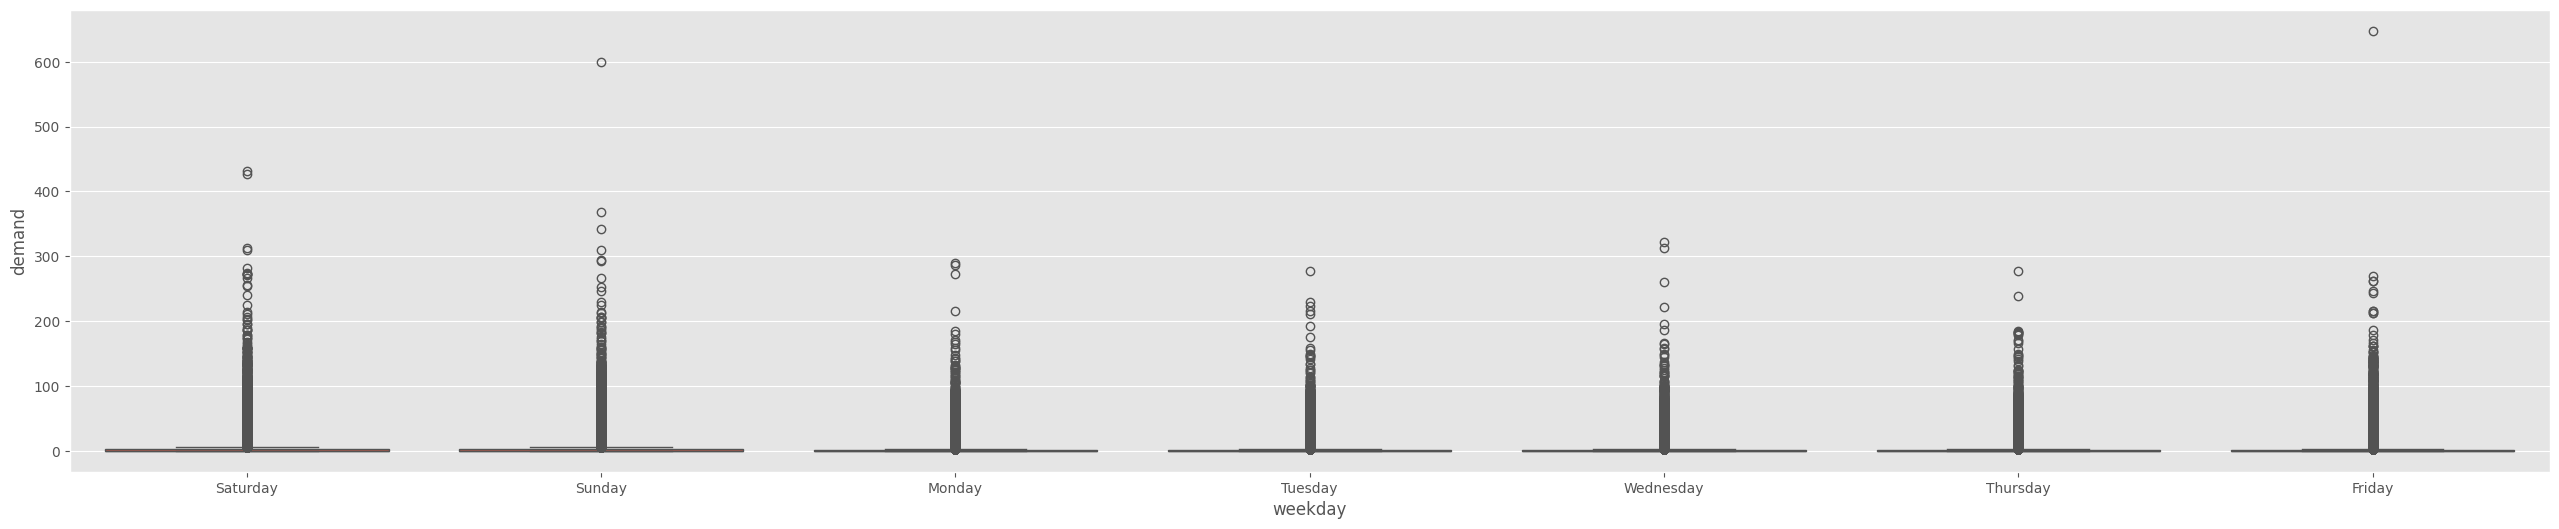

In [63]:
df_train['weekday'] = df_train['date'].dt.day_name()
sns.boxplot(x='weekday', y='demand', data=df_train)



=== Teste ADF (série diária) ===
Estatística ADF: -2.0354
p-valor: 0.2713


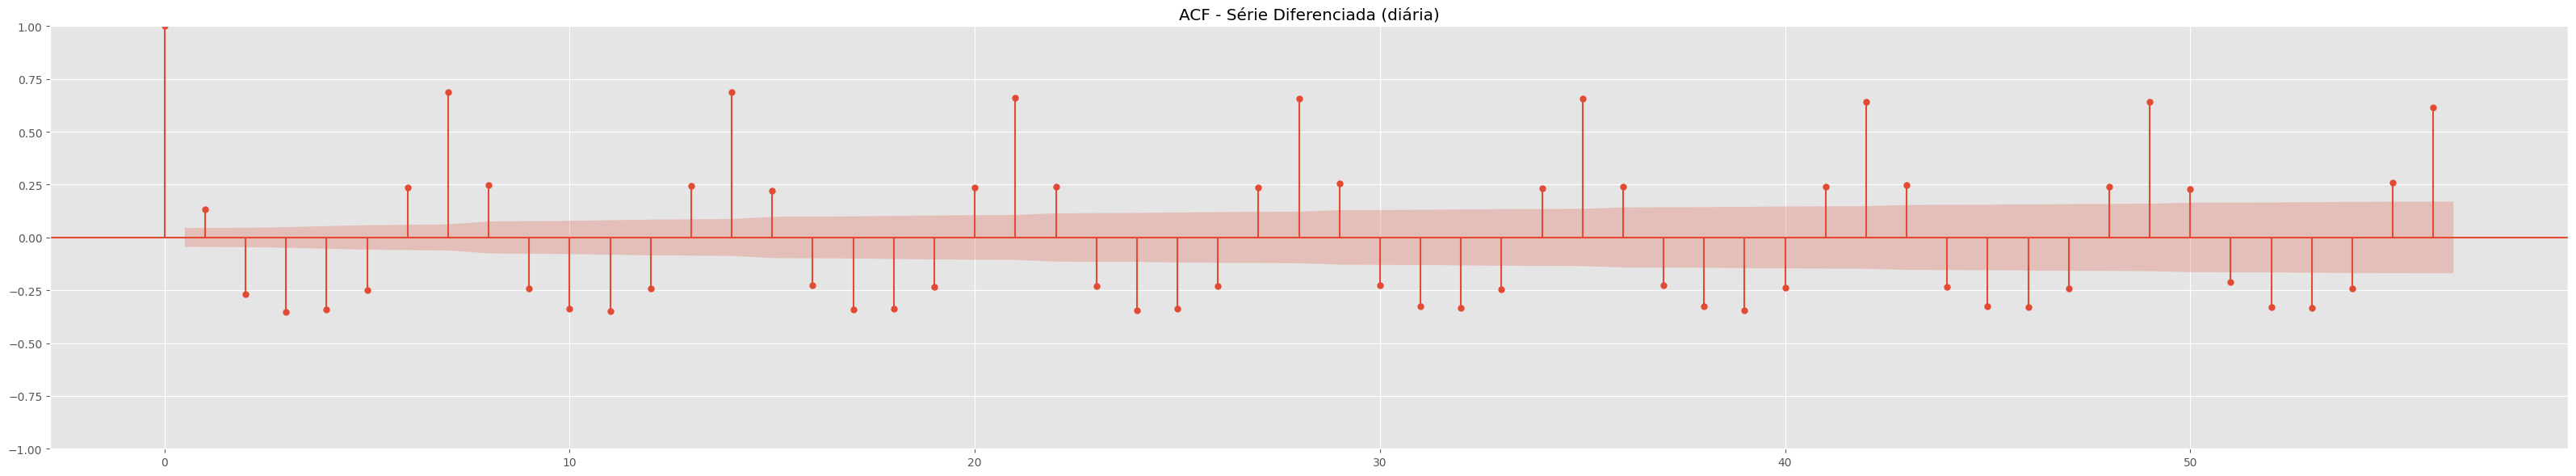

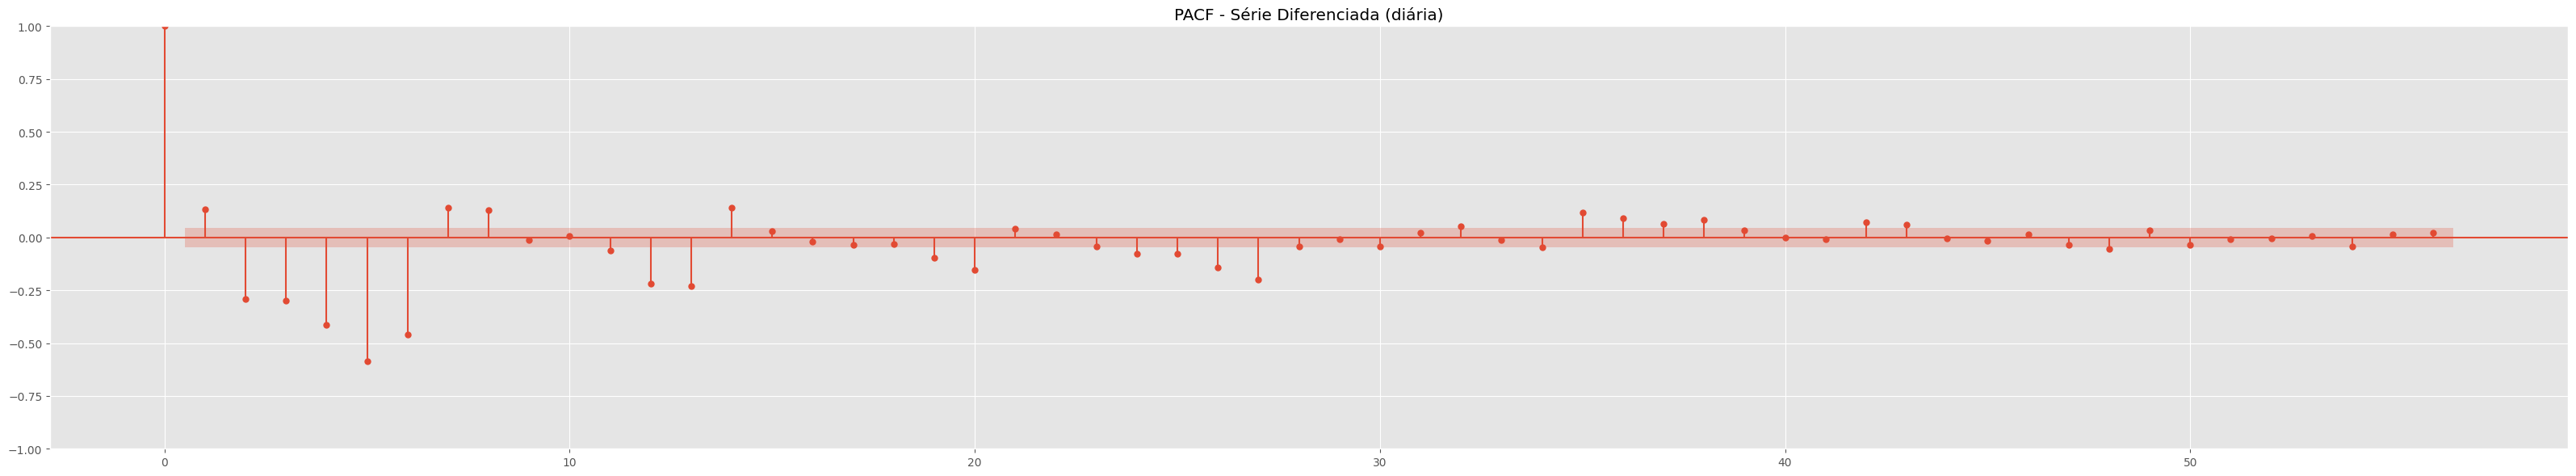

In [64]:
# 12) ACF/PACF e ADF na série diferenciada se necessário
# -------------------------
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(y.values, autolag="AIC")
print("\n=== Teste ADF (série diária) ===")
print(f"Estatística ADF: {resultado_adf[0]:.4f}")
print(f"p-valor: {resultado_adf[1]:.4f}")

# Exibir ACF/PACF da série diferenciada (para estacionariedade)
y_diff = y.diff().dropna()

fig = plot_acf(y_diff, lags=56)
plt.title("ACF - Série Diferenciada (diária)")
plt.tight_layout(); plt.show()

fig = plot_pacf(y_diff, lags=56, method="ywm")
plt.title("PACF - Série Diferenciada (diária)")
plt.tight_layout(); plt.show()

O p-valor (0.27) é maior que 0.05, portanto não rejeitamos a hipótese nula de que a série possui raiz unitária, isto é, não é estacionária.

Ou seja, existe tendência de longo prazo e sazonalidade na série de vendas agregadas da loja CA_1.

A série original não é estacionária. É recomendável aplicar uma diferença de primeira ordem (d = 1) e possivelmente uma diferença sazonal semanal (D = 1, s = 7) para torná-la estacionária.


O comportamento periódico da ACF confirma a presença de uma sazonalidade de 7 dias, compatível com o ciclo de vendas semanal do varejo.
A lenta atenuação da autocorrelação reforça a necessidade de diferenciação para remover a dependência temporal persistente.


A PACF indica que um modelo com pequeno número de termos autorregressivos pode capturar a dependência direta entre dias consecutivos de vendas.

SARIMA(p=1,d=1,q=1)×(P=1,D=1,Q=1,s=7)

In [65]:
# 1) Garantir que as séries têm índice diário (o SARIMA usa as datas)
y_train_sar = y_train.asfreq("D")
y_val_sar   = y_val.asfreq("D")

# 2) Definir e treinar o modelo
sarima = SARIMAX(
    y_train_sar,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
    initialization="approximate_diffuse",
)

modelo_sarima = sarima.fit(disp=False, maxiter=500)

# 3) Prever exatamente o horizonte da validação (F1–F28)
sarima_fc = modelo_sarima.forecast(steps=len(y_val_sar))
sarima_fc.index = y_val_sar.index  # garantir alinhamento de índice

# 4) Avaliar com a mesma função usada no Naive
modelo_nm = 'SARIMA(1,1,1)x(1,1,1,7)'
sarima_fc = modelo_sarima.forecast(steps=len(y_val))
results = avaliar_modelo(modelo_nm, sarima_fc, y_train, y_val, results, ultimos_pontos=500)

print(modelo_sarima.summary())



RESULTADOS ATUAIS:
Modelo: Naive           | RMSE: 966.632  | MAE: 862.750  | RMSSE: 1.116   
Modelo: SARIMA(1,1,1)x(1,1,1,7) | RMSE: 358.777  | MAE: 271.501  | RMSSE: 0.414   



                                     SARIMAX Results                                     
Dep. Variable:                            demand   No. Observations:                 1885
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -14139.243
Date:                           Sat, 01 Nov 2025   AIC                          28288.485
Time:                                   19:42:42   BIC                          28316.194
Sample:                               01-29-2011   HQIC                         28298.690
                                    - 03-27-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3492      0.015     24.060      0.000       0.321       0.378
ma.L1         -0.9601      0.008   -120.292

In [66]:

y_train_log = np.log1p(y_train_sar)
y_val_log   = np.log1p(y_val_sar)

sarima_log = SARIMAX(y_train_log, order=(1,1,1), seasonal_order=(1,1,1,7),
                     enforce_stationarity=False, enforce_invertibility=False,
                     initialization="approximate_diffuse").fit(disp=False)

sarima_log_fc = sarima_log.forecast(steps=len(y_val_log))
sarima_log_fc = np.expm1(sarima_log_fc)  # volta para a escala original
modelo_nm = 'SARIMA-log(1,1,1)x(1,1,1,7)'
results = avaliar_modelo(modelo_nm, sarima_log_fc, y_train, y_val, results, ultimos_pontos=500)


print(sarima_log.summary())




RESULTADOS ATUAIS:
Modelo: Naive           | RMSE: 966.632  | MAE: 862.750  | RMSSE: 1.116   
Modelo: SARIMA(1,1,1)x(1,1,1,7) | RMSE: 358.777  | MAE: 271.501  | RMSSE: 0.414   
Modelo: SARIMA-log(1,1,1)x(1,1,1,7) | RMSE: 419.712  | MAE: 334.058  | RMSSE: 0.485   



                                     SARIMAX Results                                     
Dep. Variable:                            demand   No. Observations:                 1885
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1218.202
Date:                           Sat, 01 Nov 2025   AIC                           2446.404
Time:                                   19:42:46   BIC                           2474.112
Sample:                               01-29-2011   HQIC                          2456.608
                                    - 03-27-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0326      0.027      1.198      0.231      -0.021       0.086
ma.L1         -1.0246      0.009   -119.305

Indicador	SARIMA normal	SARIMA (log(y))	Interpretação
AIC	28 288.485	2 446.404	Muito menor após o log (não é comparável diretamente pois a unidade mudou, mas indica convergência melhor)
BIC	28 316.194	2 474.112	Redução consistente — menor penalização


In [67]:
# --- Holt–Winters (Suavização Exponencial Tripla) - sazonalidade multiplicativa (s=7)
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# 1) Séries com frequência diária
y_train_hw = y_train.asfreq("D").copy()
y_val_hw   = y_val.asfreq("D").copy()

# 2) Salvaguarda: multiplicativo exige valores > 0 (agregado da loja costuma ser >0, mas vamos garantir)
if (y_train_hw <= 0).any() or (y_val_hw <= 0).any():
    eps = 1e-6
    y_train_hw = y_train_hw.clip(lower=eps)
    y_val_hw   = y_val_hw.clip(lower=eps)

# 3) Ajuste do HW multiplicativo
#    - trend='add' funciona bem para nível; você também pode testar trend='mul' se a tendência for claramente proporcional.
#    - damped_trend=True costuma estabilizar previsões mais longas.
hw_model = ExponentialSmoothing(
    y_train_hw,
    trend="add",
    damped_trend=True,          # experimente False se quiser comparar
    seasonal="mul",
    seasonal_periods=7,
    initialization_method="estimated"  # deixa o modelo estimar estados iniciais
).fit(optimized=True, use_brute=False)

# 4) Previsão no horizonte da validação
hw_fc = hw_model.forecast(len(y_val_hw))
hw_fc.index = y_val_hw.index

# 5) Avaliação com sua função (mostrando, por exemplo, os últimos 500 pontos)
modelo_nm = "Holt-Winters Multiplicativo (s=7, damped)"
results   = avaliar_modelo(modelo_nm, hw_fc, y_train_hw, y_val_hw, results, ultimos_pontos=500)

# (Opcional) ver sumário sucinto dos hiperparâmetros estimados
print("alpha:", getattr(hw_model, 'model', hw_model.model).params['smoothing_level'],
      "| beta:", getattr(hw_model, 'model', hw_model.model).params.get('smoothing_trend'),
      "| phi (damping):", getattr(hw_model, 'model', hw_model.model).params.get('damping_trend'),
      "| gamma:", getattr(hw_model, 'model', hw_model.model).params.get('smoothing_seasonal'))



RESULTADOS ATUAIS:
Modelo: Naive           | RMSE: 966.632  | MAE: 862.750  | RMSSE: 1.116   
Modelo: SARIMA(1,1,1)x(1,1,1,7) | RMSE: 358.777  | MAE: 271.501  | RMSSE: 0.414   
Modelo: SARIMA-log(1,1,1)x(1,1,1,7) | RMSE: 419.712  | MAE: 334.058  | RMSSE: 0.485   
Modelo: Holt-Winters Multiplicativo (s=7, damped) | RMSE: 318.607  | MAE: 252.901  | RMSSE: 0.368   



alpha: 0.18419827536259314 | beta: 0.0 | phi (damping): 0.9120441468356899 | gamma: 0.025142331699826295


In [68]:
print(df_train.columns)


Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'day',
       'demand', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'day_int'],
      dtype='object')


In [69]:
# ==========================================
# 1) Selecionar colunas relevantes (corrigido)
# ==========================================
exog_cols = [
    "date", "snap_CA",
    "event_name_1", "event_name_2",
    "weekday", "month", "year"
]

df_exog = df_train[exog_cols].copy()
df_exog["date"] = pd.to_datetime(df_exog["date"])
df_exog = df_exog.set_index("date").sort_index()
df_exog
# ==========================================
# 2) Remover duplicatas de data (agregação diária)
#    - snap_CA: max (se 1 em qualquer linha do dia, marca 1)
#    - weekday/month/year: primeiro (são constantes por data)
#    - eventos: primeiro não-nulo (aproximação segura)
# ==========================================
agg_dict = {}
if "snap_CA" in df_exog.columns: agg_dict["snap_CA"] = "max"
for c in ["weekday", "month", "year"]:
    if c in df_exog.columns: agg_dict[c] = "first"
for c in ["event_name_1", "event_name_2"]:
    if c in df_exog.columns: agg_dict[c] = "first"

if not df_exog.index.is_unique:
    df_exog = df_exog.groupby(level=0).agg(agg_dict)
df_exog
# ==========================================
# 3) Garantir índices e cortes de treino/validação
# ==========================================
y_train = y_train.copy(); y_val = y_val.copy()
y_train.index = pd.to_datetime(y_train.index)
y_val.index   = pd.to_datetime(y_val.index)
y_train = y_train.sort_index().asfreq("D")
y_val   = y_val.sort_index().asfreq("D")


idx_all = y_train.index.union(y_val.index)
df_exog = df_exog.reindex(idx_all)
df_exog

# ==========================================
# 4) Tratamento NA
# ==========================================
if "snap_CA" in df_exog.columns:
    df_exog["snap_CA"] = df_exog["snap_CA"].fillna(0)

for c in ["weekday", "month", "year"]:
    if c in df_exog.columns:
        df_exog[c] = df_exog[c].fillna(method="ffill").fillna(method="bfill")

for c in ["event_name_1", "event_name_2"]:
    if c in df_exog.columns:
        df_exog[c] = df_exog[c].astype("string").fillna("None")
df_exog
# ==========================================
# 5) Dummies de eventos sem vazamento (Top-K aprendido no TREINO)
# ==========================================
top_k = 20
if "event_name_1" in df_exog.columns:
    top_e1 = df_exog.loc[y_train.index, "event_name_1"].value_counts().head(top_k).index
    df_exog["event_name_1_top"] = np.where(df_exog["event_name_1"].isin(top_e1), df_exog["event_name_1"], "Outros")
else:
    df_exog["event_name_1_top"] = "None"

if "event_name_2" in df_exog.columns:
    top_e2 = df_exog.loc[y_train.index, "event_name_2"].value_counts().head(top_k).index
    df_exog["event_name_2_top"] = np.where(df_exog["event_name_2"].isin(top_e2), df_exog["event_name_2"], "Outros")
else:
    df_exog["event_name_2_top"] = "None"

# Dummies de eventos + calendário
cols_cat = []
for c in ["event_name_1_top", "event_name_2_top", "weekday", "month"]:
    if c in df_exog.columns:
        cols_cat.append(c)

df_exog = pd.get_dummies(df_exog, columns=cols_cat, drop_first=True)

# Garantir numérico e zerar remanescentes
df_exog = df_exog.apply(pd.to_numeric, errors="coerce").fillna(0)

# ==========================================
# 6) Split TREINO/VAL e sanidade de alinhamento
# ==========================================
X_train = df_exog.loc[y_train.index].copy()
X_val   = df_exog.loc[y_val.index].copy()
X_val   = X_val.reindex(columns=X_train.columns, fill_value=0)

print("🔎 Formatos exógenas:", X_train.shape, "|", X_val.shape)
print("🔎 Checagem de NaNs em X_train:", int(X_train.isna().sum().sum()))
print("🔎 Checagem de NaNs em X_val:",   int(X_val.isna().sum().sum()))

# ==========================================
# 7) Ajuste do SARIMAX com exógenas
#    (usar snap_CA + dummies de eventos; weekday/month já dummificados)
# ==========================================
cols_exog = []
if "snap_CA" in X_train.columns:
    cols_exog.append("snap_CA")
cols_exog += [c for c in X_train.columns if c.startswith("event_name_1_top_") or c.startswith("event_name_2_top_")]
# (Opcional) incluir dummies de weekday/month:
# cols_exog += [c for c in X_train.columns if c.startswith("weekday_") or c.startswith("month_")]

print("📊 Exógenas usadas:", cols_exog[:10], "... total:", len(cols_exog))

# ==================== checagem do formato das columas (ANTES DO SARIMAX) ====================
def _print_dtypes_info(y_tr, X_tr, cols_exog):
    print("\n🧪 Checando dtypes:")
    print("y_train dtype:", y_tr.dtype)
    dts = X_tr[cols_exog].dtypes.value_counts()
    print("X_train[exog] dtypes:\n", dts)
    bad_cols = [c for c in cols_exog if X_tr[c].dtype == 'object']
    if bad_cols:
        print("⚠️ Colunas object em X_train[exog]:", bad_cols)

# 1) Garantir numérico nas exógenas selecionadas
X_train[cols_exog] = X_train[cols_exog].apply(pd.to_numeric, errors='coerce')
X_val[cols_exog]   = X_val[cols_exog].apply(pd.to_numeric, errors='coerce')

# 2) Converter tudo para float64 (evita 'object', 'bool', 'Int64' etc.)
X_train[cols_exog] = X_train[cols_exog].astype('float64')
X_val[cols_exog]   = X_val[cols_exog].astype('float64')
y_train            = y_train.astype('float64')  # endógena também em float
y_val              = y_val.astype('float64')

# 3) Garantir ausência de NaN após coerção
nan_tr = int(X_train[cols_exog].isna().sum().sum())
nan_vl = int(X_val[cols_exog].isna().sum().sum())
if nan_tr or nan_vl:
    print(f"⚠️ NaNs após coerção -> treino: {nan_tr}, val: {nan_vl}. Preenchendo com 0.")
    X_train[cols_exog] = X_train[cols_exog].fillna(0.0)
    X_val[cols_exog]   = X_val[cols_exog].fillna(0.0)

# 4) Validações finais
_print_dtypes_info(y_train, X_train, cols_exog)
print("Shapes finais:", y_train.shape, X_train[cols_exog].shape, "|", y_val.shape, X_val[cols_exog].shape)
# ================================================================================

# Agora sim: ajuste do modelo
sarimax_exog = SARIMAX(
    y_train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    exog=X_train[cols_exog],
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False, maxiter=500)

sarimax_fc = sarimax_exog.forecast(steps=len(y_val), exog=X_val[cols_exog])
sarimax_fc.index = y_val.index

modelo_nm = "SARIMAX(1,1,1)x(1,1,1,7) + exógenas"
results = avaliar_modelo(modelo_nm, sarimax_fc, y_train, y_val, results, ultimos_pontos=500)

print(sarimax_exog.summary())


🔎 Formatos exógenas: (1885, 45) | (28, 45)
🔎 Checagem de NaNs em X_train: 0
🔎 Checagem de NaNs em X_val: 0
📊 Exógenas usadas: ['snap_CA', 'event_name_1_top_Easter', 'event_name_1_top_Eid al-Fitr', 'event_name_1_top_IndependenceDay', 'event_name_1_top_LentStart', 'event_name_1_top_LentWeek2', 'event_name_1_top_MartinLutherKingDay', 'event_name_1_top_MemorialDay', "event_name_1_top_Mother's day", 'event_name_1_top_NBAFinalsEnd'] ... total: 25

🧪 Checando dtypes:
y_train dtype: float64
X_train[exog] dtypes:
 float64    25
Name: count, dtype: int64
Shapes finais: (1885,) (1885, 25) | (28,) (28, 25)

RESULTADOS ATUAIS:
Modelo: Naive           | RMSE: 966.632  | MAE: 862.750  | RMSSE: 1.116   
Modelo: SARIMA(1,1,1)x(1,1,1,7) | RMSE: 358.777  | MAE: 271.501  | RMSSE: 0.414   
Modelo: SARIMA-log(1,1,1)x(1,1,1,7) | RMSE: 419.712  | MAE: 334.058  | RMSSE: 0.485   
Modelo: Holt-Winters Multiplicativo (s=7, damped) | RMSE: 318.607  | MAE: 252.901  | RMSSE: 0.368   
Modelo: SARIMAX(1,1,1)x(1,1,1,7)

                                     SARIMAX Results                                     
Dep. Variable:                            demand   No. Observations:                 1885
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -13801.100
Date:                           Sat, 01 Nov 2025   AIC                          27662.201
Time:                                   19:43:37   BIC                          27828.179
Sample:                               01-29-2011   HQIC                         27723.355
                                    - 03-27-2016                                         
Covariance Type:                             opg                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
snap_CA                                288.1995     25.617     11.250 

✅ Dados Prophet preparados:
(1885, 27) treino  | (28, 27) validação
Exógenas: ['snap_CA', 'event_name_1_top_Easter', 'event_name_1_top_Eid al-Fitr', 'event_name_1_top_IndependenceDay', 'event_name_1_top_LentStart', 'event_name_1_top_LentWeek2', 'event_name_1_top_MartinLutherKingDay', 'event_name_1_top_MemorialDay', "event_name_1_top_Mother's day", 'event_name_1_top_NBAFinalsEnd'] ... total: 25


DEBUG:cmdstanpy:input tempfile: /tmp/tmps_gdvrcj/dy35_6ib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps_gdvrcj/sqggxxgo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87361', 'data', 'file=/tmp/tmps_gdvrcj/dy35_6ib.json', 'init=/tmp/tmps_gdvrcj/sqggxxgo.json', 'output', 'file=/tmp/tmps_gdvrcj/prophet_modelpo9vu1bv/prophet_model-20251101194338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



RESULTADOS ATUAIS:
Modelo: Naive           | RMSE: 966.632  | MAE: 862.750  | RMSSE: 1.116   
Modelo: SARIMA(1,1,1)x(1,1,1,7) | RMSE: 358.777  | MAE: 271.501  | RMSSE: 0.414   
Modelo: SARIMA-log(1,1,1)x(1,1,1,7) | RMSE: 419.712  | MAE: 334.058  | RMSSE: 0.485   
Modelo: Holt-Winters Multiplicativo (s=7, damped) | RMSE: 318.607  | MAE: 252.901  | RMSSE: 0.368   
Modelo: SARIMAX(1,1,1)x(1,1,1,7) + exógenas (sanitizado) | RMSE: 235.771  | MAE: 196.743  | RMSSE: 0.272   
Modelo: Prophet (multiplicativo + regressoras) | RMSE: 242.754  | MAE: 191.847  | RMSSE: 0.280   



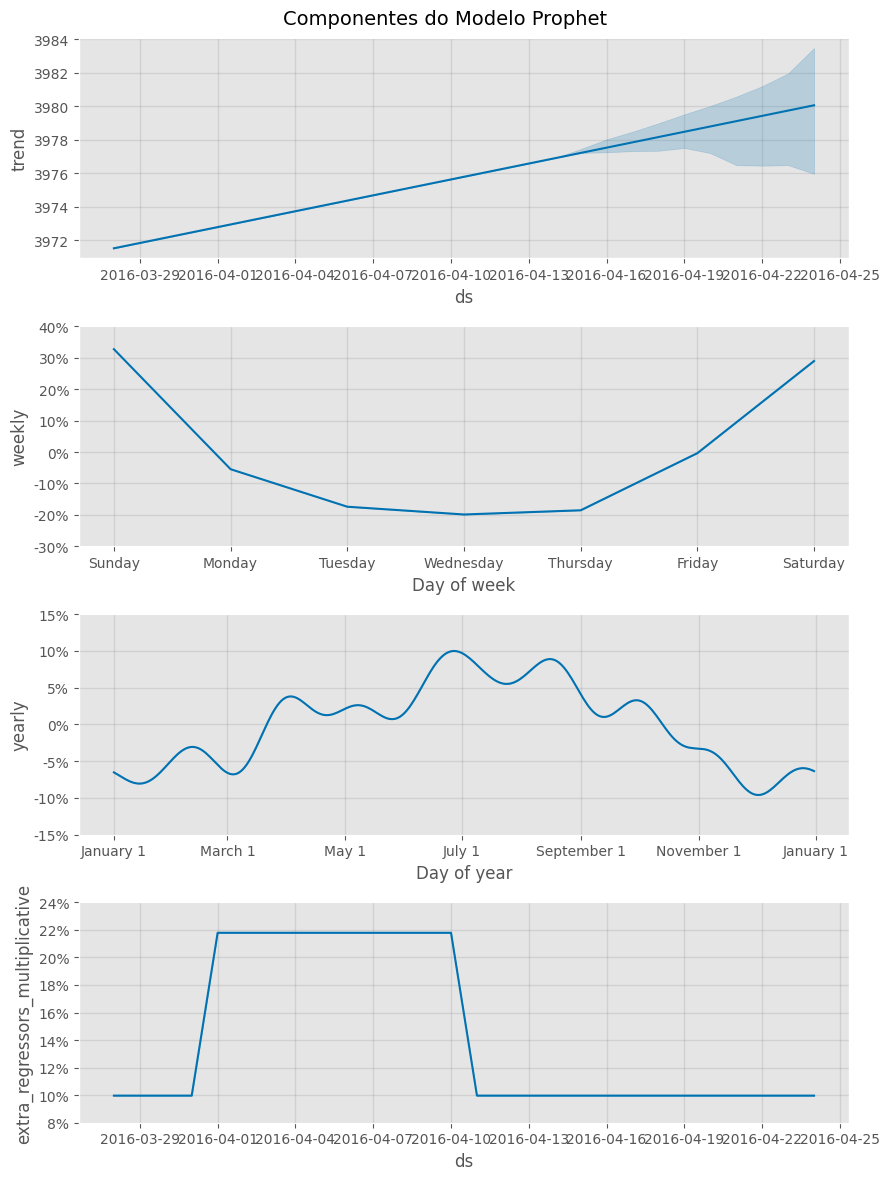

In [70]:
# ==========================================================
# MODELO PROPHET COM VARIÁVEIS EXÓGENAS (snap_CA + eventos)
# ==========================================================
from prophet import Prophet

# 1) Preparar série de treino/validação no formato Prophet
y_train_prophet = y_train.reset_index().rename(columns={"date": "ds", "demand": "y"})
y_val_prophet   = y_val.reset_index().rename(columns={"date": "ds", "demand": "y"})

# Prophet exige colunas "ds" (datas) e "y" (valores)
# Se o seu y_train não tiver coluna "demand", ajuste para o nome correto

# 2) Garantir valores positivos (Prophet usa log internamente para componentes multiplicativos)
if (y_train_prophet["y"] <= 0).any() or (y_val_prophet["y"] <= 0).any():
    eps = 1e-6
    y_train_prophet["y"] = y_train_prophet["y"].clip(lower=eps)
    y_val_prophet["y"]   = y_val_prophet["y"].clip(lower=eps)

# 3) Unir exógenas (já limpas e dummificadas)
#    - Usaremos snap_CA e dummies de eventos
exog_cols_prophet = ["snap_CA"] + [
    c for c in X_train.columns
    if c.startswith("event_name_1_top_") or c.startswith("event_name_2_top_")
]

# Garantir índices e mesclar pelas datas (ds)
df_train_prophet = y_train_prophet.merge(
    X_train[exog_cols_prophet].reset_index().rename(columns={"date": "ds"}),
    on="ds", how="left"
)
df_val_prophet = y_val_prophet.merge(
    X_val[exog_cols_prophet].reset_index().rename(columns={"date": "ds"}),
    on="ds", how="left"
)

print("✅ Dados Prophet preparados:")
print(df_train_prophet.shape, "treino  |", df_val_prophet.shape, "validação")
print("Exógenas:", exog_cols_prophet[:10], "... total:", len(exog_cols_prophet))

# 4) Configurar e ajustar o modelo Prophet
#    - yearly_seasonality, weekly_seasonality automáticos
#    - multiplicative seasonality ajuda se a amplitude crescer com o nível da série
m = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.5  # controla flexibilidade da tendência
)

# Adicionar as exógenas como regressoras
for col in exog_cols_prophet:
    m.add_regressor(col)

# Ajustar o modelo
m.fit(df_train_prophet)

# 5) Previsão para o horizonte da validação
future = df_val_prophet[["ds"] + exog_cols_prophet].copy()
forecast = m.predict(future)

# 6) Converter previsão para série
prophet_fc = forecast[["ds", "yhat"]].set_index("ds")["yhat"]
prophet_fc.index = pd.to_datetime(prophet_fc.index)
prophet_fc = prophet_fc.reindex(y_val.index)

# 7) Avaliar desempenho no padrão
modelo_nm = "Prophet (multiplicativo + regressoras)"
results = avaliar_modelo(modelo_nm, prophet_fc, y_train, y_val, results, ultimos_pontos=500)

# 8) Exibir componentes principais do modelo
m.plot_components(forecast)
plt.suptitle("Componentes do Modelo Prophet", fontsize=14)
plt.tight_layout()
plt.show()


✅ Dimensões: (1885, 45) treino | (28, 45) validação
[0]	train-rmse:964.41371	val-rmse:1081.36138
[100]	train-rmse:323.95827	val-rmse:284.14427
[200]	train-rmse:284.00252	val-rmse:277.57667
[245]	train-rmse:274.20171	val-rmse:285.70824

RESULTADOS ATUAIS:
Modelo: Naive           | RMSE: 966.632  | MAE: 862.750  | RMSSE: 1.116   
Modelo: SARIMA(1,1,1)x(1,1,1,7) | RMSE: 358.777  | MAE: 271.501  | RMSSE: 0.414   
Modelo: SARIMA-log(1,1,1)x(1,1,1,7) | RMSE: 419.712  | MAE: 334.058  | RMSSE: 0.485   
Modelo: Holt-Winters Multiplicativo (s=7, damped) | RMSE: 318.607  | MAE: 252.901  | RMSSE: 0.368   
Modelo: SARIMAX(1,1,1)x(1,1,1,7) + exógenas (sanitizado) | RMSE: 235.771  | MAE: 196.743  | RMSSE: 0.272   
Modelo: Prophet (multiplicativo + regressoras) | RMSE: 242.754  | MAE: 191.847  | RMSSE: 0.280   
Modelo: XGBoost (árvore de regressão com exógenas) | RMSE: 286.054  | MAE: 241.440  | RMSSE: 0.330   



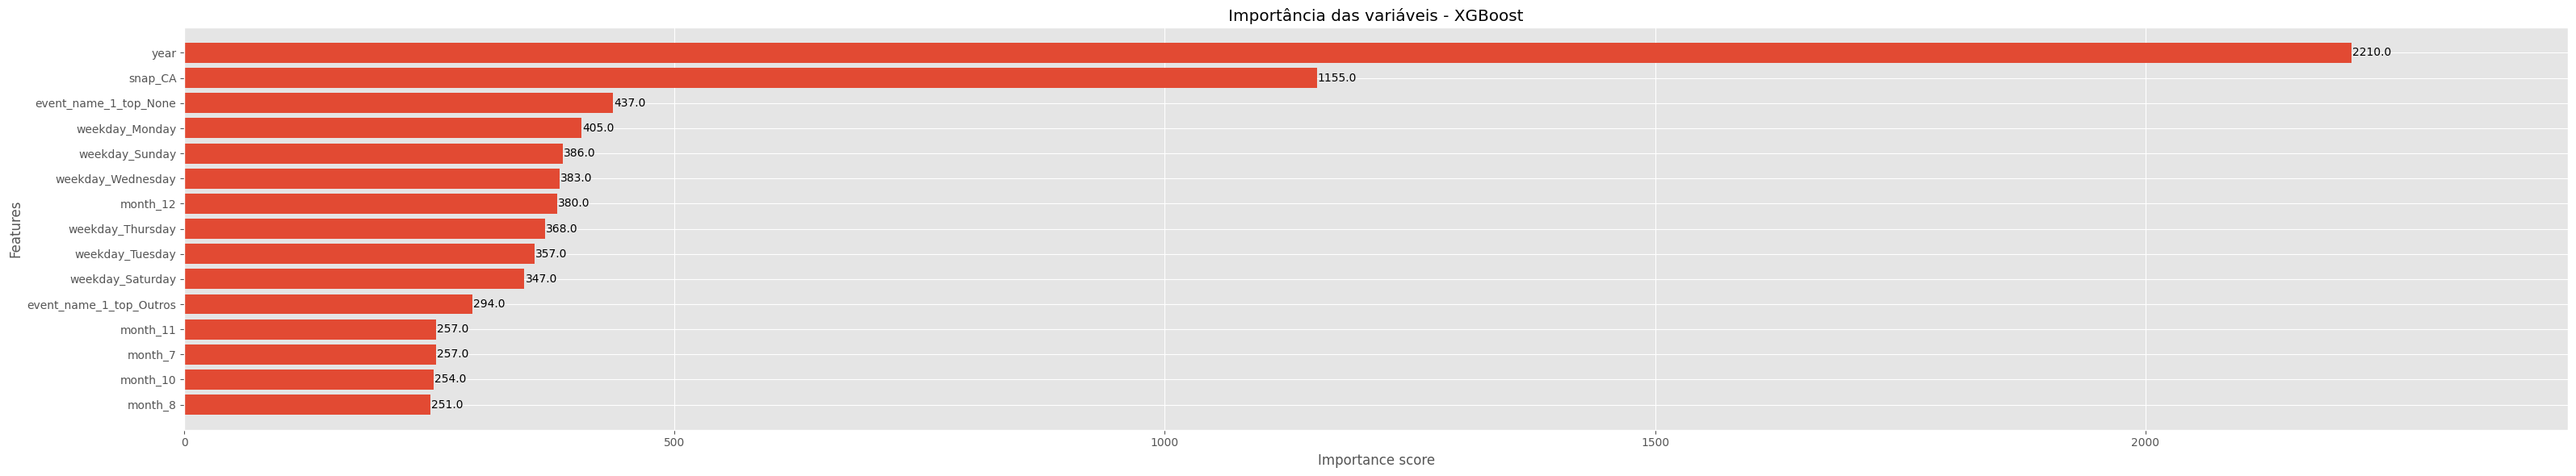


Resumo das métricas XGBoost:
{'modelo': 'XGBoost (árvore de regressão com exógenas)', 'RMSE': 286.05370491119385, 'MAE': 241.44002859933036, 'RMSSE': 0.3302686094485648}


In [71]:
# ==========================================================
# MODELO XGBOOST PARA PREVISÃO DE DEMANDA (COM EXÓGENAS)
# ==========================================================


# ==========================================================
# 1) Preparar dados de treino e validação
# ==========================================================
# Série com frequência diária
y_train_xgb = y_train.asfreq("D").copy()
y_val_xgb   = y_val.asfreq("D").copy()

# Garante que o target esteja como array 1D float64
y_train_xgb = y_train_xgb.astype(float).values.ravel()
y_val_xgb   = y_val_xgb.astype(float).values.ravel()

# ==========================================================
# 2) Selecionar variáveis exógenas já tratadas (de df_exog)
# ==========================================================
X_train_xgb = X_train.copy()
X_val_xgb   = X_val.copy()

# Padronização: importante para modelos baseados em árvores com regressoras muito heterogêneas
scaler_xgb = StandardScaler()
X_train_xgb = pd.DataFrame(scaler_xgb.fit_transform(X_train_xgb), index=X_train.index, columns=X_train.columns)
X_val_xgb   = pd.DataFrame(scaler_xgb.transform(X_val_xgb), index=X_val.index, columns=X_val.columns)

print("✅ Dimensões:", X_train_xgb.shape, "treino |", X_val_xgb.shape, "validação")

# ==========================================================
# 3) Criar matrizes DMatrix do XGBoost (formato nativo)
# ==========================================================
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dval   = xgb.DMatrix(X_val_xgb,   label=y_val_xgb)

# ==========================================================
# 4) Hiperparâmetros base (inspirados em boas práticas Kaggle M5)
# ==========================================================
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05,              # taxa de aprendizado
    "max_depth": 6,           # profundidade das árvores
    "subsample": 0.8,         # fração das amostras usadas em cada árvore
    "colsample_bytree": 0.8,  # fração de features por árvore
    "lambda": 1.0,            # regularização L2
    "alpha": 0.3,             # regularização L1
    "seed": 42,
    "nthread": -1
}

# ==========================================================
# 5) Treinamento com early stopping
# ==========================================================
evals = [(dtrain, "train"), (dval, "val")]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=100,
    verbose_eval=100
)

# ==========================================================
# 6) Previsão e avaliação
# ==========================================================
xgb_fc = xgb_model.predict(dval)
xgb_fc = pd.Series(xgb_fc, index=y_val.index, name="forecast")

modelo_nm = "XGBoost (árvore de regressão com exógenas)"
results = avaliar_modelo(modelo_nm, xgb_fc, pd.Series(y_train_xgb, index=y_train.index), pd.Series(y_val_xgb, index=y_val.index), results, ultimos_pontos=500)

# ==========================================================
# 7) Importância das variáveis (feature importance)
# ==========================================================
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model, max_num_features=15, height=0.8)
plt.title("Importância das variáveis - XGBoost")
plt.tight_layout()
plt.show()

# ==========================================================
# 8) Sumário rápido das métricas
# ==========================================================
print("\nResumo das métricas XGBoost:")
print(results[-1])


✅ Dimensões: (1885, 45) treino | (28, 45) validação
Training until validation scores don't improve for 200 rounds
[200]	train's rmse: 379.559	val's rmse: 252.856
[400]	train's rmse: 352.075	val's rmse: 247.301
[600]	train's rmse: 337.835	val's rmse: 248.424
Early stopping, best iteration is:
[459]	train's rmse: 346.957	val's rmse: 245.744

RESULTADOS ATUAIS:
Modelo: Naive           | RMSE: 966.632  | MAE: 862.750  | RMSSE: 1.116   
Modelo: Naive (Walk-Forward • último fold) | RMSE: 992.280  | MAE: 782.786  | RMSSE: 1.078   
Modelo: Naive (Walk-Forward • média folds) | RMSE: 1012.144 | MAE: 777.276  | RMSSE: 1.153   
Modelo: Naive (Walk-Forward • último fold) | RMSE: 992.280  | MAE: 782.786  | RMSSE: 1.078   
Modelo: Naive (Walk-Forward • último fold) | RMSE: 992.280  | MAE: 782.786  | RMSSE: 1.078   
Modelo: SARIMA(1,1,1)x(1,1,1,7) • Walk-Forward (último fold) | RMSE: 433.856  | MAE: 346.772  | RMSSE: 0.472   
Modelo: SARIMA(1,1,1)x(1,1,1,7) • Walk-Forward (média folds) | RMSE: 465.776

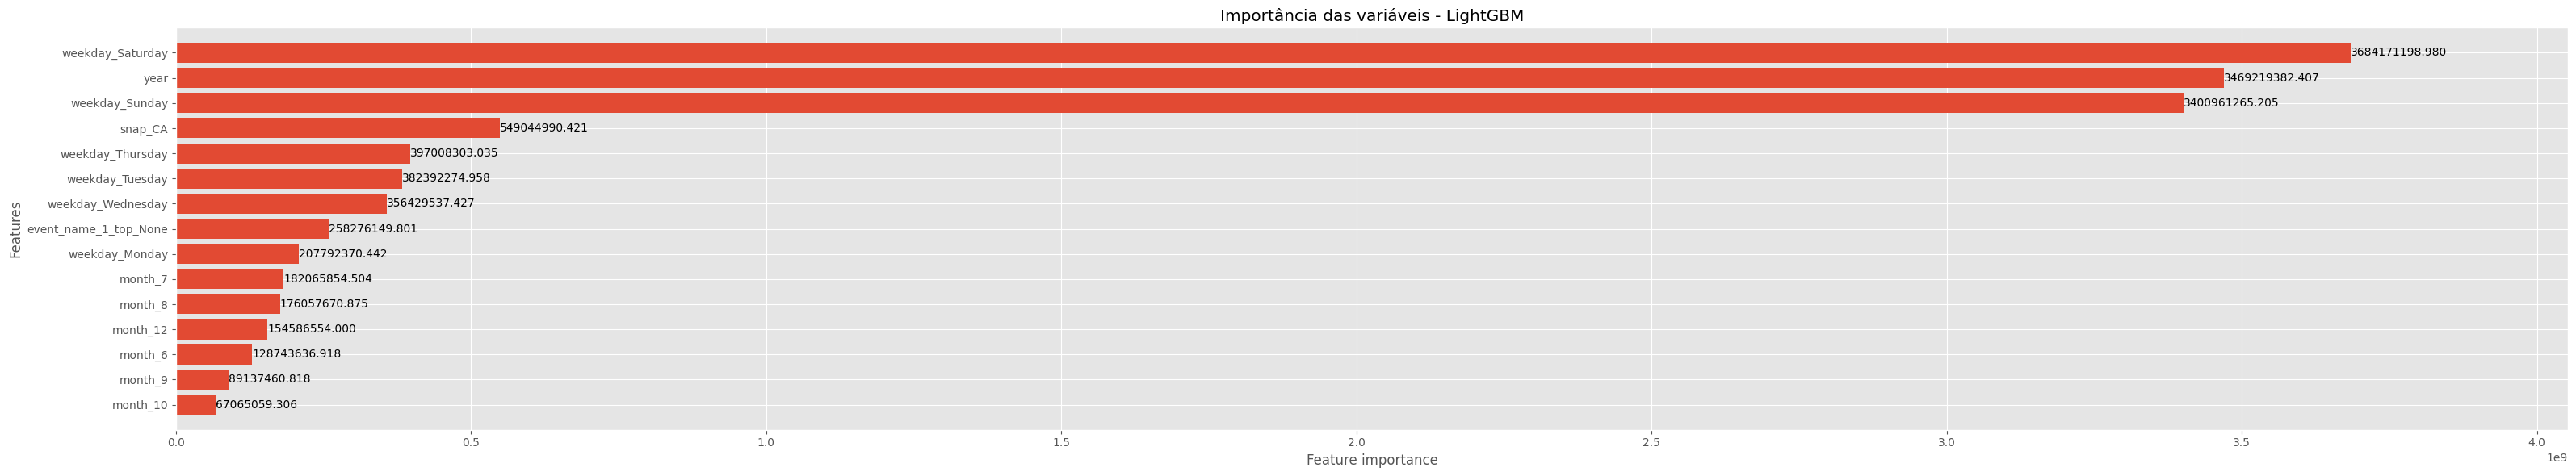


Resumo das métricas LightGBM:
{'modelo': 'LightGBM (árvore de decisão com exógenas)', 'RMSE': 245.74386540357733, 'MAE': 200.81516172100547, 'RMSSE': 0.2837281367586256}


In [103]:
# ==========================================================
# MODELO LIGHTGBM PARA PREVISÃO DE DEMANDA (COM EXÓGENAS)
# ==========================================================



# ==========================================================
# 1) Preparar dados de treino e validação
# ==========================================================
# Série com frequência diária
y_train_lgb = y_train.asfreq("D").copy()
y_val_lgb   = y_val.asfreq("D").copy()

# Garantir 1D float
y_train_lgb = y_train_lgb.astype(float).values.ravel()
y_val_lgb   = y_val_lgb.astype(float).values.ravel()

# ==========================================================
# 2) Selecionar variáveis exógenas já tratadas (de df_exog)
#    (sem padronização, pois LightGBM é baseado em árvore)
# ==========================================================
X_train_lgb = X_train.copy()
X_val_lgb   = X_val.copy()

# (Opcional) indicar colunas categóricas se você as tiver como 'category' ou 'object'
# Isso costuma ajudar bastante no LGBM.
cat_cols = [c for c in X_train_lgb.columns
            if str(X_train_lgb[c].dtype) in ("category", "object")]
# Se houver 'object', é melhor converter para 'category'
for c in cat_cols:
    if str(X_train_lgb[c].dtype) == "object":
        X_train_lgb[c] = X_train_lgb[c].astype("category")
        X_val_lgb[c]   = X_val_lgb[c].astype("category")

print("✅ Dimensões:", X_train_lgb.shape, "treino |", X_val_lgb.shape, "validação")

# ==========================================================
# 3) Conjuntos do LightGBM (Dataset nativo)
# ==========================================================
dtrain = lgb.Dataset(
    X_train_lgb,
    label=y_train_lgb,
    categorical_feature=cat_cols if len(cat_cols) > 0 else None,
    free_raw_data=False
)
dval = lgb.Dataset(
    X_val_lgb,
    label=y_val_lgb,
    categorical_feature=cat_cols if len(cat_cols) > 0 else None,
    reference=dtrain,
    free_raw_data=False
)

# ==========================================================
# 4) Hiperparâmetros base (inspirados em práticas do M5)
# ==========================================================
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 64,          # complexidade da árvore (ajuste fino com min_data_in_leaf)
    "feature_fraction": 0.8,   # amostra de features por iteração
    "bagging_fraction": 0.8,   # amostra de linhas por iteração
    "bagging_freq": 1,         # frequência do bagging
    "min_data_in_leaf": 50,    # tamanho mínimo do nó folha
    "lambda_l2": 1.0,          # regularização L2
    "lambda_l1": 0.3,          # regularização L1
    "max_depth": -1,           # sem limite; use se houver overfitting
    "seed": 42,
    "verbose": -1
    # Se tiver GPU:
    # "device_type": "gpu"
}

# ==========================================================
# 5) Treinamento com early stopping (versão compatível)
# ==========================================================
lgb_model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=5000,
    valid_sets=[dtrain, dval],
    valid_names=["train", "val"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=200)
    ]
)


# ==========================================================
# 6) Previsão e avaliação
# ==========================================================
lgb_fc = lgb_model.predict(X_val_lgb, num_iteration=lgb_model.best_iteration)
lgb_fc = pd.Series(lgb_fc, index=y_val.index, name="forecast")

modelo_nm = "LightGBM (árvore de decisão com exógenas)"
results = avaliar_modelo(
    modelo_nm,
    lgb_fc,
    pd.Series(y_train_lgb, index=y_train.index),
    pd.Series(y_val_lgb, index=y_val.index),
    results,
    ultimos_pontos=500
)

# ==========================================================
# 7) Importância das variáveis (feature importance)
# ==========================================================
ax = lgb.plot_importance(lgb_model, max_num_features=15, importance_type="gain", height=0.8)
plt.title("Importância das variáveis - LightGBM")
plt.tight_layout()
plt.show()

# ==========================================================
# 8) Sumário rápido das métricas
# ==========================================================
print("\nResumo das métricas LightGBM:")
print(results[-1])


✅ Dimensões: (1885, 45) treino | (28, 45) validação
0:	learn: 969.7319803	test: 1086.4261913	best: 1086.4261913 (0)	total: 47.2ms	remaining: 2m 21s
200:	learn: 359.7984479	test: 307.5969843	best: 307.2275022 (197)	total: 227ms	remaining: 3.16s
400:	learn: 314.5255107	test: 272.6014220	best: 268.5113187 (344)	total: 400ms	remaining: 2.59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 268.5113187
bestIteration = 344

Shrink model to first 345 iterations.

RESULTADOS ATUAIS:
Modelo: Naive           | RMSE: 966.632  | MAE: 862.750  | RMSSE: 1.116   
Modelo: SARIMA(1,1,1)x(1,1,1,7) | RMSE: 358.777  | MAE: 271.501  | RMSSE: 0.414   
Modelo: SARIMA-log(1,1,1)x(1,1,1,7) | RMSE: 419.712  | MAE: 334.058  | RMSSE: 0.485   
Modelo: Holt-Winters Multiplicativo (s=7, damped) | RMSE: 318.607  | MAE: 252.901  | RMSSE: 0.368   
Modelo: SARIMAX(1,1,1)x(1,1,1,7) + exógenas (sanitizado) | RMSE: 235.771  | MAE: 196.743  | RMSSE: 0.272   
Modelo: Prophet (multiplicativo + regressoras) |

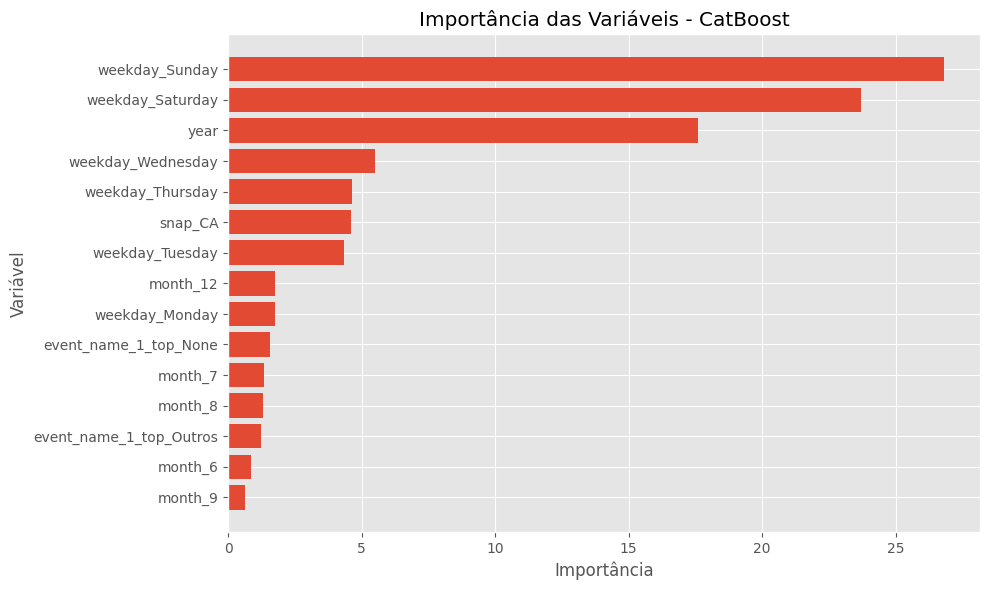


Resumo das métricas - CatBoost:
{'modelo': 'CatBoost Regressor (exógenas)', 'RMSE': 268.5113187421315, 'MAE': 214.71999907947512, 'RMSSE': 0.3100147221994392}


In [72]:


# ==========================================================
# 1) Preparar dados
# ==========================================================
y_train_cb = y_train.asfreq("D").copy().astype(float)
y_val_cb   = y_val.asfreq("D").copy().astype(float)

X_train_cb = X_train.copy()
X_val_cb   = X_val.copy()

print("✅ Dimensões:", X_train_cb.shape, "treino |", X_val_cb.shape, "validação")

# ==========================================================
# 2) Escalonar (opcional — útil se variáveis forem muito heterogêneas)
# ==========================================================
scaler_cb = StandardScaler()
X_train_cb = pd.DataFrame(
    scaler_cb.fit_transform(X_train_cb),
    index=X_train_cb.index,
    columns=X_train_cb.columns
)
X_val_cb = pd.DataFrame(
    scaler_cb.transform(X_val_cb),
    index=X_val_cb.index,
    columns=X_val_cb.columns
)

# ==========================================================
# 3) Pool do CatBoost (estrutura otimizada para treino/validação)
# ==========================================================
train_pool = Pool(X_train_cb, y_train_cb)
val_pool   = Pool(X_val_cb, y_val_cb)

# ==========================================================
# 4) Definir hiperparâmetros base (inspirados no Kaggle M5)
# ==========================================================
cat_params = {
    "iterations": 3000,                # número máximo de árvores
    "learning_rate": 0.03,             # taxa de aprendizado
    "depth": 8,                        # profundidade das árvores
    "l2_leaf_reg": 3.0,                # regularização L2
    "loss_function": "RMSE",           # objetivo: erro quadrático médio
    "eval_metric": "RMSE",
    "od_type": "Iter",                 # early stopping
    "od_wait": 100,
    "random_seed": 42,
    "verbose": 200,
    "allow_writing_files": False
}

# ==========================================================
# 5) Treinar modelo
# ==========================================================
cat_model = CatBoostRegressor(**cat_params)
cat_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

# ==========================================================
# 6) Fazer previsões
# ==========================================================
cat_fc = cat_model.predict(X_val_cb)
cat_fc = pd.Series(cat_fc, index=y_val_cb.index, name="forecast")

# ==========================================================
# 7) Avaliar desempenho com sua função personalizada
# ==========================================================
modelo_nm = "CatBoost Regressor (exógenas)"
results = avaliar_modelo(modelo_nm, cat_fc, y_train_cb, y_val_cb, results, ultimos_pontos=500)

# ==========================================================
# 8) Importância das variáveis
# ==========================================================
importances = cat_model.get_feature_importance(train_pool)
feat_imp = pd.DataFrame({
    "Feature": X_train_cb.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp["Feature"].head(15)[::-1], feat_imp["Importance"].head(15)[::-1])
plt.title("Importância das Variáveis - CatBoost")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

# ==========================================================
# 9) Sumário rápido das métricas
# ==========================================================
print("\nResumo das métricas - CatBoost:")
print(results[-1])


In [76]:
# ==========================================================
# LSTM (multivariado) com exógenas
# ==========================================================


# ----------------------------
# 0) Parâmetros
# ----------------------------
LOOKBACK        = 56      # janela (≈ 8 semanas capta s=7 e padrões de 4/8 semanas)
EPOCHS          = 100
BATCH_SIZE      = 64
PATIENCE_ES     = 12
PATIENCE_RLRP   = 6
VAL_SPLIT_LOCAL = 0.1     # separação dentro do treino para early stopping

# ----------------------------
# 1) Preparar bases
# ----------------------------
# (garantia de frequência e tipos)
y_train_lstm = y_train.asfreq("D").astype(float).copy()
y_val_lstm   = y_val.asfreq("D").astype(float).copy()

# Usaremos as MESMAS exógenas já tratadas (X_train/X_val) — precisam ter as mesmas colunas
X_train_lstm = X_train.copy()
X_val_lstm   = X_val.copy()
X_val_lstm   = X_val_lstm.reindex(columns=X_train_lstm.columns, fill_value=0)

# Índices úteis
idx_train = y_train_lstm.index
idx_val   = y_val_lstm.index
idx_all   = idx_train.append(idx_val)

# Concatenar para facilitar janelas e uso de exógenas futuras
y_all = pd.concat([y_train_lstm, y_val_lstm])
X_all = pd.concat([X_train_lstm, X_val_lstm])

# ----------------------------
# 2) Escalonamento (fit só no TREINO)
# ----------------------------
sc_y  = MinMaxScaler(feature_range=(0, 1))
sc_X  = MinMaxScaler(feature_range=(0, 1))

y_train_2d = y_train_lstm.values.reshape(-1, 1)  # (n,1) para o scaler
sc_y.fit(y_train_2d)
y_all_scaled = sc_y.transform(y_all.values.reshape(-1, 1)).ravel()

sc_X.fit(X_train_lstm.values)
X_all_scaled = sc_X.transform(X_all.values)  # (n_total, n_feat)

n_total = len(y_all_scaled)
n_train = len(y_train_lstm)
n_feat  = X_all_scaled.shape[1]

# ----------------------------
# 3) Função para criar sequências supervisonadas
#     - Usa janelas [t-LOOKBACK .. t-1] -> prediz y[t]
#     - Só gera alvos até o final do TREINO
# ----------------------------
def make_sequences(y_scaled, X_scaled, lookback, n_train):
    X_seq, y_seq = [], []
    # último índice de alvo de treino é n_train-1; logo, começa em 'lookback' e vai até n_train-1
    for t in range(lookback, n_train):
        y_window = y_scaled[t - lookback:t].reshape(lookback, 1)
        X_window = X_scaled[t - lookback:t, :]           # (lookback, n_feat)
        X_seq.append(np.hstack([y_window, X_window]))     # concat target passado + exógenas no tempo
        y_seq.append(y_scaled[t])                         # alvo é y[t]
    X_seq = np.array(X_seq)  # (n_samples, lookback, 1+n_feat)
    y_seq = np.array(y_seq)  # (n_samples,)
    return X_seq, y_seq

X_seq_tr, y_seq_tr = make_sequences(y_all_scaled, X_all_scaled, LOOKBACK, n_train)

print(f"🔧 Seq de treino -> X:{X_seq_tr.shape} | y:{y_seq_tr.shape} | n_feat={n_feat}")

# ----------------------------
# 4) Modelo LSTM
# ----------------------------
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

inp = keras.Input(shape=(LOOKBACK, 1 + n_feat))
x   = keras.layers.LSTM(64, return_sequences=True)(inp)
x   = keras.layers.Dropout(0.2)(x)
x   = keras.layers.LSTM(32, return_sequences=False)(x)
x   = keras.layers.Dropout(0.2)(x)
out = keras.layers.Dense(1)(x)

model = keras.Model(inp, out)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")

cb = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE_ES, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=PATIENCE_RLRP, min_lr=1e-5, verbose=1)
]

hist = model.fit(
    X_seq_tr, y_seq_tr,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT_LOCAL,
    verbose=1,
    callbacks=cb
)

# ----------------------------
# 5) Forecast recursivo no horizonte de validação
#     - Para k=0..len(val)-1:
#         usa última janela de (y_real_train + y_pred_prev) + X futura
# ----------------------------
y_hist_scaled = y_all_scaled[:n_train].tolist()  # histórico inicial = treino (escalado)
y_preds_scaled = []

for step in range(len(y_val_lstm)):
    t = n_train + step  # índice absoluto no vetor concatenado

    # janela [t-LOOKBACK .. t-1]
    y_window = np.array(y_hist_scaled[-LOOKBACK:]).reshape(LOOKBACK, 1)
    X_window = X_all_scaled[t - LOOKBACK:t, :]  # exógenas reais (futuras) já disponíveis

    x_input = np.hstack([y_window, X_window])[None, :, :]  # (1, LOOKBACK, 1+n_feat)
    y_hat_scaled = model.predict(x_input, verbose=0)[0, 0]

    y_preds_scaled.append(y_hat_scaled)
    y_hist_scaled.append(y_hat_scaled)  # adiciona previsão para próxima janela

# Inverter escala
y_pred_val = sc_y.inverse_transform(np.array(y_preds_scaled).reshape(-1, 1)).ravel()
lstm_fc = pd.Series(y_pred_val, index=idx_val, name="forecast")

# ----------------------------
# 6) Avaliação com sua função
# ----------------------------
modelo_nm = f"LSTM (lookback={LOOKBACK}, exógenas)"
results = avaliar_modelo(modelo_nm, lstm_fc, y_train_lstm, y_val_lstm, results, ultimos_pontos=500)

# ----------------------------
# 7) Dicas de tuning (rápido)
# ----------------------------
print("\n💡 Dicas de tuning:")
print("- Aumente LOOKBACK para 84/112 se notar padrão sazonal mais longo.")
print("- Teste 1 camada LSTM (64) + Dense(32) ou 2 LSTMs (128->64) se houver tempo.")
print("- Ajuste learning_rate (1e-3 → 5e-4) e patience para estabilidade.")
print("- Use mais exógenas (weekday/month dummies) se não estiverem no X_train.")


🔧 Seq de treino -> X:(1829, 56, 46) | y:(1829,) | n_feat=45
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.1026 - val_loss: 0.0190 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0242 - val_loss: 0.0177 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0207 - val_loss: 0.0175 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0190 - val_loss: 0.0176 - learning_rate: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0184 - val_loss: 0.0160 - learning_rate: 0.0010
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0160 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0143 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0134 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss:


💡 Dicas de tuning:
- Aumente LOOKBACK para 84/112 se notar padrão sazonal mais longo.
- Teste 1 camada LSTM (64) + Dense(32) ou 2 LSTMs (128->64) se houver tempo.
- Ajuste learning_rate (1e-3 → 5e-4) e patience para estabilidade.
- Use mais exógenas (weekday/month dummies) se não estiverem no X_train.


In [89]:
# ==========================================================
# WALK-FORWARD VALIDATION - MODELO NAIVE
# ==========================================================

# 1) Série completa (frequência diária garantida)
y_all = serie_diaria.asfreq("D").astype(float)

# 2) Parâmetros do walk-forward
train_size = 3 * 365   # 3 anos
test_size  = 28        # horizonte
step_size  = 28        # avanço

fold = 0
start = 0
rmse_list, mae_list, rmsse_list = [], [], []

y_train_last = None
y_val_last   = None
y_pred_last  = None

# 3) Loop Walk-Forward
while start + train_size + test_size <= len(y_all):
    fold += 1
    end_train = start + train_size
    end_val   = end_train + test_size

    y_tr = y_all.iloc[start:end_train]
    y_va = y_all.iloc[end_train:end_val]

    # --- Modelo Naive ---
    y_pr = pd.Series(y_tr.iloc[-1], index=y_va.index)

    # --- Métricas ---
    rmse_f  = sqrt(mean_squared_error(y_va, y_pr))
    mae_f   = mean_absolute_error(y_va, y_pr)
    rmsse_f = rmsse_robust(y_va, y_pr, y_tr)

    rmse_list.append(rmse_f)
    mae_list.append(mae_f)
    rmsse_list.append(rmsse_f)

    print(f"Fold {fold:02d} | {y_va.index[0].date()} → {y_va.index[-1].date()} "
          f"| RMSE={rmse_f:.3f} | MAE={mae_f:.3f} | RMSSE={rmsse_f:.3f}")

    # Guardar último fold para visualização
    y_train_last = y_tr.copy()
    y_val_last   = y_va.copy()
    y_pred_last  = y_pr.copy()

    start += step_size

# 4) Avaliação detalhada (último fold)
modelo_nm = "Naive (Walk-Forward • último fold)"
results   = avaliar_modelo(modelo_nm, y_pred_last, y_train_last, y_val_last, results, ultimos_pontos=500)




Fold 01 | 2014-01-28 → 2014-02-24 | RMSE=1112.059 | MAE=820.571 | RMSSE=1.353
Fold 02 | 2014-02-25 → 2014-03-24 | RMSE=1078.206 | MAE=796.679 | RMSSE=1.308
Fold 03 | 2014-03-25 → 2014-04-21 | RMSE=990.021 | MAE=694.821 | RMSSE=1.193
Fold 04 | 2014-04-22 → 2014-05-19 | RMSE=964.373 | MAE=689.750 | RMSSE=1.153
Fold 05 | 2014-05-20 → 2014-06-16 | RMSE=826.495 | MAE=642.179 | RMSSE=0.983
Fold 06 | 2014-06-17 → 2014-07-14 | RMSE=777.966 | MAE=613.821 | RMSSE=0.920
Fold 07 | 2014-07-15 → 2014-08-11 | RMSE=931.929 | MAE=666.000 | RMSSE=1.098
Fold 08 | 2014-08-12 → 2014-09-08 | RMSE=1046.504 | MAE=774.893 | RMSSE=1.223
Fold 09 | 2014-09-09 → 2014-10-06 | RMSE=1045.704 | MAE=763.357 | RMSSE=1.209
Fold 10 | 2014-10-07 → 2014-11-03 | RMSE=1065.738 | MAE=968.000 | RMSSE=1.226
Fold 11 | 2014-11-04 → 2014-12-01 | RMSE=1115.638 | MAE=972.750 | RMSSE=1.273
Fold 12 | 2014-12-02 → 2014-12-29 | RMSE=1139.487 | MAE=799.179 | RMSSE=1.296
Fold 13 | 2014-12-30 → 2015-01-26 | RMSE=998.318 | MAE=803.429 | RMSS

In [93]:
# ==========================================================
# WALK-FORWARD fixando o último fold = últimos 28 dias
# ==========================================================


# Série completa diária
y_all = pd.concat([y_train, y_val]).asfreq("D")
y_all = pd.to_numeric(y_all, errors="coerce").astype("float64").fillna(method="ffill").fillna(0.0)

# Parâmetros
h = 28                        # horizonte fixo (últimos 28 dias)
min_train = 365 * 2           # exige pelo menos 2 anos de treino
step_size = h                 # avança 28 dias por vez
fold = 0

rmse_list, mae_list, rmsse_list = [], [], []
y_train_last = y_val_last = y_pred_last = None

# Loop controlado: até garantir o último fold exatamente nos últimos 28 dias
for end_val in range(min_train + h, len(y_all) + 1, step_size):
    end_train = end_val - h
    y_tr = y_all.iloc[:end_train].copy()
    y_va = y_all.iloc[end_train:end_val].copy()

    # Pula folds muito pequenos
    if len(y_tr) < min_train:
        continue

    fold += 1
    print(f"\n🔹 Fold {fold}: Treino = {y_tr.index[0].date()} → {y_tr.index[-1].date()} | "
          f"Validação = {y_va.index[0].date()} → {y_va.index[-1].date()}")

    # Ajuste SARIMA
    try:
        modelo = SARIMAX(
            y_tr,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False,
            initialization="approximate_diffuse"
        ).fit(disp=False, maxiter=500)
    except Exception as e:
        print(f"⚠️ Erro no ajuste do fold {fold}: {e}")
        continue

    # Previsão
    y_pr = modelo.forecast(steps=len(y_va))
    y_pr = pd.Series(y_pr, index=y_va.index)

    # Métricas
    rmse_f = np.sqrt(mean_squared_error(y_va, y_pr))
    mae_f = mean_absolute_error(y_va, y_pr)
    rmsse_f = rmsse_robust(y_va, y_pr, y_tr)
    rmse_list.append(rmse_f)
    mae_list.append(mae_f)
    rmsse_list.append(rmsse_f)

    print(f"→ RMSE={rmse_f:.3f} | MAE={mae_f:.3f} | RMSSE={rmsse_f:.3f}")

    # Salva o último fold (últimos 28 dias)
    y_train_last = y_tr
    y_val_last = y_va
    y_pred_last = y_pr

# ==========================================
# Avaliação final com sua função
# ==========================================
modelo_nm = "SARIMA(1,1,1)x(1,1,1,7) • Walk-Forward (últimos 28 dias)"
results = avaliar_modelo(modelo_nm, y_pred_last, y_train_last, y_val_last, results, ultimos_pontos=h)

# ==========================================
# Resumo geral (média dos folds)
# ==========================================
results.append({
    "modelo": "SARIMA(1,1,1)x(1,1,1,7) • Walk-Forward (média folds)",
    "RMSE": float(np.mean(rmse_list)),
    "MAE": float(np.mean(mae_list)),
    "RMSSE": float(np.mean(rmsse_list))
})

print("\n==================== RESUMO WALK-FORWARD (SARIMA) ====================")
print(f"Total de folds: {fold}")
print(f"Média RMSE : {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")
print(f"Média MAE  : {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"Média RMSSE: {np.mean(rmsse_list):.3f} ± {np.std(rmsse_list):.3f}")
print("=======================================================================")



🔹 Fold 1: Treino = 2011-01-29 → 2013-01-27 | Validação = 2013-01-28 → 2013-02-24
→ RMSE=598.783 | MAE=488.704 | RMSSE=0.772

🔹 Fold 2: Treino = 2011-01-29 → 2013-02-24 | Validação = 2013-02-25 → 2013-03-24
→ RMSE=246.761 | MAE=172.538 | RMSSE=0.315

🔹 Fold 3: Treino = 2011-01-29 → 2013-03-24 | Validação = 2013-03-25 → 2013-04-21
→ RMSE=469.318 | MAE=362.804 | RMSSE=0.599

🔹 Fold 4: Treino = 2011-01-29 → 2013-04-21 | Validação = 2013-04-22 → 2013-05-19
→ RMSE=345.239 | MAE=287.595 | RMSSE=0.440

🔹 Fold 5: Treino = 2011-01-29 → 2013-05-19 | Validação = 2013-05-20 → 2013-06-16
→ RMSE=485.206 | MAE=410.582 | RMSSE=0.618

🔹 Fold 6: Treino = 2011-01-29 → 2013-06-16 | Validação = 2013-06-17 → 2013-07-14
→ RMSE=549.062 | MAE=416.775 | RMSSE=0.698

🔹 Fold 7: Treino = 2011-01-29 → 2013-07-14 | Validação = 2013-07-15 → 2013-08-11
→ RMSE=390.110 | MAE=331.867 | RMSSE=0.497

🔹 Fold 8: Treino = 2011-01-29 → 2013-08-11 | Validação = 2013-08-12 → 2013-09-08
→ RMSE=523.722 | MAE=431.458 | RMSSE=0.668



==================== RESUMO WALK-FORWARD (SARIMA) ====================
Total de folds: 42
Média RMSE : 481.508 ± 144.480
Média MAE  : 367.019 ± 89.026
Média RMSSE: 0.583 ± 0.176


In [94]:
# ==========================================================
# WALK-FORWARD • SARIMAX(1,1,1)x(1,1,1,7) com EXÓGENAS
#  - último fold = últimos 28 dias (F1–F28)
#  - usa avaliar_modelo() no último fold + linha de médias
# ==========================================================

# -----------------------------
# 1) Série completa + EXÓGENAS
# -----------------------------
# y_train / y_val já foram garantidos como diários acima
y_all = pd.concat([y_train, y_val]).asfreq("D")
y_all = pd.to_numeric(y_all, errors="coerce").astype("float64").fillna(method="ffill").fillna(0.0)

# X_train / X_val já prontos no seu bloco
X_all = pd.concat([X_train, X_val]).reindex(y_all.index)
# garantir que só as colunas planejadas entrem:
X_all = X_all.reindex(columns=X_train.columns, fill_value=0.0)

# Sanitização final (defensiva)
X_all = X_all.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype("float64")

# Seleção de EXÓGENAS (do seu bloco)
cols_exog = []
if "snap_CA" in X_all.columns:
    cols_exog.append("snap_CA")
cols_exog += [c for c in X_all.columns if c.startswith("event_name_1_top_") or c.startswith("event_name_2_top_")]
# (opcional) incluir também weekday_/month_:
# cols_exog += [c for c in X_all.columns if c.startswith("weekday_") or c.startswith("month_")]

print(f"📊 Exógenas usadas ({len(cols_exog)}):", cols_exog[:10], "..." if len(cols_exog) > 10 else "")

# -----------------------------
# 2) Parâmetros do walk-forward
# -----------------------------
h = 28                 # horizonte fixo (últimos 28 dias)
min_train = 365 * 2    # exige pelo menos 2 anos de treino
step_size = h          # avança 28 dias por vez

fold = 0
rmse_list, mae_list, rmsse_list = [], [], []
y_train_last = y_val_last = y_pred_last = None

# -----------------------------
# 3) Loop walk-forward
#    (garantindo que o último fold = últimos 28 dias)
# -----------------------------
for end_val in range(min_train + h, len(y_all) + 1, step_size):
    end_train = end_val - h

    y_tr = y_all.iloc[:end_train].copy()
    y_va = y_all.iloc[end_train:end_val].copy()

    if len(y_tr) < min_train:
        continue  # pula folds pequenos

    X_tr = X_all.iloc[:end_train, :].copy()
    X_va = X_all.iloc[end_train:end_val, :].copy()

    # fatia somente as colunas exógenas selecionadas
    X_tr_ex = X_tr[cols_exog].astype("float64")
    X_va_ex = X_va[cols_exog].astype("float64")

    fold += 1
    print(f"\n🔹 Fold {fold}: Treino {y_tr.index[0].date()} → {y_tr.index[-1].date()} | "
          f"Val {y_va.index[0].date()} → {y_va.index[-1].date()} | X_tr_ex shape: {X_tr_ex.shape}")

    # Ajuste SARIMAX com exógenas
    try:
        modelo = SARIMAX(
            y_tr,
            exog=X_tr_ex,
            order=(1,1,1),
            seasonal_order=(1,1,1,7),
            enforce_stationarity=False,
            enforce_invertibility=False,
            initialization="approximate_diffuse"
        ).fit(disp=False, maxiter=500)
    except Exception as e:
        print(f"⚠️ Erro no ajuste do fold {fold}: {e}")
        continue

    # Forecast do horizonte do fold
    y_pr = modelo.forecast(steps=len(y_va), exog=X_va_ex)
    y_pr = pd.Series(y_pr, index=y_va.index)

    # Métricas do fold
    rmse_f  = float(np.sqrt(mean_squared_error(y_va, y_pr)))
    mae_f   = float(mean_absolute_error(y_va, y_pr))
    rmsse_f = float(rmsse_robust(y_va, y_pr, y_tr))
    rmse_list.append(rmse_f); mae_list.append(mae_f); rmsse_list.append(rmsse_f)

    print(f"→ RMSE={rmse_f:.3f} | MAE={mae_f:.3f} | RMSSE={rmsse_f:.3f}")

    # Guardar o ÚLTIMO fold (será o dos últimos 28 dias)
    y_train_last = y_tr
    y_val_last   = y_va
    y_pred_last  = y_pr

# -----------------------------
# 4) Avaliar último fold (F1–F28)
# -----------------------------
modelo_nm = "SARIMAX(1,1,1)x(1,1,1,7) + exógenas • Walk-Forward (últimos 28)"
results   = avaliar_modelo(modelo_nm, y_pred_last, y_train_last, y_val_last, results, ultimos_pontos=h)

# -----------------------------
# 5) Adicionar linha de médias dos folds
# -----------------------------
results.append({
    "modelo": "SARIMAX + exógenas • Walk-Forward (média folds)",
    "RMSE":   float(np.mean(rmse_list)),
    "MAE":    float(np.mean(mae_list)),
    "RMSSE":  float(np.mean(rmsse_list))
})

print("\n==================== RESUMO WALK-FORWARD (SARIMAX + exógenas) ====================")
print(f"Total de folds: {len(rmse_list)}")
print(f"Média RMSE : {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")
print(f"Média MAE  : {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"Média RMSSE: {np.mean(rmsse_list):.3f} ± {np.std(rmsse_list):.3f}")
print("==================================================================================")


📊 Exógenas usadas (25): ['snap_CA', 'event_name_1_top_Easter', 'event_name_1_top_Eid al-Fitr', 'event_name_1_top_IndependenceDay', 'event_name_1_top_LentStart', 'event_name_1_top_LentWeek2', 'event_name_1_top_MartinLutherKingDay', 'event_name_1_top_MemorialDay', "event_name_1_top_Mother's day", 'event_name_1_top_NBAFinalsEnd'] ...

🔹 Fold 1: Treino 2011-01-29 → 2013-01-27 | Val 2013-01-28 → 2013-02-24 | X_tr_ex shape: (730, 25)
→ RMSE=561.365 | MAE=461.365 | RMSSE=0.724

🔹 Fold 2: Treino 2011-01-29 → 2013-02-24 | Val 2013-02-25 → 2013-03-24 | X_tr_ex shape: (758, 25)
→ RMSE=213.314 | MAE=182.292 | RMSSE=0.273

🔹 Fold 3: Treino 2011-01-29 → 2013-03-24 | Val 2013-03-25 → 2013-04-21 | X_tr_ex shape: (786, 25)
→ RMSE=482.782 | MAE=339.937 | RMSSE=0.616

🔹 Fold 4: Treino 2011-01-29 → 2013-04-21 | Val 2013-04-22 → 2013-05-19 | X_tr_ex shape: (814, 25)
→ RMSE=345.727 | MAE=248.021 | RMSSE=0.440

🔹 Fold 5: Treino 2011-01-29 → 2013-05-19 | Val 2013-05-20 → 2013-06-16 | X_tr_ex shape: (842, 25)



==================== RESUMO WALK-FORWARD (SARIMAX + exógenas) ====================
Total de folds: 42
Média RMSE : 431.629 ± 142.790
Média MAE  : 325.781 ± 94.341
Média RMSSE: 0.523 ± 0.174


In [95]:
# ==========================================================
# WALK-FORWARD • Holt–Winters (sazonalidade multiplicativa, s=7)
#  - último fold = últimos 28 dias
#  - usa avaliar_modelo() no último fold + linha de médias
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Série completa diária
y_all = pd.concat([y_train, y_val]).asfreq("D").astype("float64")

# Multiplicativo exige y>0 (garantia)
eps = 1e-6
if (y_all <= 0).any():
    y_all = y_all.clip(lower=eps)

# Parâmetros do walk-forward
h = 28                 # horizonte
min_train = 365 * 2    # pelo menos 2 anos de treino
step_size = h          # avanço

fold = 0
rmse_list, mae_list, rmsse_list = [], [], []
y_train_last = y_val_last = y_pred_last = None

# Loop garantindo que o último fold termina nos últimos 28 dias
for end_val in range(min_train + h, len(y_all) + 1, step_size):
    end_train = end_val - h
    y_tr = y_all.iloc[:end_train].copy()
    y_va = y_all.iloc[end_train:end_val].copy()

    if len(y_tr) < min_train:
        continue

    # Reforça positividade também por fold
    if (y_tr <= 0).any() or (y_va <= 0).any():
        y_tr = y_tr.clip(lower=eps)
        y_va = y_va.clip(lower=eps)

    fold += 1
    print(f"\n🔹 Fold {fold}: Treino {y_tr.index[0].date()} → {y_tr.index[-1].date()} | "
          f"Val {y_va.index[0].date()} → {y_va.index[-1].date()}")

    # Ajuste HW multiplicativo (s=7)
    try:
        hw_model = ExponentialSmoothing(
            y_tr,
            trend="add",              # pode testar "mul" se a tendência for proporcional
            damped_trend=True,        # ajuda a estabilizar
            seasonal="mul",
            seasonal_periods=7,
            initialization_method="estimated"
        ).fit(optimized=True, use_brute=False)
    except Exception as e:
        print(f"⚠️ Erro no ajuste do fold {fold}: {e}")
        continue

    # Previsão do horizonte
    y_pr = hw_model.forecast(len(y_va))
    y_pr.index = y_va.index

    # Métricas do fold
    rmse_f  = float(np.sqrt(mean_squared_error(y_va, y_pr)))
    mae_f   = float(mean_absolute_error(y_va, y_pr))
    rmsse_f = float(rmsse_robust(y_va, y_pr, y_tr))

    rmse_list.append(rmse_f); mae_list.append(mae_f); rmsse_list.append(rmsse_f)
    print(f"→ RMSE={rmse_f:.3f} | MAE={mae_f:.3f} | RMSSE={rmsse_f:.3f}")

    # Guardar último fold (os últimos 28 dias)
    y_train_last = y_tr
    y_val_last   = y_va
    y_pred_last  = y_pr

# Avaliação final (últimos 28 dias) com sua função
modelo_nm = "Holt–Winters Multiplicativo (s=7, damped) • Walk-Forward (últimos 28)"
results   = avaliar_modelo(modelo_nm, y_pred_last, y_train_last, y_val_last, results, ultimos_pontos=h)

# Linha de médias dos folds
results.append({
    "modelo": "Holt–Winters Multiplicativo (s=7, damped) • Walk-Forward (média folds)",
    "RMSE":   float(np.mean(rmse_list)),
    "MAE":    float(np.mean(mae_list)),
    "RMSSE":  float(np.mean(rmsse_list))
})

print("\n==================== RESUMO WALK-FORWARD (HW multiplicativo) ====================")
print(f"Total de folds: {len(rmse_list)}")
print(f"Média RMSE : {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")
print(f"Média MAE  : {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"Média RMSSE: {np.mean(rmsse_list):.3f} ± {np.std(rmsse_list):.3f}")
print("=================================================================================")

# (Opcional) ver parâmetros do último ajuste
try:
    params = getattr(hw_model, 'model', hw_model.model).params
    print("alpha:", params.get('smoothing_level'),
          "| beta:", params.get('smoothing_trend'),
          "| phi (damping):", params.get('damping_trend'),
          "| gamma:", params.get('smoothing_seasonal'))
except Exception:
    pass



🔹 Fold 1: Treino 2011-01-29 → 2013-01-27 | Val 2013-01-28 → 2013-02-24
→ RMSE=624.414 | MAE=490.990 | RMSSE=0.805

🔹 Fold 2: Treino 2011-01-29 → 2013-02-24 | Val 2013-02-25 → 2013-03-24
→ RMSE=243.037 | MAE=166.755 | RMSSE=0.311

🔹 Fold 3: Treino 2011-01-29 → 2013-03-24 | Val 2013-03-25 → 2013-04-21
→ RMSE=475.633 | MAE=369.087 | RMSSE=0.607

🔹 Fold 4: Treino 2011-01-29 → 2013-04-21 | Val 2013-04-22 → 2013-05-19
→ RMSE=400.146 | MAE=328.694 | RMSSE=0.510

🔹 Fold 5: Treino 2011-01-29 → 2013-05-19 | Val 2013-05-20 → 2013-06-16
→ RMSE=486.766 | MAE=418.768 | RMSSE=0.620

🔹 Fold 6: Treino 2011-01-29 → 2013-06-16 | Val 2013-06-17 → 2013-07-14
→ RMSE=553.771 | MAE=425.597 | RMSSE=0.704

🔹 Fold 7: Treino 2011-01-29 → 2013-07-14 | Val 2013-07-15 → 2013-08-11
→ RMSE=447.846 | MAE=352.431 | RMSSE=0.571

🔹 Fold 8: Treino 2011-01-29 → 2013-08-11 | Val 2013-08-12 → 2013-09-08
→ RMSE=518.306 | MAE=449.648 | RMSSE=0.661

🔹 Fold 9: Treino 2011-01-29 → 2013-09-08 | Val 2013-09-09 → 2013-10-06
→ RMSE=4


==================== RESUMO WALK-FORWARD (HW multiplicativo) ====================
Total de folds: 42
Média RMSE : 522.259 ± 173.061
Média MAE  : 415.642 ± 147.709
Média RMSSE: 0.632 ± 0.208
alpha: 0.1918702568189796 | beta: 0.0 | phi (damping): 0.9084850385469059 | gamma: 0.026283414335406634



🔹 XGB Fold 1: Treino 2011-01-29 → 2013-01-27 | Val 2013-01-28 → 2013-02-24 | X_tr shape: (730, 45)
→ RMSE=414.386 | MAE=326.340 | RMSSE=0.534 | best_ntree=1133

🔹 XGB Fold 2: Treino 2011-01-29 → 2013-02-24 | Val 2013-02-25 → 2013-03-24 | X_tr shape: (758, 45)
→ RMSE=259.461 | MAE=213.263 | RMSSE=0.332 | best_ntree=95

🔹 XGB Fold 3: Treino 2011-01-29 → 2013-03-24 | Val 2013-03-25 → 2013-04-21 | X_tr shape: (786, 45)
→ RMSE=337.742 | MAE=260.967 | RMSSE=0.431 | best_ntree=349

🔹 XGB Fold 4: Treino 2011-01-29 → 2013-04-21 | Val 2013-04-22 → 2013-05-19 | X_tr shape: (814, 45)
→ RMSE=339.266 | MAE=264.557 | RMSSE=0.432 | best_ntree=563

🔹 XGB Fold 5: Treino 2011-01-29 → 2013-05-19 | Val 2013-05-20 → 2013-06-16 | X_tr shape: (842, 45)
→ RMSE=458.518 | MAE=381.169 | RMSSE=0.584 | best_ntree=140

🔹 XGB Fold 6: Treino 2011-01-29 → 2013-06-16 | Val 2013-06-17 → 2013-07-14 | X_tr shape: (870, 45)
→ RMSE=606.397 | MAE=463.840 | RMSSE=0.771 | best_ntree=1303

🔹 XGB Fold 7: Treino 2011-01-29 → 2013


==================== RESUMO WALK-FORWARD (XGBoost) ====================
Total de folds: 42
Média RMSE : 405.595 ± 141.224
Média MAE  : 315.715 ± 97.731
Média RMSSE: 0.492 ± 0.175


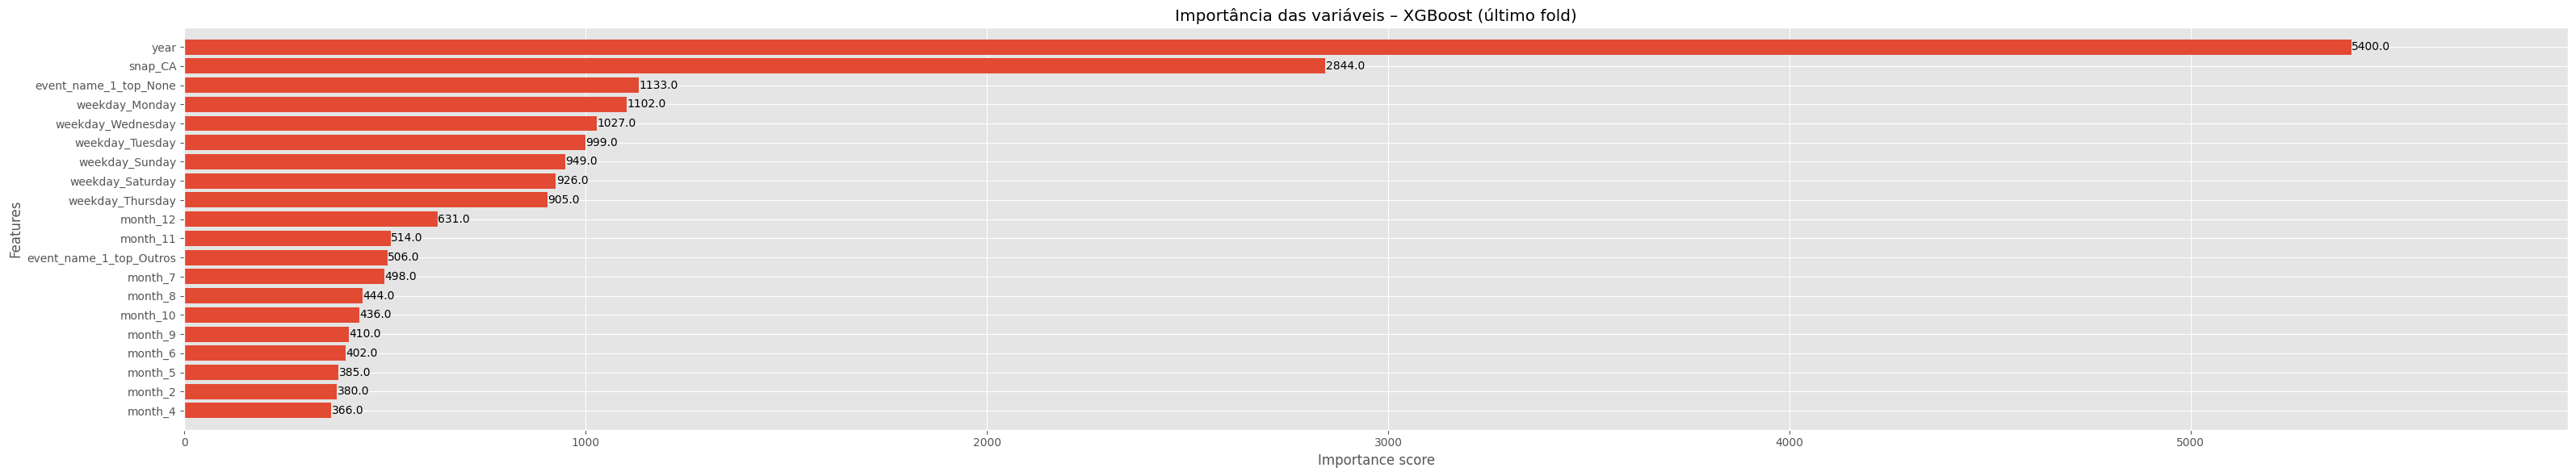

In [97]:
# ==========================================================
# WALK-FORWARD • XGBoost (com exógenas tratadas)
#  - último fold = últimos 28 dias
#  - usa avaliar_modelo() no último fold + linha de médias
# ==========================================================


# -----------------------------
# 1) Série completa + EXÓGENAS
# -----------------------------
y_all = pd.concat([y_train, y_val]).asfreq("D").astype("float64")
X_all = pd.concat([X_train, X_val]).reindex(y_all.index)
# garantir numérico e sem NaN
X_all = X_all.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype("float64")

# -----------------------------
# 2) Parâmetros do walk-forward
# -----------------------------
h = 28                 # horizonte de validação
min_train = 365 * 2    # ao menos 2 anos para treinar
step_size = h          # avança 28 em 28

fold = 0
rmse_list, mae_list, rmsse_list = [], [], []
y_train_last = y_val_last = y_pred_last = None

# -----------------------------
# 3) Loop walk-forward
# -----------------------------
for end_val in range(min_train + h, len(y_all) + 1, step_size):
    end_train = end_val - h

    y_tr = y_all.iloc[:end_train].copy()
    y_va = y_all.iloc[end_train:end_val].copy()
    if len(y_tr) < min_train:
        continue

    X_tr = X_all.iloc[:end_train, :].copy()
    X_va = X_all.iloc[end_train:end_val, :].copy()

    fold += 1
    print(f"\n🔹 XGB Fold {fold}: Treino {y_tr.index[0].date()} → {y_tr.index[-1].date()} | "
          f"Val {y_va.index[0].date()} → {y_va.index[-1].date()} | X_tr shape: {X_tr.shape}")

    # -----------------------------
    # 3.1) Padronização (fit só no treino do fold)
    # -----------------------------
    scaler = StandardScaler()
    X_tr_s = pd.DataFrame(scaler.fit_transform(X_tr), index=X_tr.index, columns=X_tr.columns)
    X_va_s = pd.DataFrame(scaler.transform(X_va),     index=X_va.index, columns=X_va.columns)

    # -----------------------------
    # 3.2) DMatrix
    # -----------------------------
    dtrain = xgb.DMatrix(X_tr_s, label=y_tr.values)
    dval   = xgb.DMatrix(X_va_s, label=y_va.values)

    # -----------------------------
    # 3.3) Hiperparâmetros (baseline sólido p/ M5-like)
    # -----------------------------
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "eta": 0.05,
        "max_depth": 7,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "lambda": 1.0,      # L2
        "alpha": 0.3,       # L1
        "seed": 42,
        "nthread": -1,
        "tree_method": "hist"
    }

    # -----------------------------
    # 3.4) Treino com early stopping no val do fold
    # -----------------------------
    evals = [(dtrain, "train"), (dval, "val")]
    xgb_model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=3000,
        evals=evals,
        early_stopping_rounds=200,
        verbose_eval=False
    )

    # -----------------------------
    # 3.5) Previsão e métricas do fold
    # -----------------------------
    y_pr = pd.Series(xgb_model.predict(dval), index=y_va.index, name="forecast")

    rmse_f  = float(np.sqrt(mean_squared_error(y_va, y_pr)))
    mae_f   = float(mean_absolute_error(y_va, y_pr))
    rmsse_f = float(rmsse_robust(y_va, y_pr, y_tr))
    rmse_list.append(rmse_f); mae_list.append(mae_f); rmsse_list.append(rmsse_f)

    print(f"→ RMSE={rmse_f:.3f} | MAE={mae_f:.3f} | RMSSE={rmsse_f:.3f} | best_ntree={xgb_model.best_iteration+1}")

    # Guardar o último fold (últimos 28 dias)
    y_train_last = y_tr
    y_val_last   = y_va
    y_pred_last  = y_pr
    xgb_model_last = xgb_model
    X_va_last_s = X_va_s  # para importar importância se quiser

# -----------------------------
# 4) Avaliar o último fold (F1–F28)
# -----------------------------
modelo_nm = "XGBoost • Walk-Forward (últimos 28)"
results   = avaliar_modelo(modelo_nm, y_pred_last, y_train_last, y_val_last, results, ultimos_pontos=h)

# -----------------------------
# 5) Linha de médias dos folds
# -----------------------------
results.append({
    "modelo": "XGBoost • Walk-Forward (média folds)",
    "RMSE":   float(np.mean(rmse_list)),
    "MAE":    float(np.mean(mae_list)),
    "RMSSE":  float(np.mean(rmsse_list))
})

print("\n==================== RESUMO WALK-FORWARD (XGBoost) ====================")
print(f"Total de folds: {len(rmse_list)}")
print(f"Média RMSE : {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")
print(f"Média MAE  : {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"Média RMSSE: {np.mean(rmsse_list):.3f} ± {np.std(rmsse_list):.3f}")
print("=======================================================================")

# -----------------------------
# 6) Importância de variáveis (do último fold)
# -----------------------------
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_model_last, max_num_features=20, height=0.8)
plt.title("Importância das variáveis – XGBoost (último fold)")
plt.tight_layout()
plt.show()



🔹 CAT Fold 1: Treino 2011-01-29 → 2013-01-27 | Val 2013-01-28 → 2013-02-24 | X_tr shape: (730, 45)
→ RMSE=404.617 | MAE=307.056 | RMSSE=0.522

🔹 CAT Fold 2: Treino 2011-01-29 → 2013-02-24 | Val 2013-02-25 → 2013-03-24 | X_tr shape: (758, 45)
→ RMSE=255.213 | MAE=197.975 | RMSSE=0.326

🔹 CAT Fold 3: Treino 2011-01-29 → 2013-03-24 | Val 2013-03-25 → 2013-04-21 | X_tr shape: (786, 45)
→ RMSE=347.225 | MAE=259.436 | RMSSE=0.443

🔹 CAT Fold 4: Treino 2011-01-29 → 2013-04-21 | Val 2013-04-22 → 2013-05-19 | X_tr shape: (814, 45)
→ RMSE=398.898 | MAE=261.672 | RMSSE=0.508

🔹 CAT Fold 5: Treino 2011-01-29 → 2013-05-19 | Val 2013-05-20 → 2013-06-16 | X_tr shape: (842, 45)
→ RMSE=466.284 | MAE=414.727 | RMSSE=0.594

🔹 CAT Fold 6: Treino 2011-01-29 → 2013-06-16 | Val 2013-06-17 → 2013-07-14 | X_tr shape: (870, 45)
→ RMSE=648.644 | MAE=504.349 | RMSSE=0.825

🔹 CAT Fold 7: Treino 2011-01-29 → 2013-07-14 | Val 2013-07-15 → 2013-08-11 | X_tr shape: (898, 45)
→ RMSE=452.950 | MAE=350.778 | RMSSE=0.578


==================== RESUMO WALK-FORWARD (CatBoost) ====================
Total de folds: 42
Média RMSE : 384.542 ± 134.135
Média MAE  : 290.622 ± 91.500
Média RMSSE: 0.467 ± 0.167


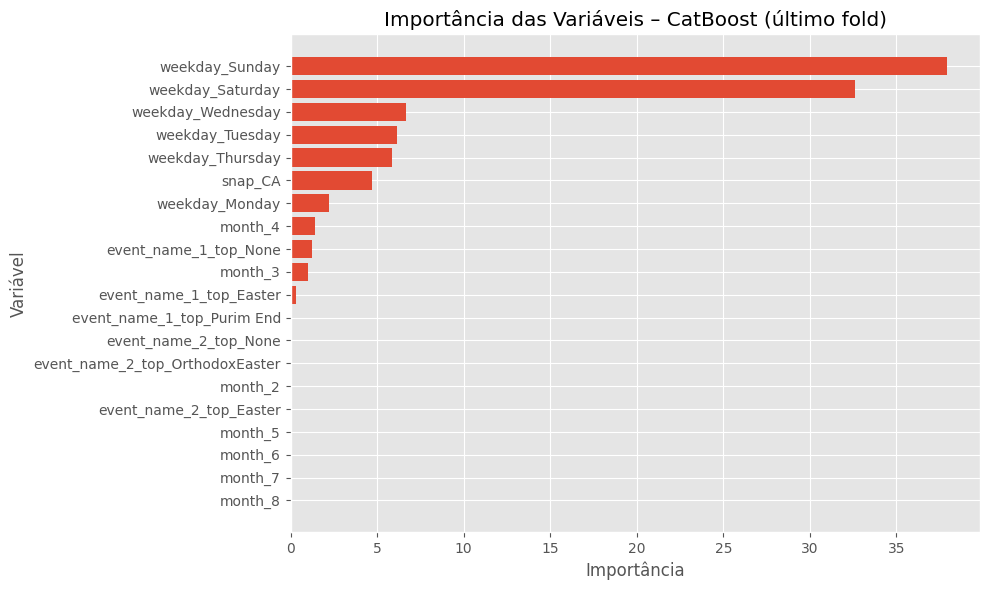

In [98]:
# ==========================================================
# WALK-FORWARD • CatBoost Regressor (com exógenas)
#  - último fold = últimos 28 dias
#  - usa avaliar_modelo() no último fold + linha de médias
# ==========================================================

# -----------------------------
# 1) Série completa + EXÓGENAS
# -----------------------------
y_all = pd.concat([y_train, y_val]).asfreq("D").astype("float64")
X_all = pd.concat([X_train, X_val]).reindex(y_all.index)
X_all = X_all.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype("float64")

# -----------------------------
# 2) Parâmetros do walk-forward
# -----------------------------
h = 28                 # horizonte do fold
min_train = 365 * 2    # pelo menos 2 anos de treino
step_size = h          # avança 28 em 28

fold = 0
rmse_list, mae_list, rmsse_list = [], [], []
y_train_last = y_val_last = y_pred_last = None
cat_model_last = None
X_va_last_s = None

# -----------------------------
# 3) Loop walk-forward
# -----------------------------
for end_val in range(min_train + h, len(y_all) + 1, step_size):
    end_train = end_val - h

    y_tr = y_all.iloc[:end_train].copy()
    y_va = y_all.iloc[end_train:end_val].copy()
    if len(y_tr) < min_train:
        continue

    X_tr = X_all.iloc[:end_train, :].copy()
    X_va = X_all.iloc[end_train:end_val, :].copy()

    fold += 1
    print(f"\n🔹 CAT Fold {fold}: Treino {y_tr.index[0].date()} → {y_tr.index[-1].date()} | "
          f"Val {y_va.index[0].date()} → {y_va.index[-1].date()} | X_tr shape: {X_tr.shape}")

    # -----------------------------
    # 3.1) Escalonamento (opcional) — fit somente no treino do fold
    # -----------------------------
    scaler_cb = StandardScaler()
    X_tr_s = pd.DataFrame(scaler_cb.fit_transform(X_tr), index=X_tr.index, columns=X_tr.columns)
    X_va_s = pd.DataFrame(scaler_cb.transform(X_va),     index=X_va.index, columns=X_va.columns)

    # -----------------------------
    # 3.2) Pools do CatBoost
    # -----------------------------
    train_pool = Pool(X_tr_s, y_tr.values)
    val_pool   = Pool(X_va_s, y_va.values)

    # -----------------------------
    # 3.3) Hiperparâmetros (baseline robusto p/ M5-like)
    # -----------------------------
    cat_params = {
        "iterations": 10000,
        "learning_rate": 0.03,
        "depth": 8,
        "l2_leaf_reg": 3.0,
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "subsample": 0.8,
        "random_seed": 42,
        "od_type": "Iter",       # early stopping
        "od_wait": 300,
        "verbose": False,
        "allow_writing_files": False
    }

    # -----------------------------
    # 3.4) Treino com early stopping no val do fold
    # -----------------------------
    cat_model = CatBoostRegressor(**cat_params)
    cat_model.fit(train_pool, eval_set=val_pool, use_best_model=True, verbose=False)

    # -----------------------------
    # 3.5) Previsão e métricas do fold
    # -----------------------------
    y_pr = pd.Series(cat_model.predict(X_va_s), index=y_va.index, name="forecast")

    rmse_f  = float(np.sqrt(mean_squared_error(y_va, y_pr)))
    mae_f   = float(mean_absolute_error(y_va, y_pr))
    rmsse_f = float(rmsse_robust(y_va, y_pr, y_tr))
    rmse_list.append(rmse_f); mae_list.append(mae_f); rmsse_list.append(rmsse_f)

    print(f"→ RMSE={rmse_f:.3f} | MAE={mae_f:.3f} | RMSSE={rmsse_f:.3f}")

    # Guardar o último fold (últimos 28 dias)
    y_train_last = y_tr
    y_val_last   = y_va
    y_pred_last  = y_pr
    cat_model_last = cat_model
    X_va_last_s = X_va_s

# -----------------------------
# 4) Avaliar o último fold (F1–F28)
# -----------------------------
modelo_nm = "CatBoost • Walk-Forward (últimos 28)"
results   = avaliar_modelo(modelo_nm, y_pred_last, y_train_last, y_val_last, results, ultimos_pontos=h)

# -----------------------------
# 5) Linha de médias dos folds
# -----------------------------
results.append({
    "modelo": "CatBoost • Walk-Forward (média folds)",
    "RMSE":   float(np.mean(rmse_list)),
    "MAE":    float(np.mean(mae_list)),
    "RMSSE":  float(np.mean(rmsse_list))
})

print("\n==================== RESUMO WALK-FORWARD (CatBoost) ====================")
print(f"Total de folds: {len(rmse_list)}")
print(f"Média RMSE : {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")
print(f"Média MAE  : {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"Média RMSSE: {np.mean(rmsse_list):.3f} ± {np.std(rmsse_list):.3f}")
print("=======================================================================")

# -----------------------------
# 6) Importância das variáveis (último fold)
# -----------------------------
if cat_model_last is not None:
    importances = cat_model_last.get_feature_importance(Pool(X_va_last_s, y_val_last.values))
    feat_imp = pd.DataFrame({"Feature": X_va_last_s.columns, "Importance": importances}) \
                 .sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp["Feature"].head(20)[::-1], feat_imp["Importance"].head(20)[::-1])
    plt.title("Importância das Variáveis – CatBoost (último fold)")
    plt.xlabel("Importância")
    plt.ylabel("Variável")
    plt.tight_layout()
    plt.show()


In [99]:
# ==========================================================
# WALK-FORWARD • LSTM (multivariado) com exógenas
#  - último fold = últimos 28 dias
#  - usa avaliar_modelo() no último fold + linha de médias
# ==========================================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ----------------------------
# 0) Parâmetros do modelo
# ----------------------------
LOOKBACK        = 56      # janela (≈ 8 semanas capta s=7 e padrões de 4/8 semanas)
EPOCHS          = 100
BATCH_SIZE      = 64
PATIENCE_ES     = 12
PATIENCE_RLRP   = 6
VAL_SPLIT_LOCAL = 0.1     # validação interna do treino por fold para early stopping

# ----------------------------
# 1) Série completa + EXÓGENAS
# ----------------------------
y_all = pd.concat([y_train.asfreq("D"), y_val.asfreq("D")]).astype(float)
X_all = pd.concat([X_train, X_val]).reindex(y_all.index)
X_all = X_all.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(float)

h          = 28                 # horizonte do fold
min_train  = max(365*2, LOOKBACK + h)  # precisa caber janela + horizonte
step_size  = h

fold = 0
rmse_list, mae_list, rmsse_list = [], [], []
y_train_last = y_val_last = y_pred_last = None

def make_sequences(y_scaled, X_scaled, lookback, last_target_index):
    """
    Cria pares (X_seq, y_seq) para t em [lookback .. last_target_index]
    - y_scaled: array 1D (len=n_total)
    - X_scaled: array 2D (n_total, n_feat)
    - lookback: janela
    - last_target_index: último índice t a ser previsto (inclusive)
    Retorna:
        X_seq: (n_amostras, lookback, 1+n_feat)
        y_seq: (n_amostras,)
        idx_y: índices temporais correspondentes aos alvos
    """
    X_seq, y_seq, idx_y = [], [], []
    for t in range(lookback, last_target_index + 1):
        y_win = y_scaled[t - lookback:t].reshape(lookback, 1)
        X_win = X_scaled[t - lookback:t, :]                # (lookback, n_feat)
        X_seq.append(np.hstack([y_win, X_win]))            # concatena y passado + exógenas no tempo
        y_seq.append(y_scaled[t])
        idx_y.append(t)
    return np.array(X_seq), np.array(y_seq), np.array(idx_y)

# ----------------------------
# 2) Loop walk-forward
# ----------------------------
for end_val in range(min_train + h, len(y_all) + 1, step_size):
    end_train = end_val - h

    y_tr_raw = y_all.iloc[:end_train].copy()
    y_va_raw = y_all.iloc[end_train:end_val].copy()
    if len(y_tr_raw) < min_train:
        continue

    X_tr_raw = X_all.iloc[:end_train, :].copy()
    X_va_raw = X_all.iloc[end_train:end_val, :].copy()

    fold += 1
    print(f"\n🔹 LSTM Fold {fold}: Treino {y_tr_raw.index[0].date()} → {y_tr_raw.index[-1].date()} | "
          f"Val {y_va_raw.index[0].date()} → {y_va_raw.index[-1].date()} | X_tr shape: {X_tr_raw.shape}")

    # ----------------------------
    # 2.1) Escalonamento por fold (fit só no treino)
    # ----------------------------
    sc_y = MinMaxScaler(feature_range=(0, 1))
    sc_X = MinMaxScaler(feature_range=(0, 1))
    y_tr_scaled = sc_y.fit_transform(y_tr_raw.values.reshape(-1, 1)).ravel()

    # concatenamos treino+val só para usar exógenas "futuras" (X_va) na janela
    y_all_fold_scaled = np.concatenate([y_tr_scaled, sc_y.transform(y_va_raw.values.reshape(-1,1)).ravel()])

    X_tr_scaled = sc_X.fit_transform(X_tr_raw.values)   # (n_tr, n_feat)
    X_va_scaled = sc_X.transform(X_va_raw.values)       # (h, n_feat)
    X_all_fold_scaled = np.vstack([X_tr_scaled, X_va_scaled])

    n_tr   = len(y_tr_raw)
    n_feat = X_tr_scaled.shape[1]

    # ----------------------------
    # 2.2) Sequências supervisionadas (apenas até fim do treino)
    # ----------------------------
    # último índice alvo de treino é n_tr-1 (no vetor fold-scaled)
    X_seq_tr, y_seq_tr, _ = make_sequences(
        y_scaled=y_all_fold_scaled,
        X_scaled=X_all_fold_scaled,
        lookback=LOOKBACK,
        last_target_index=n_tr - 1
    )
    print(f"🔧 Seq treino -> X:{X_seq_tr.shape} | y:{y_seq_tr.shape} | n_feat={n_feat}")

    # se não houver amostras suficientes (ex.: nas primeiras janelas), pula o fold
    if X_seq_tr.shape[0] == 0:
        print("⚠️ Fold ignorado por falta de amostras >= LOOKBACK.")
        fold -= 1
        continue

    # ----------------------------
    # 2.3) Definir e treinar o modelo
    # ----------------------------
    tf.keras.backend.clear_session()
    keras.utils.set_random_seed(42)

    inp = keras.Input(shape=(LOOKBACK, 1 + n_feat))
    x   = keras.layers.LSTM(64, return_sequences=True)(inp)
    x   = keras.layers.Dropout(0.2)(x)
    x   = keras.layers.LSTM(32, return_sequences=False)(x)
    x   = keras.layers.Dropout(0.2)(x)
    out = keras.layers.Dense(1)(x)

    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")

    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE_ES, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=PATIENCE_RLRP, min_lr=1e-5, verbose=1)
    ]

    history = model.fit(
        X_seq_tr, y_seq_tr,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VAL_SPLIT_LOCAL,
        verbose=0,
        callbacks=callbacks
    )

    # ----------------------------
    # 2.4) Previsão recursiva no horizonte h
    # ----------------------------
    y_hist_scaled = list(y_all_fold_scaled[:n_tr])   # histórico inicial: treino (escalado)
    y_preds_scaled = []

    for step in range(h):
        t = n_tr + step  # índice absoluto dentro do vetor fold (treino + este passo)

        # janela [t-LOOKBACK .. t-1]
        y_window = np.array(y_hist_scaled[-LOOKBACK:]).reshape(LOOKBACK, 1)
        X_window = X_all_fold_scaled[t - LOOKBACK:t, :]  # exógenas reais do período
        x_input  = np.hstack([y_window, X_window])[None, :, :]  # (1, LOOKBACK, 1+n_feat)

        y_hat_scaled = model.predict(x_input, verbose=0)[0, 0]
        y_preds_scaled.append(y_hat_scaled)
        y_hist_scaled.append(y_hat_scaled)  # alimenta próxima janela com a previsão recém-gerada

    # inverter escala para métricas na escala original
    y_pr = sc_y.inverse_transform(np.array(y_preds_scaled).reshape(-1,1)).ravel()
    y_pr = pd.Series(y_pr, index=y_va_raw.index, name="forecast")

    # ----------------------------
    # 2.5) Métricas do fold
    # ----------------------------
    rmse_f  = float(np.sqrt(mean_squared_error(y_va_raw, y_pr)))
    mae_f   = float(mean_absolute_error(y_va_raw, y_pr))
    rmsse_f = float(rmsse_robust(y_va_raw, y_pr, y_tr_raw))
    rmse_list.append(rmse_f); mae_list.append(mae_f); rmsse_list.append(rmsse_f)

    print(f"→ LSTM Fold {fold:02d} | RMSE={rmse_f:.3f} | MAE={mae_f:.3f} | RMSSE={rmsse_f:.3f}")

    # guarda o último fold (últimos 28 dias)
    y_train_last = y_tr_raw
    y_val_last   = y_va_raw
    y_pred_last  = y_pr

# ----------------------------
# 3) Avaliar último fold (F1–F28)
# ----------------------------
modelo_nm = f"LSTM (lookback={LOOKBACK}, exógenas) • Walk-Forward (últimos 28)"
results   = avaliar_modelo(modelo_nm, y_pred_last, y_train_last, y_val_last, results, ultimos_pontos=h)

# ----------------------------
# 4) Linha de médias dos folds
# ----------------------------
results.append({
    "modelo": f"LSTM (lookback={LOOKBACK}, exógenas) • Walk-Forward (média folds)",
    "RMSE":   float(np.mean(rmse_list)),
    "MAE":    float(np.mean(mae_list)),
    "RMSSE":  float(np.mean(rmsse_list))
})

print("\n==================== RESUMO WALK-FORWARD (LSTM) ====================")
print(f"Total de folds: {len(rmse_list)}")
print(f"Média RMSE : {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")
print(f"Média MAE  : {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"Média RMSSE: {np.mean(rmsse_list):.3f} ± {np.std(rmsse_list):.3f}")
print("====================================================================")



🔹 LSTM Fold 1: Treino 2011-01-29 → 2013-01-27 | Val 2013-01-28 → 2013-02-24 | X_tr shape: (730, 45)
🔧 Seq treino -> X:(674, 56, 46) | y:(674,) | n_feat=45

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
→ LSTM Fold 01 | RMSE=931.798 | MAE=778.231 | RMSSE=1.202

🔹 LSTM Fold 2: Treino 2011-01-29 → 2013-02-24 | Val 2013-02-25 → 2013-03-24 | X_tr shape: (758, 45)
🔧 Seq treino -> X:(702, 56, 46) | y:(702,) | n_feat=45

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
→ LSTM Fold 02 | RMSE=612.386 | MAE=527.191 | RMSSE=0.783

🔹 LSTM Fold 3: Treino 2011-01-29 → 2013-03-24 | Val 2013-03-25 → 2013-04-21 | X_tr shape: (786, 45)
🔧 Seq treino -> X:(730, 56, 46) | y:(730,) | n_feat=45

Epoch 26: ReduceLROnPlate

KeyboardInterrupt: 


🔹 LGB Fold 1: Treino 2011-01-29 → 2013-01-27 | Val 2013-01-28 → 2013-02-24 | X_tr shape: (730, 45)
Training until validation scores don't improve for 200 rounds
[200]	train's rmse: 436.627	val's rmse: 490.302
[400]	train's rmse: 420.843	val's rmse: 484.233
[600]	train's rmse: 411.563	val's rmse: 477.05
[800]	train's rmse: 404.135	val's rmse: 475.211
[1000]	train's rmse: 397.278	val's rmse: 466.804
[1200]	train's rmse: 391.727	val's rmse: 462.754
[1400]	train's rmse: 386.912	val's rmse: 455.764
[1600]	train's rmse: 382.485	val's rmse: 452.747
[1800]	train's rmse: 379.08	val's rmse: 451.821
[2000]	train's rmse: 375.829	val's rmse: 444.744
[2200]	train's rmse: 372.405	val's rmse: 441.636
[2400]	train's rmse: 369.85	val's rmse: 436.52
[2600]	train's rmse: 367.007	val's rmse: 434.006
Early stopping, best iteration is:
[2523]	train's rmse: 368.045	val's rmse: 432.843
→ RMSE=432.843 | MAE=349.686 | RMSSE=0.558 | best_iter=2523

🔹 LGB Fold 2: Treino 2011-01-29 → 2013-02-24 | Val 2013-02-25 → 


==================== RESUMO WALK-FORWARD (LightGBM) ====================
Total de folds: 42
Média RMSE : 387.399 ± 142.569
Média MAE  : 293.034 ± 101.773
Média RMSSE: 0.471 ± 0.178


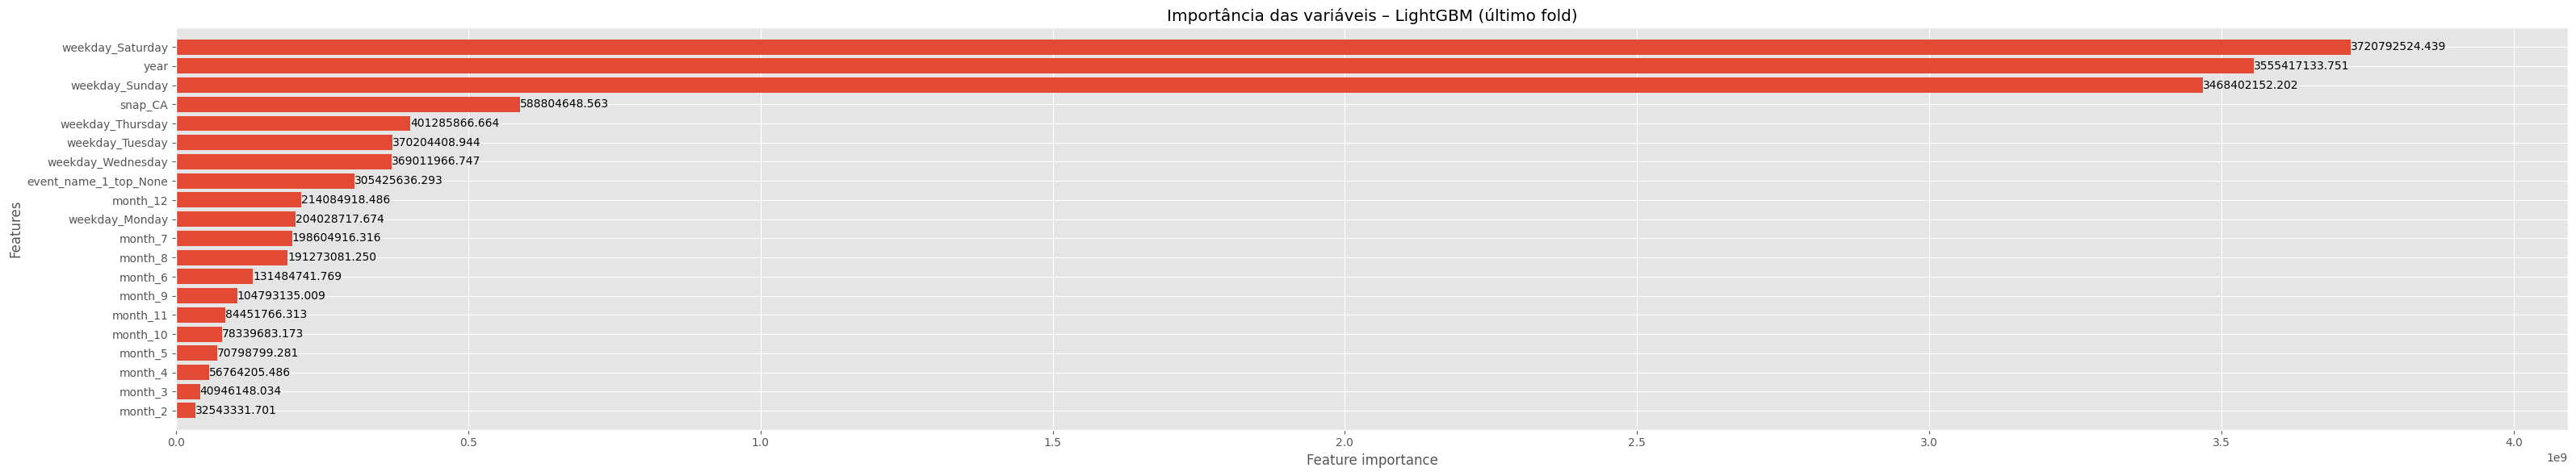

In [104]:
# ==========================================================
# WALK-FORWARD • LightGBM (com exógenas)
#  - último fold = últimos 28 dias
#  - usa avaliar_modelo() no último fold + linha de médias
# ==========================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error

# -----------------------------
# 1) Série completa + EXÓGENAS
# -----------------------------
y_all = pd.concat([y_train.asfreq("D"), y_val.asfreq("D")]).astype("float64")
X_all = pd.concat([X_train, X_val]).reindex(y_all.index)
X_all = X_all.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype("float64")

# (Opcional) identificar categóricas se você tiver colunas ainda como 'category'/'object'
cat_cols = []
for c in X_all.columns:
    if str(X_all[c].dtype) in ("category", "object"):
        X_all[c] = X_all[c].astype("category")
        cat_cols.append(c)

# -----------------------------
# 2) Parâmetros do walk-forward
# -----------------------------
h = 28                 # horizonte p/ cada fold
min_train = 365 * 2    # pelo menos 2 anos para treinar
step_size = h

fold = 0
rmse_list, mae_list, rmsse_list = [], [], []
y_train_last = y_val_last = y_pred_last = None
lgb_model_last = None
X_va_last = None

# -----------------------------
# 3) Loop walk-forward
# -----------------------------
for end_val in range(min_train + h, len(y_all) + 1, step_size):
    end_train = end_val - h

    y_tr = y_all.iloc[:end_train].copy()
    y_va = y_all.iloc[end_train:end_val].copy()
    if len(y_tr) < min_train:
        continue

    X_tr = X_all.iloc[:end_train, :].copy()
    X_va = X_all.iloc[end_train:end_val, :].copy()

    fold += 1
    print(f"\n🔹 LGB Fold {fold}: Treino {y_tr.index[0].date()} → {y_tr.index[-1].date()} | "
          f"Val {y_va.index[0].date()} → {y_va.index[-1].date()} | X_tr shape: {X_tr.shape}")

    # -----------------------------
    # 3.1) Conjuntos LightGBM
    # -----------------------------
    dtrain = lgb.Dataset(
        X_tr, label=y_tr.values,
        categorical_feature=cat_cols if len(cat_cols) > 0 else None,
        free_raw_data=False
    )
    dval = lgb.Dataset(
        X_va, label=y_va.values,
        categorical_feature=cat_cols if len(cat_cols) > 0 else None,
        reference=dtrain,
        free_raw_data=False
    )

    # -----------------------------
    # 3.2) Hiperparâmetros (baseline robusto p/ M5-like)
    # -----------------------------
    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": 0.05,
        "num_leaves": 64,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "min_data_in_leaf": 50,
        "lambda_l2": 1.0,
        "lambda_l1": 0.3,
        "max_depth": -1,
        "seed": 42,
        "verbose": -1,
        # Se tiver GPU disponível no ambiente:
        # "device_type": "gpu"
    }

    # -----------------------------
    # 3.3) Treino com early stopping no val do fold
    # -----------------------------
    lgb_model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=5000,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=200),
            lgb.log_evaluation(period=200)
        ]
    )

    # -----------------------------
    # 3.4) Previsão e métricas do fold
    # -----------------------------
    y_pr = pd.Series(
        lgb_model.predict(X_va, num_iteration=lgb_model.best_iteration),
        index=y_va.index, name="forecast"
    )

    rmse_f  = float(np.sqrt(mean_squared_error(y_va, y_pr)))
    mae_f   = float(mean_absolute_error(y_va, y_pr))
    rmsse_f = float(rmsse_robust(y_va, y_pr, y_tr))
    rmse_list.append(rmse_f); mae_list.append(mae_f); rmsse_list.append(rmsse_f)

    print(f"→ RMSE={rmse_f:.3f} | MAE={mae_f:.3f} | RMSSE={rmsse_f:.3f} | best_iter={lgb_model.best_iteration}")

    # Guardar o último fold (últimos 28 dias)
    y_train_last = y_tr
    y_val_last   = y_va
    y_pred_last  = y_pr
    lgb_model_last = lgb_model
    X_va_last = X_va

# -----------------------------
# 4) Avaliar o último fold (F1–F28)
# -----------------------------
modelo_nm = "LightGBM • Walk-Forward (últimos 28)"
results   = avaliar_modelo(modelo_nm, y_pred_last, y_train_last, y_val_last, results, ultimos_pontos=h)

# -----------------------------
# 5) Linha de médias dos folds
# -----------------------------
results.append({
    "modelo": "LightGBM • Walk-Forward (média folds)",
    "RMSE":   float(np.mean(rmse_list)),
    "MAE":    float(np.mean(mae_list)),
    "RMSSE":  float(np.mean(rmsse_list))
})

print("\n==================== RESUMO WALK-FORWARD (LightGBM) ====================")
print(f"Total de folds: {len(rmse_list)}")
print(f"Média RMSE : {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")
print(f"Média MAE  : {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"Média RMSSE: {np.mean(rmsse_list):.3f} ± {np.std(rmsse_list):.3f}")
print("=======================================================================")

# -----------------------------
# 6) Importância de variáveis (último fold)
# -----------------------------
if lgb_model_last is not None:
    ax = lgb.plot_importance(lgb_model_last, max_num_features=20, importance_type="gain", height=0.8)
    plt.title("Importância das variáveis – LightGBM (último fold)")
    plt.tight_layout()
    plt.show()
